### Library

In [ ]:
!pip install chromadb==0.4.14 # xài bản này để không bị lỗi read only

In [1]:
from dotenv import load_dotenv, find_dotenv
from langchain.schema.runnable import RunnableLambda
import re
import json
load_dotenv(find_dotenv())
import my_utils
# from my_utils import extract_json_from_string
import os
my_utils.setupCuda()
os.environ['TAVILY_API_KEY'] = "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"
# os.getenv("TAVILY_API_KEY")
def extract_triple_quotes(text):
    match = re.search(r'"""(.*?)"""', text, re.DOTALL)
    return match.group(1) if match else None

def extract_json_from_string(text):
    # Xóa dấu phẩy cuối cùng trong JSON nếu có
    text = re.sub(r',\s*}', '}', text)
    text = re.sub(r',\s*\]', ']', text)

    # Lấy từ dấu "{" đầu tiên đến dấu "}" cuối cùng
    match = re.search(r'\{.*\}', text, re.DOTALL)
    
    if match:
        json_str = match.group(0).replace(".","")
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            print("Lỗi: Không thể parse JSON")
            print(f"json_str: {json_str}")
            return None
    return None

def retry_failed_batches(batch_inputs, responses,generater, max_retries=3):
    """Retry batch chỉ cho những input bị lỗi."""
    failed_indices = [i for i, res in enumerate(responses) if not res]
    for attempt in range(max_retries):
        if not failed_indices:
            break  # Nếu không còn lỗi thì dừng lại

        failed_inputs = [batch_inputs[i] for i in failed_indices]
        new_responses = generater.batch(failed_inputs)

        # Cập nhật responses với kết quả mới từ retry
        for i, idx in enumerate(failed_indices):
            if new_responses[i]:
                responses[idx] = new_responses[i]  # Thay thế response cũ bị lỗi

        # Lọc lại danh sách lỗi sau retry
        failed_indices = [i for i, res in enumerate(responses) if not res]
        print(f"Retry {attempt + 1}/{max_retries}: {len(failed_indices)} cases left.")
    if failed_indices:
        print("THERE IS STILL ERROR EVEN TRIED REGEN 3 TIMES")
        print(f"FAIL INPUTS {failed_inputs}")
        print(f"FAIL RESPONSE {new_responses}")        
    return responses

# GRAPH new

### Function for graph

#### Model

In [2]:
from langchain_community.llms.vllm import VLLM
# from vllm import SamplingParams
import json
 
vllm_model = VLLM(
    model="/home/thanhnguyen/Data/code/RAG_techniques/Qwen2.5-14B-Instruct-GPTQ-Int4",
    tensor_parallel_size=1,
    n=1,
    presence_penalty=0.0,
    frequency_penalty=0.0,
    temperature=0.7,
    top_p=0.6,
    top_k=5,
    stop=None,
    ignore_eos=False,
    max_new_tokens=2048,
    logprobs=None,
    download_dir=None,
    vllm_kwargs={
        "quantization":"gptq",
        "max_model_len": 3036,
        "gpu_memory_utilization":0.8
    }
)

/home/thanhnguyen/.conda/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 03-12 04:53:13 __init__.py:190] Automatically detected platform cuda.


2025-03-12 04:53:13,867	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 03-12 04:53:28 config.py:542] This model supports multiple tasks: {'reward', 'generate', 'score', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 03-12 04:53:30 gptq_marlin.py:115] Detected that the model can run with gptq_marlin, however you specified quantization=gptq explicitly, so forcing gptq. Use quantization=gptq_marlin for faster inference
WARNING 03-12 04:53:30 config.py:621] gptq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 03-12 04:53:30 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='/home/thanhnguyen/Data/code/RAG_techniques/Qwen2.5-14B-Instruct-GPTQ-Int4', speculative_config=None, tokenizer='/home/thanhnguyen/Data/code/RAG_techniques/Qwen2.5-14B-Instruct-GPTQ-Int4', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=3036, download_dir=None, load_format=auto, te

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  33% Completed | 1/3 [00:01<00:03,  1.86s/it]
Loading safetensors checkpoint shards:  67% Completed | 2/3 [00:03<00:01,  1.97s/it]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:05<00:00,  1.58s/it]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:05<00:00,  1.67s/it]



INFO 03-12 04:53:39 model_runner.py:1115] Loading model weights took 9.3794 GB
INFO 03-12 04:53:42 worker.py:267] Memory profiling takes 2.31 seconds
INFO 03-12 04:53:42 worker.py:267] the current vLLM instance can use total_gpu_memory (23.65GiB) x gpu_memory_utilization (0.80) = 18.92GiB
INFO 03-12 04:53:42 worker.py:267] model weights take 9.38GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 1.42GiB; the rest of the memory reserved for KV Cache is 8.05GiB.
INFO 03-12 04:53:42 executor_base.py:110] # CUDA blocks: 2746, # CPU blocks: 1365
INFO 03-12 04:53:42 executor_base.py:115] Maximum concurrency for 3036 tokens per request: 14.47x
INFO 03-12 04:53:48 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_util

Capturing CUDA graph shapes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:41<00:00,  1.19s/it]

INFO 03-12 04:54:29 model_runner.py:1562] Graph capturing finished in 42 secs, took 1.91 GiB
INFO 03-12 04:54:29 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 50.27 seconds


#### routerQuery

In [3]:
### Router
from langchain_core.prompts import PromptTemplate

# Prompt 
routerquery_template = """<|im_start|>system

You are an expert in routing user questions to the appropriate data source: either a vectorstore or web search.

Data Sources:
Vectorstore: Contains laws related to labor contracts, labor-related issues, and agreements between employers and employees.
Use this source for questions about employment contracts, worker rights, labor laws, employer-employee agreements, and related regulations.
Web Search: Use this for all other topics that are not covered by the vectorstore.

If the question is ambiguous or partially related to labor laws, prioritize vectorstore unless it explicitly requires external, real-time, or broader information.
Instructions:
Determine the appropriate data source based on the question's topic.
Return the result in the following JSON format:
{{
  "datasource": "vectorstore" | "web_search"
}}
<|im_end|>

<|im_start|>user
Question: {question}

<|im_end|>

<|im_start|>assistant
"""

routerquery_prompt = PromptTemplate.from_template(routerquery_template)

# Chain
question_router = routerquery_prompt | vllm_model |RunnableLambda(extract_json_from_string)

print(question_router.invoke({"question": "who is Biden"}))
print(question_router.invoke({"question": """第1章　総則
第1条（目的）
１．この就業規則（以下「規則」という。）は、株式会社●●●●の労働者の就業に関する事項を定めるものである。
"""}))

Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s, est. speed input: 527.80 toks/s, output: 36.19 toks/s]


{'datasource': 'web_search'}


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s, est. speed input: 943.30 toks/s, output: 49.64 toks/s]

{'datasource': 'vectorstore'}


#### propositions

In [4]:
# proposition_template="""<|im_start|>system
# The following input is a legal document or contract. Your task is to break down the document into simple, self-contained propositions that are easy to understand. Follow these steps:

# 1.Identify key sentences: Read the entire document and identify sentences that contain factual information, rules, or conditions. Ignore introductory sentences, transitional sentences, or ambiguous statements (e.g., "The leave period is as follows." or "The contents of this contract are as follows.").

# 2.Make each proposition self-contained: Each proposition should be understandable on its own, without additional context. Replace pronouns and vague references with specific names or terms.

# 3.Ensure accuracy and completeness: Include necessary details such as dates, legal references, and conditions to ensure the propositions are accurate. Avoid incomplete or ambiguous propositions (e.g., "The company will respond appropriately." → "The company will provide appropriate compensation if an employee suffers a work-related accident.").

# 4.Maintain logical structure: Each proposition should be a complete sentence with a clear subject and predicate. If a rule contains multiple conditions, split them into separate propositions while maintaining logical relationships. Merge related propositions when necessary to preserve meaning.

# 5.Avoid overlapping propositions: Each proposition must convey distinct information and should not be a restatement of another proposition with minor modifications. Avoid cases where one proposition is a broader version of another with additional details. Instead, structure the propositions so that they remain independent while covering all necessary details.

# 6.Extract sub-clause number(s) if available:

# If a sub-clause number (e.g., ①, ②, (1), (2)) appears at the beginning of a sentence in the input document, extract it and associate it with the corresponding proposition.
# Convert numbered symbols to integers (e.g., ① → 1, (2) → 2).
# If multiple sub-clauses are combined into a single proposition, return them as an array (e.g., [1, 2]).
# If no sub-clause number is present, return an empty array [].
# Use appropriate legal or technical terms: Write all propositions in English and use proper legal or technical terminology.
# The response should be in Japanese and returned in following JSON format:
# {{
#   "propositions": 
#     [
#     {{"proposition":"Generated proposition 1",
#       "sub-clause": [int]
#     }},
#     {{"proposition":"Generated proposition 2",
#       "sub-clause": [int]
#     }}...
#     ]
# }}
# <|im_end|>

# <|im_start|>user
# contract:{document}
# <|im_end|>

# <|im_start|>assistant
# """
proposition_template="""<|im_start|>system
The following input is a legal document or contract. Your task is to break down the document into simple, self-contained propositions that are easy to understand. Follow these steps:

1. Identify key sentences: 
Read the entire document and extract factual information, rules, or conditions. Ignore introductory or transitional phrases that do not contain substantial content.

2. Ensure completeness of definitions:  
   - If a proposition defines a term (for example: "Xとは…"), ensure it contains a complete definition.  
   - Do not generate incomplete propositions such as:  
    "A worker is defined as follows." → This does not provide a definition.  
    Instead, include the full definition within the same proposition:  
    "A worker is a person who joins the company according to the procedure set forth in Chapter 2 and meets the following criteria: [list of criteria]."  

3. Make each proposition self-contained:  
   - Ensure the proposition is understandable without additional context.  
   - Replace pronouns or vague references with explicit terms.  

4. Maintain accuracy and include all necessary details:  
   - Retain legal references, dates, and conditions to avoid ambiguity.  
   - If a rule contains multiple conditions, split them into separate propositions while preserving logical relationships.  

5. Avoid overlapping or redundant propositions:  
   - Do not generate broad statements that are just incomplete versions of other propositions.  

6. Use appropriate legal or technical terms: Write all propositions in janpanese and use proper legal or technical terminology.
The response should be in Japanese and returned in following JSON format:
{{
  "propositions": 
    [
    {{"proposition":"Generated proposition in japanese"}}
    ]
}}
<|im_end|>

<|im_start|>user
contract:{document}
<|im_end|>

<|im_start|>assistant
"""
proposition_prompt = PromptTemplate.from_template(proposition_template)
proposition_generator = proposition_prompt | vllm_model| RunnableLambda(extract_json_from_string)
# proposition_generator.invoke({"document":"""会社は、業務上必要がある場合に労働者に対し以下の人事異動を命ずることがある。
# (1)就業する場所及び従事する業務の変更
# (2)関連会社への出向
# (3)関連会社への転籍
# (4)会社は、第３条第２項に定めるところにより、従業員にその他の業務を行わせることができる。                             
# """})
# proposition_generator.invoke({"document":"""労働者として採用された者は、採用を通知された日から会社が指定する期日までに次の書類を提出しなければならない。ただし、会社が認めた場合には、その一部を省略または提出期限を延期することができる。
# 　⑫身元保証書
# 　⑬雇用保険被保険者証の写し
# 　⑭マイナンバーカード又はマイナンバー通知書の写し
# 　⑮資格免許証の写し
# 　⑯健康診断結果
# 　⑰学生証の写し
# 　⑱パスポートの写し
# 　⑲その他会社が必要と認めたもの
# """})
# proposition_generator.invoke({"document":"""労働者として採用された者は、採用を通知された日から会社が指定する期日までに次の書類を提出しなければならない。ただし、会社が認めた場合には、その一部を省略または提出期限を延期することができる。
# 　①履歴書・職務経歴書
# 　②入社誓約書
# 　③個人情報保護法に基づく誓約書
# 　④住民票記載事項証明書
# 　⑤給与所得者の扶養控除等（異動）申告書
# 　⑥源泉徴収票
# 　⑦雇用契約書
# 　⑧年金手帳の写し
# 　⑨通勤手当申請書
# 　⑩住宅手当申請書
# 　⑪給与振込先申請書
# 　⑫身元保証書
# 　⑬雇用保険被保険者証の写し
# 　⑭マイナンバーカード又はマイナンバー通知書の写し
# 　⑮資格免許証の写し
# 　⑯健康診断結果
# 　⑰学生証の写し
# 　⑱パスポートの写し
# 　⑲その他会社が必要と認めたもの
# """})


#### extract reference

In [5]:
extract_reference_template="""<|im_start|>system
You will receive:
1. A passage from a contract that may include references to other sections, articles, clauses, or parts of the contract (e.g., “as specified in Section 2”, “according to the clause above”, “refer to Article 3 below”).
2. Metadata providing context for the current passage, including details such as the current Chapter, Article, and Clause.

### Task:
#### Step 1: Extract References
- Identify and extract all phrases in the contract text that refer to other sections, articles, or clauses.

#### Step 2: Resolve References
- Use the provided metadata to determine the specific Chapter, Article, or Clause that each reference points to.
- Examples:
  - If the metadata indicates that the current passage is in Article 1:
    - "the above article" refers to Article 0 (or the last article of the previous section, if applicable).
    - "clause 3 below" refers to Clause 3 in the subsequent article or section.
- If a reference cannot be precisely resolved, set its "resolved" value to -1.
-"has_reference": "yes" if there is at least one reference, otherwise "no".
-"is_extractable": "yes" if the reference can be extracted and resolved, otherwise "no".
-"references": A list of extracted references, each containing:
-"text": The extracted reference phrase.
-"resolved": The resolved location, with -1 if it cannot be determined.

The response should be in following JSON format. The answer contain json only:
{{
  "has_reference" : "yes" | "no",
  "is_extractable" : "yes" | "no"
  "references": [
    {{
      "text": str,
      "resolved": {{
        "Chapter": int| -1,
        "Article": int| -1,
        "clause": int| -1,
        "sub_clause": int|-1,
      }}
    }}
  ]
}}

<|im_end|>

<|im_start|>user
contract:{document}
metadata:{metadata}
<|im_end|>

<|im_start|>assistant
"""
extract_reference_prompt = PromptTemplate.from_template(extract_reference_template)
extract_reference_generator = extract_reference_prompt | vllm_model| RunnableLambda(extract_json_from_string)
# document = """本契約の第2条に基づき、甲は乙に対し、必要な情報を提供しなければならない。また、第1章の規定に従い、支払いは第3条に定められた条件で行われる。
# """
# document="""本契約の第4条に基づき、甲は、上記2条に記載されている条件に従うものとする。"""
# document="""本契約の第4条第2項第3号に基づき、甲は、上記第2条第1項に記載されている条件に従うものとする。"""
document ="""採用後、配属された担当職種(職務)での勤務成績が劣る場合には、会社は、労働者本人との面接を実施し、教育指導・改善指導を行う。ただし、その後もなお同様の勤務成績が継続した場合には、採用時に明示した労働条件(所定の基本賃金額・諸手当額を含む)を見直し、担当職種、および担当職務の変更を伴う配置転換、転勤、出向等を検討して人事異動を命じる。労働者はこの命令を拒むことはできないものとする。 ただし、配置転換、転勤、出向等の人事異動を行うについて異動により配属する部署、配置する担当職務等、就業場所の確保が困難な場合には、労基法の定めに従い解雇する。"""
# metadata="""{
#   "current_chapter": 2,
#   "current_article": 3
# }"""
metadata="""{
  "current_chapter": 1,
  "current_article": 4,
  "current_clause": 4,
  "current_sub_clause": 5
}"""
extract_reference_generator.invoke({"document":document,"metadata":metadata})

Processed prompts: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s, est. speed input: 1428.56 toks/s, output: 53.38 toks/s]


{'has_reference': 'no', 'is_extractable': 'no', 'references': []}

#### sematic reference

In [6]:
# sematic_reference_template="""<|im_start|>system
# Determine whether the two clauses are directly related in a way that they require each other to be fully understood. If one clause cannot be fully understood without the other, or if they directly complement each other in meaning, return "yes". If each clause can exist independently without losing essential meaning, return "no".

# The response should be returned in following JSON format:
# {{
#   "analysis": "A brief explanation of why they are related or not."
#   "is_related": "yes"|"no",
# }}
# <|im_end|>

# <|im_start|>user
# Clause 1: {clause_1}
# Clause 2: {clause_2}
# <|im_end|>

# <|im_start|>assistant
# """

sematic_reference_template = """<|im_start|>system
You are a language model specializing in analyzing relationships between texts. Your task is to determine whether a referenced text (Referenced Text) provides additional meaning that helps in understanding the main text (Main Text).

Task:
Check whether the referenced text provides necessary additional information to better understand the main text.

If the referenced text contains important supplementary information that clarifies, explains, or provides essential context for understanding the main text, respond with "yes".
If the referenced text does not add significant meaning or merely repeats existing information, respond with "no".

The response must be returned in following JSON format, return json only:
{{
  "analysis": "A brief explanation of the relationship between the texts, must not include `"`.",
  "provide_additional_meaning": "yes"|"no",
  
}}
<|im_end|>

<|im_start|>user
Main Text: {main_text}
Referenced Text: {referenced_text}
<|im_end|>

<|im_start|>assistant
"""
sematic_reference_prompt = PromptTemplate.from_template(sematic_reference_template)
sematic_reference_generator = sematic_reference_prompt | vllm_model| RunnableLambda(extract_json_from_string)

main_text ="""解雇の予告期間は労働基準法に基づき、最低30日とするが、当社は40日間の通知期間を設ける。"""
referenced_text ="""解雇の予告は労働基準法に準じ、30日以内とする。"""

sematic_reference_generator.invoke({"main_text":main_text,"referenced_text":referenced_text})

Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it, est. speed input: 187.26 toks/s, output: 69.53 toks/s]


{'analysis': '主な文章は、会社が40日間の通知期間を設けることを示していますが、参照された文章は解雇の予告期間を最低30日とするという労働基準法の規定を述べています。これは、主な文章の理解に必要な追加的な文脈を提供します。',
 'provide_additional_meaning': 'yes'}

#### rewrite with query and refs

In [7]:
rewrite_clause_template = """<|im_start|>system
You are a legal text processing expert. Your task is to merge two contract sections into a single coherent text while ensuring clarity, accuracy, and legal consistency.

main_section: This is the primary contract section, which may reference specific clauses from another section.
refer_section: This section contains detailed information referenced in main_section.
Requirements:
1.If the main_section references a specific clause in the refer_section, replace the reference with the actual content from the refer_section.
2.Completely remove any reference phrases such as "as defined in clause X", "according to article Y", or any similar wording. The final text should only contain the actual content without referring back to any section or clause.
3.Preserve the original meaning of the contract without altering its legal intent.
4.Ensure the final merged text maintains a clear, structured, and legally sound format.
5.The final "generated_clause" must be self-contained and must not contain any reference phrases even if reference phrases are present in the refer_sections.
6.All newlines are represented using "\\n" instead of actual line breaks.
The response must be in following JSON format.:
{{
  "analysis": "Logical reasoning behind how the generated clause was created, including how references were replaced.",
  "generated_section": "The fully rewritten section with all references replaced by full content, properly formatted and structured, without any reference phrases.Ensure that in the JSON response"
}}
<|im_end|>

<|im_start|>user
main section:
{main_section}
refer sections:
{refer_sections}
<|im_end|>
<|im_start|>assistant
"""

rewrite_clause_prompt = PromptTemplate.from_template(rewrite_clause_template)

rewrite_clause_generator = rewrite_clause_prompt | vllm_model | RunnableLambda(extract_json_from_string)

main_section = """この規則は、本条第2項に規定するすべての労働者に適用する。また本規則における労働者とは本条第2項に規定するもののことを指す。"""

refer_sections = """第1章\u3000総則 \n 第2条（労働者の定義及び適用範囲）\n2．この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。 ①\u3000正社員・・・・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働 者で期間の定めがなく雇用される基幹業務に従事する労働者 ②\u3000勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と 比べ限定され雇用される労働者 ③\u3000職務限定社員・・・・契約社員・アルバイト以外の労働者で期間の定めがなく職務が正社員と比 べ限定され雇用される労働者 ④\u3000短時間正社員・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働 者で期間の定めがなくフルタイム勤務で働く正社員に比べ短い労働時間で 雇用される労働者 ⑤\u3000無期契約社員・・・・正社員以外で無期労働契約により雇用される基幹業務の補助をする労働者 ⑥\u3000有期契約社員・・・・有期労働契約により雇用される基幹業務の補助をする労働者。原則1年ご との更新とし、個別に定めるものとする。 ⑤\u3000嘱託社員・・・・・・定年退職後に引き続き有期労働契約により雇用される労働者。原則1年ご との更新とし、個別に定めるものとする。 ⑥\u3000パート／アルバイト\u3000契約期間の有無にかかわらず、業務の一部や臨時的に業務を行う労働者 ⑦\u3000派遣社員・・・・・・派遣元事業所より派遣され、派遣元の指揮命令を受け就業する労働者"""


new_query = rewrite_clause_generator.invoke({"main_section": main_section, "refer_sections": refer_sections})
print(new_query)

Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it, est. speed input: 109.75 toks/s, output: 72.56 toks/s]

{'analysis': '主なセクションは、参照セクションの第2条第2項を参照しています。したがって、参照セクションの該当する部分を主セクションに置き換え、参照表現を削除しました。', 'generated_section': 'この規則は、第2章に定める手続きにより入社した以下の労働者に適用する。 ①\u3000正社員・・・・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働 者で期間の定めがなく雇用される基幹業務に従事する労働者 ②\u3000勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と 比べ限定され雇用される労働者 ③\u3000職務限定社員・・・・契約社員・アルバイト以外の労働者で期間の定めがなく職務が正社員と比 べ限定され雇用される労働者 ④\u3000短時間正社員・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働 者で期間の定めがなくフルタイム勤務で働く正社員に比べ短い労働時間で 雇用される労働者 ⑤\u3000無期契約社員・・・・正社員以外で無期労働契約により雇用される基幹業務の補助をする労働者 ⑥\u3000有期契約社員・・・・有期労働契約により雇用される基幹業務の補助をする労働者。原則1年ご との更新とし、個別に定めるものとする。 ⑦\u3000嘱託社員・・・・・・定年退職後に引き続き有期労働契約により雇用される労働者。原則1年ご との更新とし、個別に定めるものとする。 ⑧\u3000パート／アルバイト\u3000契約期間の有無にかかわらず、業務の一部や臨時的に業務を行う労働者 ⑨\u3000派遣社員・・・・・・派遣元事業所より派遣され、派遣元の指揮命令を受け就業する労働者\nまた、この規則における労働者とは、上記の定義される労働者のことを指す。'}


#### generation

In [8]:


# Prompt

# template="""<|im_start|>system
# You are a legal analysis AI specializing in contract evaluation. Your task is to analyze a given contract segment and determine whether it violates, complies with, or lacks sufficient information to conclude compliance or violation based on the provided laws.
# Inputs are Laws and Contract Segment.
# Laws: A set of legal provisions relevant to the contract.
# Contract Segment: A specific portion of a contract that needs evaluation.

# Evaluation Criteria:
# Compliance: The contract fully adheres to the relevant legal provisions.
# Violation: The contract contradicts or does not meet the requirements of the legal provisions.
# Insufficient Information: The given contract segment does not provide enough details to determine compliance or violation.
# The response should be in Japanese and returned in following JSON format:
# {{
#   "evaluation": "compliance" | "violation" | "insufficient_information",
#   "explanation": "A brief but clear explanation of why the contract complies, violates, or lacks sufficient information.",
#   "legal_references": [
#     {{
#       "law": "The specific law that was referenced",
#       "relevance": "Explanation of how this law applies to the contract"
#     }}
#   ],
#   "suggested_corrections": "Suggested modifications (if necessary) to ensure compliance."
# }}
# <|im_end|>

# <|im_start|>user
# Laws: [{context}].
# Contract Segment: [{contract}]

# <|im_end|>

# <|im_start|>assistant
# """

# template="""<|im_start|>system
# You are a legal analysis AI specializing in contract evaluation. Your task is to analyze a given contract segment and determine whether it violates, complies with, or lacks sufficient information to conclude compliance or violation based on the provided laws.
# Inputs are Laws and Contract Segment.
# Laws: A set of legal provisions relevant to the contract.
# Contract Segment: A specific portion of a contract that needs evaluation.

# Evaluation Criteria:
# Compliance: The contract fully adheres to the relevant legal provisions.
# Violation: The contract contradicts or does not meet the requirements of the legal provisions.
# Insufficient Information: The given contract segment does not provide enough details to determine compliance or violation.
# The response should be in Japanese and returned in following JSON format:
# {{
#   "evaluation": "compliance" | "violation" | "insufficient_information",
#   "explanation": "A brief but clear explanation of why the contract complies, violates, or lacks sufficient information.",
# }}
# <|im_end|>

# <|im_start|>user
# Laws: [{context}].
# Contract Segment: [{contract}]

# <|im_end|>

# <|im_start|>assistant
# """

# prompt = PromptTemplate.from_template(template)

# # Chain
# rag_chain = prompt | vllm_model | RunnableLambda(extract_json_from_string)


# contract="""第5条（労働時間および休憩時間）

# 従業員の労働時間は、1日8時間、週40時間を超えないものとする。"""
# context="""労働基準法 (労基法) 第32条 - 労働時間の制限
# 使用者は、労働者に対し、1週間について40時間を超えて労働させてはならない。
# 使用者は、労働者に対し、1日について8時間を超えて労働させてはならない。
# 労働基準法 (労基法) 第34条 - 休憩時間
# 使用者は、労働時間が6時間を超える場合は少なくとも45分、8時間を超える場合は少なくとも1時間の休憩時間を労働者に与えなければならない。
# 休憩時間は、労働時間の途中に与えなければならず、自由に利用させなければならない。"""
# # Run
# generation = rag_chain.invoke({"context": context, "contract": contract})
# print(generation)
# # print(prompt)

In [9]:

# Template với cả query, context và new_query
template_both = """<|im_start|>system
You are a legal AI specializing in contract evaluation. Your task is to analyze a given contract clause and determine whether it *complies with, violates, or lacks sufficient information* to conclude compliance based on the provided legal provisions.

### *Inputs:*  
- *Laws:* Relevant legal provisions related to the contract.  
- *Contract Clause:* The specific contract segment to be evaluated.  
- *Rewritten Contract Clause:* An alternative, clearer version of the contract clause for better understanding.

### *Evaluation Criteria:*  
1. *Compliance:* The contract fully adheres to the relevant legal provisions.  
2. *Violation:* The contract contradicts or does not meet the legal requirements.  
3. *Insufficient Information:* The provided contract clause lacks enough details to determine compliance or violation.  

### *Response Format (in Japanese, JSON format):*  
json
{{
  "evaluation": "compliance" | "violation" | "insufficient_information",
  "explanation": "A concise explanation of why the contract complies, violates, or lacks sufficient information."
}}

<|im_end|>

<|im_start|>user
Laws: [{context}].  
Contract Clause: [{contract}].  
Rewritten Contract Clause: [{new_query}].  
<|im_end|>

<|im_start|>assistant
"""

# Tạo PromptTemplate
prompt_both = PromptTemplate.from_template(template_both)

# Chuỗi chạy RAG
rag_chain_both = prompt_both | vllm_model | RunnableLambda(extract_json_from_string)

# Dữ liệu đầu vào
contract = """第5条（労働時間および休憩時間）
従業員の労働時間は、1日8時間、週40時間を超えないものとする。"""

context = """労働基準法 (労基法) 第32条 - 労働時間の制限
使用者は、労働者に対し、1週間について40時間を超えて労働させてはならない。
使用者は、労働者に対し、1日について8時間を超えて労働させてはならない。
労働基準法 (労基法) 第34条 - 休憩時間
使用者は、労働時間が6時間を超える場合は少なくとも45分、8時間を超える場合は少なくとも1時間の休憩時間を労働者に与えなければならない。
休憩時間は、労働時間の途中に与えなければならず、自由に利用させなければならない。"""

new_query = """従業員は1日8時間以内、または週40時間以内の労働が求められる。"""

# Chạy RAG chain
generation = rag_chain_both.invoke({"context": context, "contract": contract, "new_query": new_query})
print(generation)

Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it, est. speed input: 412.33 toks/s, output: 65.69 toks/s]

{'evaluation': 'compliance', 'explanation': '契約条項は、労働基準法第32条の規定に従い、1日8時間、週40時間以内の労働時間を定めています。したがって、法律の要件を満たしています。'}


In [10]:
# Define the prompt template
template_doc = """<|im_start|>system
You are a legal AI specializing in contract evaluation. Your task is to analyze a given contract clause and determine whether it *complies with, violates, or lacks sufficient information* to conclude compliance based on the provided legal provisions.  

### *Inputs:*  
- *Laws:* Relevant legal provisions related to the contract.  
- *Contract Clause:* The specific contract segment to be evaluated.  

### *Evaluation Criteria:*  
1. *Compliance:* The contract fully adheres to the relevant legal provisions.  
2. *Violation:* The contract contradicts or does not meet the legal requirements.  
3. *Insufficient Information:* The provided contract clause lacks enough details to determine compliance or violation.  

### *Response Format (in Japanese, JSON format):*  
```json
{{
  "evaluation": "compliance" | "violation" | "insufficient_information",
  "explanation": "A concise explanation of why the contract complies, violates, or lacks sufficient information."
}}
<|im_end|>

<|im_start|>user
Laws: [{context}].
Contract Segment: [{contract}]

<|im_end|>

<|im_start|>assistant
"""

# Create prompt
prompt_doc = PromptTemplate.from_template(template_doc)

rag_chain_doc = prompt_doc | vllm_model | RunnableLambda(extract_json_from_string)

# Example contract and laws
contract = """第5条（労働時間および休憩時間）

従業員の労働時間は、1日8時間、週40時間を超えないものとする。"""
context = """労働基準法 (労基法) 第32条 - 労働時間の制限
使用者は、労働者に対し、1週間について40時間を超えて労働させてはならない。
使用者は、労働者に対し、1日について8時間を超えて労働させてはならない。
労働基準法 (労基法) 第34条 - 休憩時間
使用者は、労働時間が6時間を超える場合は少なくとも45分、8時間を超える場合は少なくとも1時間の休憩時間を労働者に与えなければならない。
休憩時間は、労働時間の途中に与えなければならず、自由に利用させなければならない。"""

# Run inference
generation = rag_chain_doc.invoke({"context": context, "contract": contract})
print(generation)

Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it, est. speed input: 291.02 toks/s, output: 68.63 toks/s]

{'evaluation': 'compliance', 'explanation': '契約条項は、労働基準法第32条の規定に従い、労働時間を1日8時間、週40時間以内に制限しています。また、休憩時間の規定については言及していませんが、現行の条項は労働時間の制限に関しては法に準拠しています。'}


#### websearch grader

In [11]:
### Retrieval Grader 

websearch_grader_template="""<|im_start|>system
You are an evaluator assessing whether a retrieved reference can serve as **direct legal evidence** to determine if a given contract segment complies with legal standards.

### **Evaluation Criteria:**
- Answer **"yes"** **only if** the retrieved reference is a law, regulation, or legally binding document that provides **direct evidence** for assessing the contract segment’s compliance or violation.
- Answer **"no"** in all other cases, including:
  - The reference is **not an actual law** (e.g., a general explanation, opinion, or guideline).
  - The reference **does not directly address** the criteria mentioned in the contract segment.
  - The reference is **too vague or general** to be used as clear legal evidence.

Your response should be **strictly based on whether the reference can serve as legal proof**.

### **Reasoning Steps:**
Follow these steps to evaluate the relevance of the reference context:

**Step 1: Understand the Contract Segment**
- Read the contract segment carefully to identify its key terms, obligations, rights, or conditions.
- Highlight the main requirements or claims in the segment. For example:
  - What is being promised or agreed upon?
  - Are there specific conditions, deadlines, or obligations?
  - What legal standards or regulations might apply?

**Step 2: Understand the Reference Context**
- Read the reference context carefully to understand the information it provides.
- Identify any legal provisions, rules, or facts that relate to the contract segment. For example:
  - Does the reference context mention laws, regulations, or standards that apply to the contract segment?
  - Does it provide evidence or context that supports or challenges the segment's compliance?

**Step 3: Compare and Analyze**
- Compare the reference context with the contract segment. Look for:
  - **Alignment**: Does the reference context confirm or support the contract segment's compliance?
  - **Contradiction**: Does the reference context contradict or disprove the contract segment's compliance?
  - **Gaps**: Is the reference context insufficient or irrelevant to the contract segment?
- Evaluate whether the reference context provides **direct and actionable evidence** to determine compliance or violation.

### Expected Output:
Provide your response in the following JSON format:
{{
  "analysis": "your step-by-step reasoning and analysis",
  "binary_score": "yes" | "no"
}}

### Examples:
#### Example 1:
- Reference Context: "According to Article 12 of the Labor Law, employees must be provided with a minimum of 12 days of paid annual leave."
- Contract Segment: "The company agrees to provide employees with 10 days of paid annual leave."
- Analysis: "The reference context states that the Labor Law requires a minimum of 12 days of paid annual leave, while the contract segment provides only 10 days. This directly contradicts the legal requirement, proving non-compliance."
- Binary Score: "yes"

#### Example 2:
- Reference Context: "According to Article 15 of the Tax Code, businesses must file their tax returns by March 31st each year."
- Contract Segment: "The company agrees to deliver the product by January 15, 2024."
- Analysis: "The reference context discusses tax filing deadlines, which is unrelated to the contract segment about product delivery. There is no direct link between the two."
- Binary Score: "no"

#### Example 3:
- Reference Context: "According to Article 20 of the Consumer Protection Law, sellers must provide a 30-day return policy for defective products."
- Contract Segment: "The seller agrees to provide a 14-day return policy for defective products."
- Analysis: "The reference context states that the Consumer Protection Law requires a 30-day return policy, while the contract segment provides only 14 days. This directly contradicts the legal requirement, proving non-compliance."
- Binary Score: "yes"

#### Example 4:
- Reference Context: "According to Article 5 of the Environmental Protection Act, companies must reduce carbon emissions by 20% by 2030."
- Contract Segment: "The company agrees to reduce carbon emissions by 15% by 2030."
- Analysis: "The reference context states that the Environmental Protection Act requires a 20% reduction in carbon emissions, while the contract segment commits to only 15%. This directly contradicts the legal requirement, proving non-compliance."
- Binary Score: "yes"

#### Example 5:
- Reference Context: "According to Article 8 of the Data Privacy Law, companies must obtain explicit consent before collecting personal data."
- Contract Segment: "The company agrees to deliver the product within 7 days of purchase."
- Analysis: "The reference context discusses data privacy requirements, which is unrelated to the contract segment about product delivery. There is no direct link between the two."
- Binary Score: "no"

<|im_end|>

<|im_start|>user
Reference Context: [{context}].
Contract Segment: [{contract}].
<|im_end|>

<|im_start|>assistant"""

websearch_grader_prompt = PromptTemplate.from_template(websearch_grader_template)

# Chain
websearch_grader = websearch_grader_prompt | vllm_model |RunnableLambda(extract_json_from_string)


# generation = retrieval_grader.invoke({"context": """この法律で「労働者」とは、職業の種類を問わず、事業又は事務所（以下「事業」という。）に使用される者で、賃金を支払われる者をいう。
# """, "contract": """**労働者の定義**

# 本契約において、「労働者」とは、第2章に規定する手続きに従って入社した者であり、特定の定義に基づいて分類される者を指します。"""})
generation = websearch_grader.batch([{"context": """メニュー 会員登録 気になる 閲覧履歴 検索 転職情報を収集する 求人と出合う 企業と出合う 会員限定メニュー 【Career Pedia】転職実用辞典「キャリペディア」 内定取り消しとは？違法・認められる場合・対処法・判断基準を解説 更新日：2025年02月17日 監修者谷所\u3000健一郎 キャリア・デベロップメント・アドバイザー（CDA）／有限会社キャリアドメイン\u3000代表取締役 転職先から内定をもらったとしても、その後、内定取り消しにならないか不安になる方もいるのではないでしょうか。 内定取り消しになると転職活動の再開や生活設計の見直しが必要になるなど、内定者には大きな負担がかかります。 内定取り消しとはどのようなものか、違法性の有無、取り消しとなった場合の対処法について解説します。 内定取り消しとは 内定取り消しとは、企業側が一度出した内定を取り消すことです。 内定は、企業が求職者を正式に採用するための約束であり、企業が出した内定に求職者が合意し、内定が成立したタイミングで、企業と求職者の間に労働契約が成立します。 入社までにやむをえない事由が発生した場合、内定を取り消すことがあるといった条件付きの始期付解約権留保付労働契約が成立しますが、内定取り消しは事実上「解雇」と同じ意味を持ちます。 求職者を守るために、「解雇」の条件は法律で制限が設けられており、内定取り消しも同様です。 そのため、内定取り消しは企業側にも一定のリスクと義務が伴うため、簡単にできることではありません。 完全在宅勤務・フルリモートワークの求人""",
                                      "contract": """採用内定者が次の各号のいずれかに該当する場合は、内定を取り消し、採用しない。\n採用内定後に傷病に罹患し、または採用選考時に過去の病歴、持病、および現在の治療中の傷病について健康告知を怠り、健康状態が業務に耐えられないと会社が判断したとき"""}]*10)
print(generation)
# print(prompt)


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s, est. speed input: 2394.75 toks/s, output: 245.30 toks/s]

[{'analysis': "The reference context provides a general explanation about the concept of '内定取り消し' (cancellation of an employment offer) and mentions that such cancellations are subject to legal restrictions similar to those governing dismissals However, the specific conditions under which an employment offer can be canceled are not detailed in the reference context The contract segment, on the other hand, specifies conditions under which an employment offer can be canceled, such as the candidate becoming ill after receiving the offer or failing to disclose past health issues during the selection process While the reference context provides background information, it does not directly address the specific conditions mentioned in the contract segment Therefore, the reference context does not serve as direct legal evidence for assessing the compliance of the contract segment", 'binary_score': 'no'}, {'analysis': "The reference context discusses the concept of '内定取り消し' (cancellation of an 

#### retrieval grader

In [12]:
### Retrieval Grader 

retrieval_grader_template="""<|im_start|>system
You are an evaluator assessing the relevance of a retrieved law to a given contract segment.
Evaluation Criteria:
Answer "yes" only if the retrieved law can be used as direct evidence to determine whether the contract segment complies with the law or violates the law.
In all other cases, including where the law is not directly applicable or does not provide clear evidence of compliance or non-compliance, answer "no".
The law must have a direct and actionable link to the contract segment's compliance or violation of legal standards.

Your response should focus on whether the law can serve as direct evidence of the contract’s legal compliance or non-compliance.

Provide a binary score to indicate relevance:
"yes": The law provides direct evidence of the contract segment’s compliance or violation of the law.
"no": The law does not provide direct evidence regarding compliance or violation.

The response should be returned in following JSON format:
{{
  "binary_score": "yes" |"no"
}}
<|im_end|>

<|im_start|>user
Law: [{context}].
Contract Segment: [{contract}]

<|im_end|>

<|im_start|>assistant
"""

retrieval_grader_prompt = PromptTemplate.from_template(retrieval_grader_template)

# Chain
retrieval_grader = retrieval_grader_prompt | vllm_model |RunnableLambda(extract_json_from_string)


# generation = retrieval_grader.invoke({"context": """この法律で「労働者」とは、職業の種類を問わず、事業又は事務所（以下「事業」という。）に使用される者で、賃金を支払われる者をいう。
# """, "contract": """**労働者の定義**

# 本契約において、「労働者」とは、第2章に規定する手続きに従って入社した者であり、特定の定義に基づいて分類される者を指します。"""})
generation = retrieval_grader.batch([{"context": """この法律で「労働者」とは、職業の種類を問わず、事業又は事務所（以下「事業」という。）に使用される者で、賃金を支払われる者をいう。
""", "contract": """**労働者の定義**

本契約において、「労働者」とは、第2章に規定する手続きに従って入社した者であり、特定の定義に基づいて分類される者を指します。"""}]*50)

print(generation)
# print(prompt)


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.53it/s, est. speed input: 5240.39 toks/s, output: 181.84 toks/s]

[{'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score': 'no'}, {'binary_score'

In [13]:
generation

[{'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},
 {'binary_score': 'no'},


#### hallucination grader

In [14]:
### Retrieval Grader 

# hallucination_grader_template="""<|im_start|>system
# The input consists of laws and a generated explanation.
# Your task is to determine whether the generated explanation is supported by the information in the laws.

# ### Evaluation criteria:
# - If the explanation is directly supported by the laws, return "yes".
# - If the explanation is not supported by the laws, return "no".

# The response must be returned in the following JSON format:
# {{"analysis": "A brief explanation of the relationship between the texts, must not include `"`.",
#   "is_supported": "yes" or "no"
# }}
# <|im_end|>

# <|im_start|>user
# laws: [{laws}]  
# generated explanation: [{explanation}]  
# <|im_end|> 
# <|im_start|>assistant
# """
# hallucination_grader_template="""<|im_start|>system
# The input consists of laws,contract and a generated explanation.
# Your task is to determine whether the generated explanation strictly relies on the given laws for its content.

# ### Evaluation criteria:
# - If the explanation is fully supported by and directly derived from the laws, return "yes".
# - If the explanation includes information not explicitly stated in the laws, return "no".

# The response must be returned in the following JSON format:
# {{"analysis": "A brief explanation of whether the explanation strictly follows the laws",
#   "is_supported": "yes" or "no"
# }}
# <|im_end|>

# <|im_start|>user
# laws: [{laws}]  
# contract: [{contract}]
# generated explanation: [{explanation}]  
# <|im_end|> 
# <|im_start|>assistant
# """
hallucination_grader_template="""<|im_start|>system
The input consists of laws, a contract, and a generated explanation.  
Your task is to determine whether the generated explanation strictly relies on the provided laws and contract without introducing new context.  

### Evaluation criteria:  
- If the explanation only uses information directly from the laws and contract, return "yes".  
- The explanation may include a conclusion (e.g., stating whether the contract is correct, incorrect, or lacks enough information), and this is **acceptable** as long as the reasoning **before** the conclusion strictly follows the laws and contract.  
- Return "no" **only if** the explanation introduces new context, makes assumptions, or includes information not explicitly stated in the laws and contract.  

### Examples:

#### Example 1 
**Laws:** "Employers must give at least 30 days’ notice before termination."  
**Contract:** "Employees must be given at least 40 days notice before termination."  
**Generated Explanation:**  
"The contract states that employees must be given at least 40 days' notice before termination, which is stricter than the law requiring 30 days. This means the contract is legally valid but more protective than the minimum legal requirement."  

*Analysis: The explanation strictly follows the laws and contract without adding new information. The conclusion is based entirely on the provided text.*  
*is_supported: yes
Your response must be in the following JSON format:  
{{
  "analysis": "A brief explanation of whether the generated explanation strictly follows the laws and contract.",
  "is_supported": "yes" or "no"
}}
<|im_end|>

<|im_start|>user
laws: [{laws}]  
contract: [{contract}]  
generated explanation: [{explanation}]  
<|im_end|>  
<|im_start|>assistant

"""


hallucination_grader_prompt = PromptTemplate.from_template(hallucination_grader_template)

# Chain
hallucination_grader = hallucination_grader_prompt | vllm_model|RunnableLambda(extract_json_from_string)

contract = """使用者は、従業員を解雇する場合、解雇の少なくとも40日前にその旨を通知しなければならない。"""

explanation = """本契約条項は、労働基準法第二十条に基づいて、雇用主が従業員を解雇する場合、少なくとも30日前に通知する必要があると規定しているが、本契約条項では40日前に通知する必要があると規定しているため、誤りである。"""

laws="""昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第二十条\u3000解雇の予告/使用者は、労働者を解雇しようとする場合においては、少くとも三十日前にその予告をしなければならない。三十日前に予告をしない使用者は、三十日分以上の平均賃金を支払わなければならない。但し、天災事変その他やむを得ない事由のために事業の継続が不可能となつた場合又は労働者の責に帰すべき事由に基いて解雇する場合においては、この限りでない。\n前項の予告の日数は、一日について平均賃金を支払つた場合においては、その日数を短縮することができる。\n前条第二項の規定は、第一項但書の場合にこれを準用する。"""

generation = hallucination_grader.batch([{"laws": laws,"contract":contract, "explanation": explanation}]*10)
print(generation)
# print(prompt)


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s, est. speed input: 2198.04 toks/s, output: 267.58 toks/s]

[{'analysis': 'The generated explanation states that the contract is incorrect because it requires a 40-day notice, which is more than the 30-day notice required by the law The explanation strictly follows the laws and contract without introducing new context or making assumptions', 'is_supported': 'yes'}, {'analysis': 'The generated explanation states that the contract is incorrect because it requires a 40-day notice, which is more than the 30-day notice required by the law However, the explanation does not introduce any new context or assumptions beyond what is provided in the laws and contract', 'is_supported': 'yes'}, {'analysis': 'The generated explanation states that the contract is incorrect because it requires a 40-day notice, which is more than the 30-day notice required by the law However, it does not introduce any new context or assumptions beyond what is provided in the laws and contract', 'is_supported': 'yes'}, {'analysis': "The generated explanation mentions that the con

#### answer grader

In [15]:
answer_grader_template="""<|im_start|>system
The input consists of a contract and a generated explanation.
Your task is to determine whether the generated explanation truly explains the contract.

### Evaluation criteria:
- If the explanation correctly interprets or clarifies the contract, return "yes".
- If the explanation does not accurately explain the contract, return "no".

The response must be returned in the following JSON format:
{{
  "is_valid_explanation": "yes" or "no",
}}
<|im_end|>

<|im_start|>user
contract: [{contract}]  
generated explanation: [{explanation}]  
<|im_end|> 
<|im_start|>assistant
"""


answer_grader_prompt = PromptTemplate.from_template(answer_grader_template)

# Chain
answer_grader = answer_grader_prompt | vllm_model|RunnableLambda(extract_json_from_string)
explanation = """契約条項によると、労働時間は1日8時間、週40時間以内と定められています。  
また、休憩時間については、労働時間が6時間を超え8時間以下の場合、本契約では具体的な時間が記載されておらず、後で通知されることになっています。  
そのため、この範囲の労働時間に関する休憩時間は現時点では未定ですが、契約上は通知されることが明示されています。  
さらに、8時間を超える場合には1時間の休憩があると規定されています。
"""
contract ="""本契約に基づき、従業員の労働時間は1日8時間、週40時間以内とする。  
ただし、休憩時間については、労働時間が6時間を超え8時間以下の場合は後で通知される。  
8時間を超える場合、休憩時間は1時間とする。"""

generation = answer_grader.batch([{"contract": contract, "explanation": explanation}]*3)
print(generation)
# print(prompt)


Processed prompts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.55it/s, est. speed input: 2565.06 toks/s, output: 111.15 toks/s]

[{'is_valid_explanation': 'yes'}, {'is_valid_explanation': 'yes'}, {'is_valid_explanation': 'yes'}]


#### query transformation

In [16]:
# kết hợp paraphrase + Granularity Adjustment + query expansion
query_transformation_template="""<|im_start|>system
You are a natural language processing expert. Your task is to transform the input query into different variations based on the following criteria:  
### Instructions:  
1. **Paraphrasing (1 variations):** Rewrite the query in a different way while keeping the meaning unchanged.  
2. **Granularity Adjustment - More Detailed (1 variations):** Rewrite the query with a higher level of detail by adding specific elements without changing its meaning.  
3. **Granularity Adjustment - Less Detailed (1 variations):** Rewrite the query in a more generalized way by removing details while maintaining the overall meaning.  
4. **Query Expansion (1 variations):** Expand the query by adding relevant information to make it more comprehensive.  

The response must be returned in the following JSON format:
{{
  "paraphrased_queries": [
    "Paraphrased query"
  ],
  "detailed_queries": [
    "More detailed query"
  ],
  "generalized_queries": [
    "More generalized query"
  ],
  "expanded_queries": [
    "Expanded query"
  ]
}}
<|im_end|>

<|im_start|>user
Input Query:{query}  
<|im_end|> 
<|im_start|>assistant
"""

query_transformation_prompt = PromptTemplate.from_template(query_transformation_template)

# Chain
query_transformation_generator = query_transformation_prompt | vllm_model|RunnableLambda(extract_json_from_string)

test =[{'query': '変更事項は以下の書類の記載事項や次の事項を含む：①履歴書・職務経歴書、②入社誓約書、③個人情報保護法に基づく誓約書、④住民票記載事項証明書、⑤給与所得者の扶養控除等（異動）申告書、⑥源泉徴収票、⑦雇用契約書、⑧年金手帳の写し、⑨通勤手当申請書、⑩住宅手当申請書、⑪給与振込先申請書、⑫身元保証書、⑬雇用保険被保険者証の写し、⑭マイナンバーカード又はマイナンバー通知書の写し、⑮資格免許証の写し、⑯健康診断結果、⑰学生証の写し、⑱パスポートの写し、⑲その他会社が必要と認めたもの、氏名。'}, {'query': '変更事項には、1 履歴書・職務経歴書、2 入社誓約書、3 個人情報保護法に基づく誓約書、4 住民票記載事項証明書、5 給与所得者の扶養控除等（異動）申告書、6 源泉徴収票、7 雇用契約書、8 年金手帳の写し、9 通勤手当申請書、10 住宅手当申請書、11 給与振込先申請書、12 身元保証書、13 雇用保険被保険者証の写し、14 マイナンバーカード又はマイナンバー通知書の写し、15 資格免許証の写し、16 健康診断結果、17 学生証の写し、18 パスポートの写し、19 その他会社が必要と認めたもの、学歴、資格、免許が含まれる。'}]
# generation = query_transformation_generator.invoke({"query": "勤務地限定社員とは契約社員、アルバイト以外の労働者で期間の定めがなく勤務地が正社員と比べて限定され雇用される労働者を指す。"})
generation = query_transformation_generator.batch(test)
print(generation)
# print(prompt)


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.51s/it, est. speed input: 42.08 toks/s, output: 120.38 toks/s]

[{'paraphrased_queries': ['変更事項は次のような書類の内容や事項を含む：①履歴書・職務経歴書、②入社誓約書、③個人情報保護法に基づく誓約書、④住民票記載事項証明書、⑤給与所得者の扶養控除等（異動）申告書、⑥源泉徴収票、⑦雇用契約書、⑧年金手帳の写し、⑨通勤手当申請書、⑩住宅手当申請書、⑪給与振込先申請書、⑫身元保証書、⑬雇用保険被保険者証の写し、⑭マイナンバーカード又はマイナンバー通知書の写し、⑮資格免許証の写し、⑯健康診断結果、⑰学生証の写し、⑱パスポートの写し、⑲その他会社が必要と判断した書類、氏名。'], 'detailed_queries': ['変更事項は以下の書類の記載事項や事項を含む：①履歴書・職務経歴書（職種、勤務期間、職歴等）、②入社誓約書（会社の規則への同意）、③個人情報保護法に基づく誓約書（個人情報の取り扱いに関する同意）、④住民票記載事項証明書（住所、氏名等）、⑤給与所得者の扶養控除等（異動）申告書（扶養家族の情報）、⑥源泉徴収票（給与所得の源泉徴収状況）、⑦雇用契約書（雇用条件、期間等）、⑧年金手帳の写し（年金加入状況）、⑨通勤手当申請書（通勤経路、距離等）、⑩住宅手当申請書（住宅の種類、所在地等）、⑪給与振込先申請書（銀行口座情報）、⑫身元保証書（保証人の情報）、⑬雇用保険被保険者証の写し（雇用保険加入状況）、⑭マイナンバーカード又はマイナンバー通知書の写し（個人番号）、⑮資格免許証の写し（資格の種類、有効期限等）、⑯健康診断結果（健康状態）、⑰学生証の写し（学籍情報）、⑱パスポートの写し（国籍、有効期限等）、⑲その他会社が必要と認めた書類（特定の状況に応じた追加書類）、氏名（正式な氏名）。'], 'generalized_queries': ['変更事項は書類の記載事項や特定の事項を含む：①履歴書、②誓約書、③証明書、④申請書、⑤証明写し、⑥その他会社が必要とする書類、氏名。'], 'expanded_queries': ['変更事項は以下の書類の記載事項や事項を含む：①履歴書・職務経歴書（職種、勤務期間、職歴等）、②入社誓約書（会社の規則への同意）、③個人情報保護法に基づく誓約書（個人情報の取り扱いに関する同意）、④住民票記載事項証明書（住所、氏名等）、⑤給与所得者の扶養控除等（異動）申告書（扶養家族の情報）

#### question re-writer

In [17]:

question_re_writer_template="""<|im_start|>system
You are an expert in query rewriting for improving information retrieval. Your task is to rewrite the given user query to make it more effective for retrieving relevant documents from a vectorstore or search engine.

Guidelines:
Clarify vague terms: If the original query is too broad or ambiguous, make it more specific.
Expand missing context: If the query lacks key details, infer and add relevant information based on intent.
Use precise terminology: Replace general words with domain-specific terms when applicable.
Avoid over-restricting: Ensure the rewritten query does not remove useful flexibility in retrieval.

The response must be returned in the following JSON format:
{{
"rewritten_query": str
}}


<|im_end|>

<|im_start|>user
"original_query": {original_query},
<|im_end|> 
<|im_start|>assistant
"""

question_re_writer_prompt = PromptTemplate.from_template(question_re_writer_template)

# Chain
question_rewriter = question_re_writer_prompt | vllm_model|RunnableLambda(extract_json_from_string)
retrieved_results=[]
generation = question_rewriter.invoke({"original_query": contract, "retrieved_results": json.dumps(retrieved_results)})
print(generation)
# print(prompt)


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it, est. speed input: 201.45 toks/s, output: 66.84 toks/s]

{'rewritten_query': '従業員の労働時間は1日8時間、週40時間以内とし、労働時間が6時間以上8時間以下の場合は休憩時間が後で通知される。8時間を超える場合、休憩時間は1時間とする規定に基づく契約についての情報'}


In [18]:
contract

'本契約に基づき、従業員の労働時間は1日8時間、週40時間以内とする。  \nただし、休憩時間については、労働時間が6時間を超え8時間以下の場合は後で通知される。  \n8時間を超える場合、休憩時間は1時間とする。'

#### Web Search Tool

In [19]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(max_results=1,include_images=False,)

#### indexing

###### chroma

In [20]:
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
# Load lại Embedding function
embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")

# Load Vector Store từ thư mục đã lưu
vector_store = Chroma(persist_directory="/home/thanhnguyen/Data/code/RAG_techniques/vectorDB", embedding_function=embedding_function)
retriever = vector_store.as_retriever(search_kwargs={"k": 4})


/tmp/ipykernel_1914972/1107117095.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")
/tmp/ipykernel_1914972/1107117095.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(persist_directory="/home/thanhnguyen/Data/code/RAG_techniques/vectorDB", embedding_fu

In [21]:
# num_documents = len(vector_store)
# print(f"Total documents in vector store: {num_documents}")

###### dense retrieval

In [22]:
# ### init

# import json
# import json
# import hashlib
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# with open("/home/thanhnguyen/Data/code/RAG_techniques/Phuc/full_corpus_110225_with_metadata.json", "r", encoding="utf-8") as f:
#     data_docs = json.load(f)

# from langchain_core.documents import Document

# docs = []
# for doc in data_docs:
#     docs.append(
#         Document(
#             page_content=doc["content"],
#             metadata=doc["metadata"]
#         )
#     )

# unique_documents = []
# seen = set()

# for document in docs:
#     # Truy cập metadata và content từ đối tượng Document
#     metadata = document.metadata
#     content = document.page_content
    
#     # Chuyển đổi metadata và content thành chuỗi JSON để so sánh
#     doc_str = json.dumps({"metadata": metadata, "content": content}, sort_keys=True)
    
#     # Tạo một hash MD5 cho chuỗi JSON này
#     doc_hash = hashlib.md5(doc_str.encode('utf-8')).hexdigest()
    
#     # Nếu tài liệu chưa gặp, thêm vào list unique_documents
#     if doc_hash not in seen:
#         unique_documents.append(document)
#         seen.add(doc_hash)

# # Kết quả là danh sách không có phần tử lặp
# print("len unique_documents",len(unique_documents))
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
# chunks = text_splitter.split_documents(unique_documents)
# embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")



In [23]:
# ### using dense retrieval
# import numpy as np
# import json
# import torch
# import pickle
# from sentence_transformers import SentenceTransformer, util


# class RetrievalData:
#     def __init__(self, legal_dict_json, model_paths, legal_data_path, weighted, top_n=20, range_score=0.2, encode_legal_data_flag=False):
#         self.legal_dict_json = legal_dict_json
#         self.legal_data_path = legal_data_path
#         self.weighted = weighted
#         self.top_n = top_n
#         self.range_score = range_score
#         self.models = self.load_models(model_paths)

#         if encode_legal_data_flag:
#             self.emb_legal_data = self.encode_legal_data()
#             with open(self.legal_data_path, "wb") as f:
#                 pickle.dump(self.emb_legal_data, f)
#         else:
#             with open(self.legal_data_path, "rb") as f:
#                 self.emb_legal_data = pickle.load(f)

#     def load_models(self, model_paths):
#         return [SentenceTransformer(model_path) for model_path in model_paths]

#     def encode_legal_data(self):
#         doc_data = json.load(open(self.legal_dict_json, encoding='utf-8'))
#         list_emb_models = []
#         for model in self.models:
#             emb2_list = [model.encode(doc["content"]) for doc in doc_data]
#             list_emb_models.append(np.array(emb2_list))
#         return list_emb_models

#     def encode_question(self, question_data):
#         return [model.encode(question_data) for model in self.models]

#     def calculate_cosine_similarity(self, question_embs, list_embed=None):
#         cos_sim = []
#         if list_embed is not None:
#             print("vao no embed")
#             for idx, emb_legal in enumerate(list_embed):
#                 scores = util.cos_sim(torch.tensor(question_embs[idx]), torch.tensor(emb_legal))
#                 cos_sim.append(self.weighted[idx] * scores)
#         else:
#             print("vao yes embed")
#             for idx, emb_legal in enumerate(self.emb_legal_data):
#                 scores = util.cos_sim(torch.tensor(question_embs[idx]), torch.tensor(emb_legal))
#                 cos_sim.append(self.weighted[idx] * scores)
#         cos_sim = torch.cat(cos_sim, dim=0)
#         # Dùng flatten() thay vì squeeze(0) để đảm bảo kết quả là 1-d array.
#         cos_sim = torch.sum(cos_sim, dim=0).flatten().numpy()
#         return cos_sim

#     def process_predictions(self, cos_sim):
#         # Đảm bảo cos_sim có dạng ít nhất là 1-d array
#         cos_sim = np.atleast_1d(cos_sim)
#         max_score = np.max(cos_sim)
#         # Sử dụng số lượng phần tử tối đa là min(top_n, len(cos_sim))
#         k = min(self.top_n, len(cos_sim))
#         predictions = np.argpartition(cos_sim, len(cos_sim) - k)[-k:]
#         new_scores = cos_sim[predictions]
#         new_predictions = np.where(new_scores >= (max_score - self.range_score))[0]
#         map_ids = predictions[new_predictions]
#         new_scores = new_scores[new_scores >= (max_score - self.range_score)]
#         if new_scores.shape[0] > k:
#             predictions_2 = np.argpartition(new_scores, len(new_scores) - k)[-k:]
#             map_ids = map_ids[predictions_2]
#         return map_ids, new_scores

#     def display_results(self, map_ids):
#         dup_ans = []
#         with open(self.legal_dict_json, 'r', encoding='utf-8') as file:
#             doc_data = json.load(file)
#         for idx_pred in map_ids:
#             law_id_article = doc_data[idx_pred]["id"]
#             content = doc_data[idx_pred]["content"]
#             if law_id_article not in dup_ans:
#                 dup_ans.append(law_id_article)
#                 print(f'Law and Article ID: {law_id_article}')
#                 print(f'Text: {content}')
#                 print("=" * 80)

#     def inference(self, question, list_embed=None):
#         question_embs = self.encode_question(question)
#         cos_sim = self.calculate_cosine_similarity(question_embs, list_embed)
#         map_ids, new_scores = self.process_predictions(cos_sim)
#         return map_ids[:5], new_scores[:5]
#         # self.display_results(map_ids)



# if __name__ == "__main__":
#     model_paths = ["/home/hoangphuc/Nhap/RAG_Pb/saved_model_finetune_mlm_lms_round2"]
#     legal_dict_json = "/home/hoangphuc/Nhap/RAG_Pb/generated_data/full_corpus_110225_with_metadata_new.json"
#     legal_data_path = "/home/hoangphuc/Nhap/RAG_Pb/generated_data/vectorDB_full_corpus_110225.pkl"
#     # weighted = [0.3, 0.2, 0.5]
#     weighted = [1.0]

#     retrieval = RetrievalData(legal_dict_json, model_paths, legal_data_path, weighted, encode_legal_data_flag = True)

In [24]:
# def display_results(map_ids, new_scores):
#     dup_ans = []
#     with open(legal_dict_json, 'r', encoding='utf-8') as file:
#         doc_data = json.load(file)
#     for idx_pred in map_ids:
#         law_id_article = doc_data[idx_pred]["id"]
#         content = doc_data[idx_pred]["content"]
#         if law_id_article not in dup_ans:
#             dup_ans.append(law_id_article)
#             print(f'Law and Article ID: {law_id_article}')
#             print(f'Text: {content}')
#             print("=" * 80)
# def return_documents(map_ids, new_scores):
#     dup_ans = []
#     with open(legal_dict_json, 'r', encoding='utf-8') as file:
#         doc_data = json.load(file)
#     test_docs = []
#     for idx_pred in map_ids:
#         law_id_article = doc_data[idx_pred]["id"]
#         content = doc_data[idx_pred]["content"]
#         metadata = doc_data[idx_pred]["metadata"]

#         if law_id_article not in dup_ans:
#             test_docs.append(
#                 Document(
#                     page_content=content,
#                     metadata=metadata
#                 )
#             )
#             dup_ans.append(law_id_article)
#     return test_docs  

In [25]:
# # question = input("\nEnter a contract sentence: ").strip()
# question = "雇用主が従業員を解雇する場合、雇用契約で定められている通知期間は、40日以上である必要があるのか？"
# map_ids, new_scores = retrieval.inference(question)
# documents = return_documents(map_ids, new_scores)
# # display_results(map_ids, new_scores)

In [26]:
# documents

### Graph state

In [27]:
from typing_extensions import TypedDict
from langchain_core.documents import Document
from typing import List, Dict, Union, Tuple

class Proposition(TypedDict):
    proposition_content: str # sửa khi trích metadata
    documents: List[Document]  # Sử dụng Document thay vì List[str]
    filtered_documents: List[Document]

class reference(TypedDict):
    text: str
    index_list: List[int]
    
class Question(TypedDict):
    question_content: Document
    rewrite_question_content: str # rewrite with ref
    propositions: List[Proposition]
    ref_propositions: List[Proposition]
    direct_reference:List[Document]
    direct_reference_text:List[reference]
    direct_reference_index: List[int]
    merged_reference_text: str
    generation: str
    # regen_count: int
    web_search_docs: List[Document]
    filtered_web_search_docs: List[Document]


class propositions_to_rewrite(TypedDict):
    question_index: int
    proposition_index: int
    ref_propositions_index: int
    original_proposition: Proposition
    
class RootText(TypedDict):
    Chapter: Dict[int, str]
    Article: Dict[int, str]
    clause: Dict[Tuple[int, int], str]

class GraphState(TypedDict):
    questions: List[Question]  # Lưu danh sách các câu hỏi thay vì chỉ một câu hỏi
    processed_question_index: List[int]
    current_question_index: List[int]
    propositions_to_rewrite : List[propositions_to_rewrite]
    rewrite_count :int # rewrite proposition
    regen_count :int #
    question_to_regen_index: List[int]#
    root_text: RootText

## Graph Flow

### Graph nodes

In [28]:
from copy import deepcopy
from langchain.schema import Document
from pathlib import Path
import shutil

#### direct reference

In [29]:
# def direct_reference(state):
#     print("---DIRECT REFERENCE---")
#     """
#     Lặp qua các proposition để trích xuất phần reference, sau đó lọc các proposition 
#     thật sự liên quan bằng LLM, rồi cập nhật lại state với thông tin tham chiếu.
#     """
#     batch_inputs = []
#     batch_map = []  # Mỗi phần tử là (q_idx, p_idx)
#     new_graph_state = {"questions": []}
#     # Tạo batch_inputs cho LLM
#     for q_idx, question in enumerate(state["questions"]):
#         question_content = question["question_content"]
#         # Lấy metadata từ đối tượng, nếu không có thì trả về None
#         question_metadata = getattr(question_content, "metadata", None)
#         for p_idx, proposition in enumerate(question["propositions"]):
#             prop_content = proposition["proposition_content"]
#             prop_metadata = getattr(prop_content, "metadata", None)
#             metadata_parts = []
#             # Sử dụng getattr để lấy thuộc tính nếu tồn tại
#             chapter = getattr(question_metadata, "chapter_number", None) if question_metadata else None
#             if chapter:
#                 metadata_parts.append(f"current chapter: {chapter}")
#             article = getattr(question_metadata, "article_number", None) if question_metadata else None
#             if article:
#                 metadata_parts.append(f"current article: {article}")
#             clause = getattr(question_metadata, "clause_number", None) if question_metadata else None
#             if clause:
#                 metadata_parts.append(f"current clause: {clause}")
#             sub_clause = getattr(prop_metadata, "sub_clause_number", None) if prop_metadata else None
#             if sub_clause:
#                 metadata_parts.append(f"current sub-clause: {sub_clause}")
#             entry = {"document": prop_content}
#             entry["metadata"] = ", ".join(metadata_parts)
#             batch_inputs.append(entry)
#             batch_map.append((q_idx, p_idx))
#     # Gọi LLM để trích xuất reference
#     responses = extract_reference_generator.batch(batch_inputs) if batch_inputs else []
#     # Tạo state mới
#     for q_idx, question in enumerate(state["questions"]):
#         new_question = {
#             "question_content": question["question_content"],
#             "propositions": []
#         }
#         for p_idx, proposition in enumerate(question["propositions"]):
#             new_proposition = proposition.copy()
#             new_proposition["direct_reference"] = []
#             new_proposition["semantic_reference"] = []
#             # Xử lý phản hồi từ LLM
#             response = responses[batch_map.index((q_idx, p_idx))]
#             if response['has_reference'] == "yes":
#                 print("=========================")
#                 print(f"response {response}")
#                 print(f"proposition {proposition}")
#                 print(f"""question {question["question_content"]}""")
#             if response['has_reference'] == "yes" and response["is_extractable"] == "yes":
#                 for reference in response["references"]:
#                     if reference["resolved"]["Chapter"]==-1 and reference["resolved"]["Article"]==-1 and reference["resolved"]["clause"]==-1 and reference["resolved"]["sub_clause"]==-1:
#                         continue
#                     for ref_q in state["questions"]:
#                             if (reference["resolved"]["Chapter"]==-1 or ref_q["question_content"].metadata["chapter_number"] == reference["resolved"]["Chapter"]) and \
#                             (reference["resolved"]["Article"]==-1 or ref_q["question_content"].metadata["article_number"] == reference["resolved"]["Article"]) and \
#                             (reference["resolved"]["clause"]==-1 or ref_q["question_content"].metadata["clause_number"] == reference["resolved"]["clause"]):
#                                 for ref_p in ref_q["propositions"]:
#                                     if reference["resolved"]["sub_clause"] in ref_p["proposition_content"].metadata["sub_clause_number"] or reference["resolved"]["sub_clause"]==-1:
#                                             ref_p["proposition_content"].metadata["chapter_number"]=ref_q["question_content"].metadata["chapter_number"]
#                                             ref_p["proposition_content"].metadata["chapter_title"]=ref_q["question_content"].metadata["chapter_title"]
#                                             ref_p["proposition_content"].metadata["article_number"]=ref_q["question_content"].metadata["article_number"]
#                                             ref_p["proposition_content"].metadata["article_title"]=ref_q["question_content"].metadata["article_title"]
#                                             ref_p["proposition_content"].metadata["clause_number"]=ref_q["question_content"].metadata["clause_number"]
#                                             new_proposition["direct_reference"].append(ref_p["proposition_content"])
                            
#             new_question["propositions"].append(new_proposition)
#         new_graph_state["questions"].append(new_question)
#     return new_graph_state

def direct_reference(state):
    level_order = ["Chapter", "Article", "clause", "sub_clause"]
    level_dict={"Chapter":"chapter_number","Article":"article_number","clause":"clause_number","sub_clause":"sub_clause_number"}

    def get_min_level(metadata):
        """Xác định mức chỉ số nhỏ nhất khác None trong metadata."""
        # Duyệt ngược từ mức cao nhất xuống mức thấp nhất
        # print("get_min_level")
        for level in reversed(level_order):
            if str(metadata[level]) !='-1':
                # print(f"level: {level}")
                return level
        return "Chapter"
    def find_sub_refer(refer):
        # print(f"refer {refer}")
        min_level = get_min_level(refer)
        next_min_level=level_order[level_order.index(min_level)+1]
        # print(f"min_level {min_level}")
        # print(f"next_min_level {next_min_level}")
        sub_refer = set()
        for doc in state["questions"]:
            # kiểm tra lọc doc từ chapter đến min_level
            check=True
            if str(refer['Article'])!='-1':
                for level in level_order[1:level_order.index(min_level)+1]:
                    # print(f"level_dict[level] {level_dict[level]}")
                    # print(f"""doc["question_content"].metadata {doc["question_content"].metadata}""")
                    # print(f"""doc["question_content"].metadata[level_dict[level]] {doc["question_content"].metadata[level_dict[level]]}""")
                    # print(f"""refer[level] {refer[level]}""")
                    # print(f"""level_dict[level] in doc["question_content"].metadata {level_dict[level] in doc["question_content"].metadata}""")
                    # print(f"""doc["question_content"].metadata[level_dict[level]] != refer[level] {doc["question_content"].metadata[level_dict[level]] != str(refer[level])}""")
                    if level_dict[level] in doc["question_content"].metadata and doc["question_content"].metadata[level_dict[level]] != str(refer[level]):
                        check=False
                        break
            else:
                for level in level_order[:level_order.index(min_level)+1]:
                    # print(f"level_dict[level] {level_dict[level]}")
                    # print(f"""doc["question_content"].metadata {doc["question_content"].metadata}""")
                    # print(f"""doc["question_content"].metadata[level_dict[level]] {doc["question_content"].metadata[level_dict[level]]}""")
                    # print(f"""refer[level] {refer[level]}""")
                    # print(f"""level_dict[level] in doc["question_content"].metadata {level_dict[level] in doc["question_content"].metadata}""")
                    # print(f"""doc["question_content"].metadata[level_dict[level]] != refer[level] {doc["question_content"].metadata[level_dict[level]] != str(refer[level])}""")
                    if level_dict[level] in doc["question_content"].metadata and doc["question_content"].metadata[level_dict[level]] != str(refer[level]):
                        check=False
                        break
            if check:
                # append vào sub_refer từ chapter đến next_min_level
                dict_refer = {}
                # print(f"next_min_level {next_min_level}")
                for level in level_order[:level_order.index(next_min_level)+1]:
                    # print(f"level {level}")
                    dict_refer[level]=doc["question_content"].metadata[level_dict[level]]
                # các phần tử sau gán = -1
                for level in level_order[level_order.index(next_min_level)+1:]:
                    dict_refer[level]=-1
                sub_refer.add(tuple(dict_refer.items()))
            else:
                pass
                # sub_refer.append({"chapter":doc.metadata["chapter_number"],"article":doc.metadata["article_number"],"clause":doc.metadata["clause_number"],"sub_clause":doc.metadata["sub_clause_number"]})
        # chuyển sub_refer từ set sang list
        sub_refer = list(sub_refer)
        # chuyển từng phần tử trong list thành dict
        for i in range(len(sub_refer)):
            sub_refer[i]=dict(sub_refer[i])
        # print(f"sub_refer {sub_refer}")
        return sub_refer
    def refer2refer_text(refer):
        min_level=get_min_level(refer)
        refer_text = ""
        refer_obj={}
        if min_level=="Chapter":
            refer_obj=state["root_text"][min_level][str(refer[min_level])]
            refer_obj["full_text"]=refer_obj["chapter"]+refer_obj["text"]
        elif  min_level=="Article":
            refer_obj=state["root_text"][min_level][str(refer[min_level])]
            refer_obj["full_text"]=refer_obj["chapter"]+refer_obj["article"]+refer_obj["text"]
        elif min_level=="clause":
            if str(refer["Article"])=='-1':
                print("---CAN'T FIND CLAUSE---")
            else :
                refer_obj=state["root_text"][min_level][(str(refer["Article"]),str(refer[min_level]))]
                refer_obj["full_text"]=refer_obj["chapter"]+refer_obj["article"]+refer_obj["clause"]+refer_obj["text"]
        else:
            for ref_q_index,ref_q in enumerate(state["questions"]):
                if str(refer["Article"])=='-1' or str(refer["clause"])=='-1' :
                    print("---CAN'T FIND SUB_CLAUSE---")
                    break
                else:    
                    if (ref_q["question_content"].metadata["article_number"] == str(refer["Article"])) and \
                    (ref_q["question_content"].metadata["clause_number"] == str(refer["clause"])) and \
                    (ref_q["question_content"].metadata["sub_clause_number"] == str(refer["sub_clause"])) :
                        refer_obj={
                            "chapter":f"""第{ref_q["question_content"].metadata["chapter_number"]}章　{ref_q["question_content"].metadata["chapter_title"]} \n """,
                            "article":f"""第{ref_q["question_content"].metadata["article_number"]}条（{ref_q["question_content"].metadata["article_title"]}）\n """,
                            "clause":f"""{ref_q["question_content"].metadata["clause_number"]}．""",
                            "sub_clause":f"""{ref_q["question_content"].page_content}""",
                            "text":""}
                        refer_obj["full_text"]=refer_obj["chapter"]+refer_obj["article"]+refer_obj["clause"]+refer_obj["sub_clause"]+refer_obj["text"]
        return refer_obj

    def get_list_index_from_refer(refer):
        # print(refer)
        direct_reference_index=[]
        for ref_q_index,ref_q in enumerate(state["questions"]):
            if str(refer["Article"])!='-1':
                if (str(refer["Article"])=='-1' or ref_q["question_content"].metadata["article_number"] == str(refer["Article"])) and \
                (str(refer["clause"])=='-1' or ref_q["question_content"].metadata["clause_number"] == str(refer["clause"])) and \
                (str(refer["sub_clause"])=='-1' or ref_q["question_content"].metadata["sub_clause_number"] == str(refer["sub_clause"])) :
                    direct_reference_index.append(ref_q_index)
            else:
                if (str(refer["Chapter"])=='-1' or ref_q["question_content"].metadata["chapter_number"] == str(refer["Chapter"])) and \
                (str(refer["Article"])=='-1' or ref_q["question_content"].metadata["article_number"] == str(refer["Article"])) and \
                (str(refer["clause"])=='-1' or ref_q["question_content"].metadata["clause_number"] == str(refer["clause"])) and \
                (str(refer["sub_clause"])=='-1' or ref_q["question_content"].metadata["sub_clause_number"] == str(refer["sub_clause"])) :
                    direct_reference_index.append(ref_q_index)
        return direct_reference_index
    
    def get_reftext(refer):
        max_length = 512
        refer_obj = refer2refer_text(refer)
        index_list=get_list_index_from_refer(refer)
        if len(refer_obj["full_text"]) < max_length:
            refer_obj["index_list"]=index_list
            return [refer_obj]  # Trả về dưới dạng danh sách
        
        sub_refers = find_sub_refer(refer)
        # print(f"sub_refers {sub_refers}")
        if not sub_refers:
            refer_obj["index_list"]=index_list
            return [refer_obj]  # Trả về dưới dạng danh sách
        ref_texts = []
        for sub_refer in sub_refers:
            indexes= get_list_index_from_refer(sub_refer)
            ref_texts.extend(get_reftext(sub_refer))
        return ref_texts

    print("---DIRECT REFERENCE---")
    """
    Lặp qua các proposition để trích xuất phần reference, sau đó lọc các proposition 
    thật sự liên quan bằng LLM, rồi cập nhật lại state với thông tin tham chiếu.
    đã bỏ qua sự cần thiết của chương bởi chương có thể bị sai, nên nếu có điều thì không cần xét chương
    """
    #Kiểm tra độ dài tham chiếu nếu lớn hơn max_length thì kiểm tra cấp độ nhỏ hơn, nếu không có thì trả về.Ngược lại độ dài bé hơn max_length thì trả về 
    batch_inputs = []
    # batch_map = []  # Mỗi phần tử là (q_idx, p_idx)
    # new_graph_state = {"questions": []}
    new_graph_state = deepcopy(state)
    # Tạo batch_inputs cho LLM
    for q_idx, question in enumerate(new_graph_state["questions"]):
        question_content = question["question_content"]
        # Lấy metadata từ đối tượng, nếu không có thì trả về None
        question_metadata = getattr(question_content, "metadata", None)
        # print(f"question_metadata {question_metadata}")
        metadata_parts = []
        # Sử dụng getattr để lấy thuộc tính nếu tồn tại
        chapter = question_metadata["chapter_number"] if question_metadata["chapter_number"] else None
        if chapter:
            metadata_parts.append(f"current chapter: {chapter}")
        article = question_metadata["article_number"] if question_metadata["article_number"] else None
        if article:
            metadata_parts.append(f"current article: {article}")
        clause = question_metadata["clause_number"] if question_metadata["clause_number"] else None
        if clause:
            metadata_parts.append(f"current clause: {clause}")
        sub_clause = question_metadata["sub_clause_number"] if question_metadata["sub_clause_number"] else None
        if sub_clause:
            metadata_parts.append(f"current sub-clause: {sub_clause}")
        entry = {"document": question_content.page_content}
        entry["metadata"] = ", ".join(metadata_parts)
        # print(entry)
        batch_inputs.append(entry)
    responses = extract_reference_generator.batch(batch_inputs) if batch_inputs else []
    responses =retry_failed_batches(batch_inputs,responses,extract_reference_generator)
    
    # new_graph_state = {"questions": []}
    count=0
    questions=[]
    # Tạo state mới
    for q_idx, question in enumerate(new_graph_state["questions"]):
            new_question = question.copy()
            new_question["direct_reference"]=[]
            new_question["direct_reference_index"]=[]
            new_question["direct_reference_text"]=[]
            response = responses[q_idx]
            # print(f"response {response}")
            if response['has_reference'] == "yes" and response["is_extractable"] == "yes":
                # print("=========================")
                # print(f"response {response}")
                # print(f"""question {question}""")
                for reference in response["references"]:
                    if reference["resolved"]["Chapter"]==-1 and reference["resolved"]["Article"]==-1 and reference["resolved"]["clause"]==-1 and reference["resolved"]["sub_clause"]==-1:
                        continue
                    count+=1
                    # teee="No"

                    #####
               
                   
                    resolved = reference["resolved"]
                    metadata = question["question_content"].metadata

                    if resolved["sub_clause"] != -1:
                        resolved["clause"] = resolved["clause"] if resolved["clause"] != -1 else metadata["clause_number"]
                        resolved["Article"] = resolved["Article"] if resolved["Article"] != -1 else metadata["article_number"]

                    if resolved["clause"] != -1 and resolved["Article"] == -1:
                        resolved["Article"] = metadata["article_number"]
                    # print(f"resolved {resolved}")
                    for ref_q_index,ref_q in enumerate(state["questions"]):
                        if reference["resolved"]["Article"]!=-1:
                            if (reference["resolved"]["Article"]==-1 or ref_q["question_content"].metadata["article_number"] == str(reference["resolved"]["Article"])) and \
                            (reference["resolved"]["clause"]==-1 or ref_q["question_content"].metadata["clause_number"] == str(reference["resolved"]["clause"])) and \
                            (reference["resolved"]["sub_clause"]==-1 or ref_q["question_content"].metadata["sub_clause_number"] == str(reference["resolved"]["sub_clause"])) :
                                new_question["direct_reference"].append(ref_q["question_content"])
                                new_question["direct_reference_index"].append(ref_q_index)
                                teee="yes"
                        else:
                            if (reference["resolved"]["Chapter"]==-1 or ref_q["question_content"].metadata["chapter_number"] == str(reference["resolved"]["Chapter"])) and \
                            (reference["resolved"]["Article"]==-1 or ref_q["question_content"].metadata["article_number"] == str(reference["resolved"]["Article"])) and \
                            (reference["resolved"]["clause"]==-1 or ref_q["question_content"].metadata["clause_number"] == str(reference["resolved"]["clause"])) and \
                            (reference["resolved"]["sub_clause"]==-1 or ref_q["question_content"].metadata["sub_clause_number"] == str(reference["resolved"]["sub_clause"])) :
                                new_question["direct_reference"].append(ref_q["question_content"])
                                new_question["direct_reference_index"].append(ref_q_index)
                                teee="yes"
                    if new_question["direct_reference"]:
                    # print(f"""batch_inputs: {batch_inputs[q_idx]}""")
                    # print(f"""reference["resolved"] {reference["resolved"]}""")
                        direct_reference_text=get_reftext(reference["resolved"])
                        new_question["direct_reference_text"]=direct_reference_text

                    # if teee=="No":
                    #     print("|||||||||||||||||||||")
                    #     print(f"response {response}")
                    #     print(f"""question {question}""")
            questions.append(new_question)
            new_graph_state["processed_question_index"]=[]
    new_graph_state["questions"]=questions
    return new_graph_state



#### grade_direct_reference

In [30]:
from collections import defaultdict

def nested_defaultdict():
    return {"values": [], "sub": defaultdict(nested_defaultdict)}

def merge_filtered_list(filtered_list):
    merged_dict = defaultdict(nested_defaultdict)

    for item in filtered_list:
        chapter = item["chapter"]
        article = item["article"] if item["article"] != "-1" else None
        clause = item["clause"] if item["clause"] != "-1" else None
        sub_clause = item["sub_clause"] if item["sub_clause"] != "-1" else None
        value = item["text"].strip()

        if article is None:
            merged_dict[chapter]["values"].append(value)
        elif clause is None:
            merged_dict[chapter]["sub"][article]["values"].append(value)
        elif sub_clause is None:
            merged_dict[chapter]["sub"][article]["sub"][clause]["values"].append(value)
        else:
            merged_dict[chapter]["sub"][article]["sub"][clause]["sub"][sub_clause]["values"].append(value)

    # Chuyển về định dạng văn bản
    def format_dict(d):
        result = []
        if "values" in d and d["values"]:
            result.extend(v for v in d["values"])
        for key, sub_d in d["sub"].items():
            result.append(key)
            result.extend(format_dict(sub_d))
        return result

    merged_result = []
    for chapter, content in merged_dict.items():
        merged_result.append(chapter)
        merged_result.extend(format_dict(content))

    return "\n".join(merged_result)



In [31]:
def grade_direct_reference(state):
    """
    Kiểm tra direct_reference của mỗi câu hỏi:
    - Chỉ thực hiện nếu ít nhất một câu hỏi có hơn 1 direct_reference.
    - Dùng model để kiểm tra độ liên quan của direct_reference.
    - Cập nhật lại graph state với direct_reference đã được lọc.
    """
    print("---GRADE REFERENCE---")
    new_graph_state = deepcopy(state)  # Tạo bản sao để tránh sửa đổi trực tiếp
    
    batch_inputs = []
    batch_indicates = []
    has_multiple_references = False  # Cờ kiểm tra có câu hỏi nào có >1 reference không
    question_have_ref_count=0
    # Thu thập dữ liệu batch
    temp =False
    for q_idx, question in enumerate(state["questions"]):
        if len(question.get("direct_reference_text", [])) > 1:
            has_multiple_references = True
            for r_idx, direct_reference_text in enumerate(question["direct_reference_text"]):
                batch_inputs.append({
                    "main_text": question["question_content"].page_content,
                    "referenced_text": direct_reference_text["full_text"]
                })
                if not temp:
                    print(f"""
                        "main_text": {question["question_content"].page_content},
                        "referenced_text": {direct_reference_text["full_text"]}
                    """)
                    temp=True
                batch_indicates.append((q_idx, r_idx))
        if len(question.get("direct_reference_text", [])) >= 1:
            question_have_ref_count+=1
    # Nếu không có câu hỏi nào có >1 direct_reference, thoát sớm
    print(f"question_have_ref_count {question_have_ref_count}")
    if not has_multiple_references:
        print("NOTHING TO GRADE")
        return state

    # Chạy mô hình kiểm tra tính liên quan
    responses =sematic_reference_generator.batch(batch_inputs) if batch_inputs else []
    responses =retry_failed_batches(batch_inputs,responses,sematic_reference_generator)
    # Ánh xạ kết quả vào new_graph_state
    result_map = {batch_indicates[i]: responses[i]["provide_additional_meaning"].strip().lower() == "yes"
                  for i in range(len(responses))}
    question_have_ref_count=0
    for q_idx, question in enumerate(new_graph_state["questions"]):
        if len(question.get("direct_reference_text", [])) > 1:
            # Lọc lại danh sách direct_reference dựa trên kết quả kiểm tra
            question["direct_reference_text"] = [
                ref for r_idx, ref in enumerate(question["direct_reference_text"])
                if result_map.get((q_idx, r_idx), False)  # Chỉ giữ lại ref nếu is_related == "yes"
            ]
        if len(question.get("direct_reference_text", [])) != 0:
            question["merged_reference_text"]=merge_filtered_list(question["direct_reference_text"])
            question_have_ref_count+=1
        else:
            question["merged_reference_text"]=""
            
    print(f"question_have_ref_count {question_have_ref_count}")
          
    for q_idx, question in enumerate(new_graph_state["questions"]):
        new_index_list = []
        for direct_reference_text in question["direct_reference_text"]:
            new_index_list.extend(direct_reference_text["index_list"])
        question["direct_reference_index"]=new_index_list
    
    return new_graph_state


#### rewrite_question_content

In [32]:
from copy import deepcopy

def rewrite_question_content(state):
    """
    Lặp qua từng câu hỏi và tạo batch_inputs để cập nhật lại nội dung câu hỏi:
    - Với mỗi câu hỏi, tạo batch_inputs chứa {"main_section": question["question_content"], "refer_sections": direct_reference_text}.
    - Chạy batch qua mô hình để tạo câu hỏi rewrite.
    - Lưu kết quả vào question["rewrite_question_content"], là một list.
    """
    print("---REWRITE QUESTION CONTENT---")
    new_graph_state = deepcopy(state)  # Sao chép tránh sửa đổi trực tiếp
    
    batch_inputs = []
    batch_indicates = []
    
    # Thu thập dữ liệu batch
    for q_idx, question in enumerate(state["questions"]):
        new_graph_state["questions"][q_idx]["rewrite_question_content"] = ""
        if question["merged_reference_text"] !="":
            batch_inputs.append({
                "main_section": question["question_content"].page_content,
                "refer_sections": question["merged_reference_text"]
            })
            batch_indicates.append(q_idx)
    # print(batch_inputs)
    # Nếu không có dữ liệu nào để xử lý, thoát sớm
    if not batch_inputs:
        print("NO QUESTIONS TO REWRITE")
        return state
    
    # Chạy mô hình sinh câu hỏi rewrite
    responses = rewrite_clause_generator.batch(batch_inputs) if batch_inputs else []
    responses =retry_failed_batches(batch_inputs,responses,rewrite_clause_generator)
    
    # print(f"responses {responses}")
    # Cập nhật kết quả vào new_graph_state
    for i, q_idx in enumerate(batch_indicates):
        new_graph_state["questions"][q_idx]["rewrite_question_content"]=(responses[i]["generated_section"])
    return new_graph_state


#### loopback_node

In [33]:
def loopback_node(graph_state):
    print("--- LOOPBACK NODE ---")
    
    new_graph_state = deepcopy(graph_state)  # Tạo bản sao sâu để tránh sửa đổi trực tiếp vào state gốc
    processed_question_index = graph_state["processed_question_index"]
    next_batch = []
    current_batch =[]
    direct_count=0
    ref_count=0
    for index, question in enumerate(graph_state["questions"]):
        if index not in processed_question_index:
            if len(question["direct_reference_text"])==0:
                current_batch.append(index)
                direct_count+=1
            elif all(ref_q in processed_question_index for ref_q in question["direct_reference_index"]):
                current_batch.append(index)
                ref_count+=1
            else:
                next_batch.append(index)  # Chưa đủ điều kiện chạy
                
            # if len(question["direct_reference_text"])!=0 and (not all(ref_q in processed_question_index for ref_q in question["direct_reference_index"])):
            #     next_batch.append(index)  # Chưa đủ điều kiện chạy
            # else:
            #     current_batch.append(index)
    print(f"direct count {direct_count}")
    print(f"ref count {ref_count}")
    new_graph_state["current_question_index"]=current_batch
    new_graph_state["question_to_regen_index"]=[]
    new_graph_state["regen_count"]=0
    
    return new_graph_state


#### create_propositions

In [34]:
# def create_propositions(state):
    # print("---CREATE PROPOSITIONS---")
#     # question = state["question"]
#     new_questions=[]
#     questions = state['questions']

#     # Assume we have a function to create propositions from the question
#     proposition_responses = proposition_generator.batch([
#         {"document": question['question_content'].page_content} 
#         for question in questions])
#     for index, proposition_response in enumerate(proposition_responses):
#         propositions = [
#             {
#                 "proposition_content": Document(
#                 page_content=prop["proposition"],
#                 metadata={"sub_clause_number":prop["sub-clause"]}
#                 ),
#                 "documents": [],  # Chưa có document nào, sẽ lấy ở retrieval step
#                 "filtered_documents": [],
#                 "generation": ""  # Chưa có kết quả generation
#             }
#             for prop in proposition_response['propositions']
#         ]
#         new_questions.append({
#             "question_content": questions[index]["question_content"],
#             "propositions": propositions
#         })

#     return {"questions": new_questions}



def create_propositions(graph_state):
    def question2text(question):
        return f"""第{question.metadata["chapter_number"]}章　{question.metadata["chapter_title"]} \n 第{question.metadata["article_number"]}条（{question.metadata["article_title"]}）\n{question.page_content}"""
    
    print("---CREATE PROPOSITIONS---")
    new_graph_state = deepcopy(graph_state)  # Tạo bản sao sâu để tránh sửa đổi trực tiếp vào state gốc
    direct_batch_inputs = []
    ref_batch_inputs = []
    direct_batch_map = []
    ref_batch_map = []
    print(f"""len(graph_state["current_question_index"]) {len(graph_state["current_question_index"])}""")
    count=0
    for index, question in enumerate(graph_state["questions"]):
        if index in graph_state["current_question_index"]:
            if len(question["direct_reference_text"])==0:
                # count+=1
                direct_batch_inputs.append({"document": question["question_content"].page_content})  # Chạy hàm proposition_gen
                direct_batch_map.append(index)
            elif  all(ref_q in graph_state["processed_question_index"] for ref_q in question["direct_reference_index"]):
                count+=1
                ref_batch_inputs.append({"document": context})
                ref_batch_map.append(index)
            else:
                print("HAVE SOME TROUBLES")
    print(f"len(direct ) {len(direct_batch_inputs)}")
    print(f"len(ref ) {len(ref_batch_inputs)}")
    print(f"count {count}")
    # Chạy batch proposition
    direct_proposition_responses = proposition_generator.batch(direct_batch_inputs)
    direct_proposition_responses =retry_failed_batches(direct_batch_inputs,direct_proposition_responses,proposition_generator)

    ref_proposition_responses = proposition_generator.batch(ref_batch_inputs)
    ref_proposition_responses =retry_failed_batches(ref_batch_inputs,ref_proposition_responses,proposition_generator)
    # print(f"direct_proposition_responses {direct_proposition_responses}")
    for i, proposition_response in enumerate(direct_proposition_responses):
        propositions = [
            {
                "proposition_content": prop["proposition"],
                "documents": [],
                "filtered_documents": []
            }
            for prop in proposition_response['propositions']
        ]
        propositions.append({
            "proposition_content":question2text(new_graph_state["questions"][direct_batch_map[i]]["question_content"]),
            "documents": [],
            "filtered_documents": []
        })
        new_graph_state["questions"][direct_batch_map[i]]["propositions"] = propositions
        new_graph_state["processed_question_index"].append(direct_batch_map[i])
    for i, proposition_response in enumerate(ref_proposition_responses):
        propositions = [
            {
                "proposition_content": prop["proposition"],
                "documents": [],
                "filtered_documents": []
            }
            for prop in proposition_response['propositions']
        ]
        new_graph_state["questions"][ref_batch_map[i]]["ref_propositions"] = propositions
        new_graph_state["processed_question_index"].append(ref_batch_map[i])

    return new_graph_state



#### retrieve

In [35]:

def retrieve(state):
    print("---RETRIEVE---")
    new_graph_state = deepcopy(state)  # Tạo bản sao sâu để tránh sửa đổi trực tiếp vào state gốc
    count=0
    for index, question in enumerate(new_graph_state["questions"]):
    # for question in new_graph_state["questions"]:
        if index in new_graph_state["current_question_index"]:
            for p_idx, proposition in enumerate(question["propositions"]):
                retrieved_docs = retriever.invoke(proposition["proposition_content"])
                question["propositions"][p_idx]["documents"] = retrieved_docs  # Cập nhật trực tiếp vào bản sao mới
                count+=1
            for p_idx, proposition in enumerate(question["ref_propositions"]):
                retrieved_docs = retriever.invoke(proposition["proposition_content"])
                question["ref_propositions"][p_idx]["documents"]= retrieved_docs
                count+=1
    print(f"---have retrieved for {count} propositions---")
    new_graph_state["rewrite_count"]=0
    return new_graph_state

# def dense_retrieve(state):
#     print("---RETRIEVE---")
#     # question = state["question"]

#     # Retrieval
#     # documents = retriever.invoke(question)
#     # return {"documents": documents, "question": question}

#     new_graph_state = {"questions": []}

#     for question in state["questions"]:
#         new_propositions = []
#         for proposition in question["propositions"]:
#             # retrieved_docs = retriever.invoke(proposition["proposition_content"])
#             map_ids, new_scores = retrieval.inference(proposition["proposition_content"])
#             retrieved_docs = return_documents(map_ids, new_scores)
#             new_propositions.append({
#                 "proposition_content": proposition["proposition_content"],
#                 "documents": retrieved_docs,  # Cập nhật danh sách documents
#                 "filtered_documents": [],
#                 "generation": proposition["generation"]
#             })
        
#         new_graph_state["questions"].append({
#             "question_content": question["question_content"],
#             "propositions": new_propositions
#         })

#     return new_graph_state  


#### grade_documents

In [36]:


# def grade_documents(state):
#     """
#     Đánh giá và lọc bỏ các tài liệu không liên quan cho những proposition có filtered_documents == [].
#     Những proposition đã có filtered_documents (không rỗng) sẽ được giữ nguyên.

#     Args:
#         state (Dict): Graph state chứa danh sách các câu hỏi và propositions.
    
#     Returns:
#         Dict: Graph state mới với các proposition đã được cập nhật filtered_documents.
#     """
#     print("---GRADE DOCUMENTS---")
    
#     # Chuẩn bị danh sách đầu vào cho batch processing cùng với mapping
#     batch_inputs = []
#     batch_map = []  # Mỗi phần tử là (q_idx, p_idx, doc_idx)
    
#     # Duyệt qua state để thu thập các input cần xử lý (chỉ với proposition chưa được đánh giá)
#     for q_idx, question in enumerate(state["questions"]):
#         for p_idx, proposition in enumerate(question["propositions"]):
#             # Nếu proposition đã có filtered_documents không rỗng, bỏ qua
#             if proposition.get("filtered_documents", []) != []:
#                 continue
#             for doc_idx, doc in enumerate(proposition["documents"]):
#                 batch_inputs.append({
#                     "context": doc.page_content,
#                     "contract": proposition["proposition_content"]
#                 })
#                 batch_map.append((q_idx, p_idx,0, doc_idx))
#         for ref_p_idx, proposition in enumerate(question["ref_propositions"]):
#             # Nếu proposition đã có filtered_documents không rỗng, bỏ qua
#             if proposition.get("filtered_documents", []) != []:
#                 continue
#             for doc_idx, doc in enumerate(proposition["documents"]):
#                 batch_inputs.append({
#                     "context": doc.page_content,
#                     "contract": proposition["proposition_content"]
#                 })
#                 batch_map.append((q_idx, 0,ref_p_idx, doc_idx))
    
#     # Gọi batch processing nếu có input; nếu không có, responses là danh sách rỗng
#     responses = retrieval_grader.batch(batch_inputs) if batch_inputs else []
    
#     # Tạo new_graph_state, cập nhật các proposition đã được đánh giá
#     new_graph_state = {"questions": []}
    
#     # Duyệt qua state để xây dựng new_graph_state
#     for q_idx, question in enumerate(state["questions"]):
#         new_props = []
#         for p_idx, proposition in enumerate(question["propositions"]):
#             # Nếu proposition đã có filtered_documents (không cần đánh giá lại), giữ nguyên
#             if proposition.get("filtered_documents", []) != []:
#                 new_props.append(proposition)
#             else:
#                 # Lấy các document được đánh giá cho proposition hiện tại dựa trên batch_map
#                 filtered_docs = []
#                 # Duyệt qua tất cả mapping, nếu vị trí khớp, lấy kết quả đánh giá
#                 for map_idx, (mq, mp, md) in enumerate(batch_map):
#                     if mq == q_idx and mp == p_idx:
#                         response = responses[map_idx]["binary_score"].strip() if responses else ""
#                         if response.lower() == "yes":
#                             filtered_docs.append(proposition["documents"][md])
#                 # Cập nhật proposition với filtered_documents mới
#                 updated_prop = proposition.copy()
#                 updated_prop["filtered_documents"] = filtered_docs
#                 new_props.append(updated_prop)
#         new_graph_state["questions"].append({
#             "question_content": question["question_content"],
#             "propositions": new_props
#         })
    
#     return new_graph_state
from copy import deepcopy

def grade_documents(state):
    def question2text(question):
        return f"""第{question.metadata["chapter_number"]}章　{question.metadata["chapter_title"]} \n 第{question.metadata["article_number"]}条（{question.metadata["article_title"]}）\n{question.page_content}"""
   
    """
    Đánh giá và lọc bỏ các tài liệu không liên quan cho những proposition có filtered_documents == [].
    Những proposition đã có filtered_documents (không rỗng) sẽ được giữ nguyên.

    Args:
        state (Dict): Graph state chứa danh sách các câu hỏi và propositions.
    
    Returns:
        Dict: Graph state mới với các proposition đã được cập nhật filtered_documents.
    """
    print("---GRADE DOCUMENTS---")
    
    new_graph_state = deepcopy(state)  # Tạo bản sao sâu để tránh sửa đổi trực tiếp vào state gốc
    batch_inputs = []
    batch_map = []  # Mỗi phần tử là (q_idx, p_idx, is_ref, doc_idx)
    # if new_graph_state["rewrite_count"]!=0:
    #     for proposition in new_graph_state["propositions_to_rewrite"]:
    #         if proposition["proposition_index"]!=-1:
    #             for doc_idx,doc in new_graph_state["questions"][proposition["question_index"]]["propositions"][proposition["proposition_index"]]["documents"]:
    #                 batch_inputs.append({
    #                     "context": doc.page_content,
    #                     "contract": proposition["original_proposition"]["proposition_content"]
    #                 })
    #                 batch_map.append((proposition["question_index"],proposition["propositions_index"],-1,doc_idx))
    #         else:
    #             for doc_idx,doc in new_graph_state["questions"][proposition["question_index"]]["ref_propositions"][proposition["ref_propositions_index"]]["documents"]:
    #                 batch_inputs.append({
    #                     "context": doc.page_content,
    #                     "contract": proposition["original_proposition"]["proposition_content"]
    #                 })
    #                 batch_map.append((proposition["question_index"],-1,proposition["ref_propositions_index"],doc_idx))
    
    # Duyệt qua state để thu thập các input cần xử lý (chỉ với proposition chưa được đánh giá)
    # else:
    for q_idx, question in enumerate(new_graph_state["questions"]):
        # Xử lý propositions thông thường
        if q_idx in new_graph_state["current_question_index"]:
            for p_idx, proposition in enumerate(question["propositions"]):
                if proposition.get("filtered_documents", []):
                    continue
                for doc_idx, doc in enumerate(proposition["documents"]):
                    
                    batch_inputs.append({
                        "context": doc.page_content,
                        # "contract": proposition["proposition_content"]
                        "contract": question2text(question["question_content"])
                    })
                    batch_map.append((q_idx, p_idx, -1, doc_idx))  # is_ref = 0
            
            for ref_p_idx, proposition in enumerate(question.get("ref_propositions", [])):
                if proposition.get("filtered_documents", []):
                    continue
                for doc_idx, doc in enumerate(proposition["documents"]):
                    batch_inputs.append({
                        "context": doc.page_content,
                        # "contract": proposition["proposition_content"]
                        "contract": question2text(question["question_content"])
                        
                    })
                    batch_map.append((q_idx, -1, ref_p_idx, doc_idx))  # is_ref = 1
        
    # Gọi batch processing nếu có input; nếu không có, responses là danh sách rỗng
    responses = retrieval_grader.batch(batch_inputs) if batch_inputs else []
    responses =retry_failed_batches(batch_inputs,responses,retrieval_grader)
    count=0
    # Cập nhật new_graph_state với kết quả đánh giá
    for q_idx, question in enumerate(new_graph_state["questions"]):
        if q_idx in new_graph_state["current_question_index"]:
            for p_idx, proposition in enumerate(question["propositions"]):
                if proposition.get("filtered_documents", []):
                    continue
                filtered_docs = []
                for map_idx, (mq, mp, m_ref, md) in enumerate(batch_map):
                    if mq == q_idx and mp == p_idx and m_ref == -1:
                        response = responses[map_idx]["binary_score"].strip() if responses else ""
                        if response.lower() == "yes":
                            filtered_docs.append(proposition["documents"][md])
                proposition["filtered_documents"] = filtered_docs
                count+= len(filtered_docs)
            for ref_p_idx, proposition in enumerate(question.get("ref_propositions", [])):
                if proposition.get("filtered_documents", []):
                    continue
                filtered_docs = []
                for map_idx, (mq, mp, m_ref, md) in enumerate(batch_map):
                    if mq == q_idx and mp == -1 and ref_p_idx == mp:
                        response = responses[map_idx]["binary_score"].strip() if responses else ""
                        if response.lower() == "yes":
                            filtered_docs.append(proposition["documents"][md])
                proposition["filtered_documents"] = filtered_docs
                count+= len(filtered_docs)
    print(f"---have filtered and have {count} docs left---")
    return new_graph_state


#### check_empty_propositions

In [37]:

def check_empty_propositions(state):
    print("---CHECK EMPTY PROPOSITIONS---")
    new_graph_state = deepcopy(state)  # Tạo bản sao sâu để tránh sửa đổi trực tiếp vào state gốc

    # new_graph_state = {"questions": [],"propositions_to_rewrite":[]}
    propositions_to_rewrite = []  # Danh sách propositions cần rewrite
    count = 0
    
    for q_idx, question in enumerate(state["questions"]):
        # new_propositions = []
        if q_idx in new_graph_state["current_question_index"]:
            for p_idx, proposition in enumerate(question["propositions"]):
                if not proposition["filtered_documents"]:  # Nếu danh sách documents rỗng
                    count+=1
                    propositions_to_rewrite.append({
                        "question_index": q_idx,  # Lưu vị trí question
                        "proposition_index": p_idx,  # Lưu vị trí proposition
                        "ref_propositions_index": -1,  # Lưu vị trí proposition
                        "original_proposition": proposition,  # Lưu thông tin gốc
                    })
            for ref_p_idx, proposition in enumerate(question["ref_propositions"]):
                if not proposition["filtered_documents"]:  # Nếu danh sách documents rỗng
                    count+=1
                    propositions_to_rewrite.append({
                        "question_index": q_idx,  # Lưu vị trí question
                        "proposition_index": -1,  # Lưu vị trí proposition
                        "ref_propositions_index": ref_p_idx,  # Lưu vị trí proposition
                        "original_proposition": proposition,  # Lưu thông tin gốc
                    })        
                # else:
                # new_propositions.append(proposition)  # Giữ lại propositions hợp lệ
            
            # new_graph_state["questions"].append({
            #     "question_content": question["question_content"],
            #     "propositions": new_propositions
            # })
            # new_graph_state["propositions_to_rewrite"]=propositions_to_rewrite
    print(f"---{count}--- propositions that can not find documents")
    new_graph_state["propositions_to_rewrite"]=propositions_to_rewrite
    return new_graph_state

#### query_transformation

In [38]:

def query_transformation(state):
    print("---QUERY TRANSFORMATION---")
    # print(f"graph_state {state}")
    propositions_to_recheck = []
    count = 0
    # 1. Chuẩn bị input cho query transformation
    query_transformation_input = [
        {"query": prop_data["original_proposition"]["proposition_content"]}
        for prop_data in state["propositions_to_rewrite"]
    ]

    # 2. Gọi query transformation
    transformed_queries = query_transformation_generator.batch(query_transformation_input)
    transformed_queries =retry_failed_batches(query_transformation_input,transformed_queries,query_transformation_generator)
    print("---trieve---")
    # 3. Xử lý retrieval từng query một
    prop_documents = {
        prop_data["original_proposition"]["proposition_content"]: {}
        for prop_data in state["propositions_to_rewrite"]
    }
    
    for i, transformed_query in enumerate(transformed_queries):
        original_prop = query_transformation_input[i]["query"]
        queries = (
            transformed_query["paraphrased_queries"]
            + transformed_query["detailed_queries"]
            + transformed_query["generalized_queries"]
            + transformed_query["expanded_queries"]
        )
        for query in queries:
            retrieved_docs = retriever.invoke(query)  # Chạy tuần tự từng query

            for doc in retrieved_docs:
                # Dùng doc.page_content làm key, và lưu đối tượng document đầy đủ
                prop_documents[original_prop][doc.page_content] = doc

    # 4. Cập nhật lại graph_state với các documents mới
    updated_state = deepcopy(state)
    old_docs_keys = set()
    for prop_data in state["propositions_to_rewrite"]:
        for d in prop_data["original_proposition"].get('documents', []):
            old_docs_keys.add(d.page_content)

    for prop_data in updated_state["propositions_to_rewrite"]:
        q_idx = prop_data["question_index"]
        p_idx = prop_data["proposition_index"]
        ref_p_idx = prop_data["ref_propositions_index"]
        proposition_text = prop_data["original_proposition"]["proposition_content"]

        new_docs_dict = {
            key: doc for key, doc in prop_documents[proposition_text].items()
            if key not in old_docs_keys
        }
        new_documents = list(new_docs_dict.values())
        count+=len(new_documents)
        # print("len new docs",len(new_documents))
        if new_documents:
            if p_idx!=-1:
                updated_state["questions"][q_idx]["propositions"][p_idx]["documents"] = new_documents
            else:
                updated_state["questions"][q_idx]["ref_propositions"][ref_p_idx]["documents"] = new_documents
            # print(updated_state["questions"][q_idx]["propositions"][p_idx])
        else:
            if p_idx!=-1:
                propositions_to_recheck.append(updated_state["questions"][q_idx]["propositions"][p_idx])
            else:
                propositions_to_recheck.append(updated_state["questions"][q_idx]["ref_propositions"][ref_p_idx])
    if not updated_state.get("rewrite_count", 0):  # Mặc định là 0 nếu không có
        updated_state["rewrite_count"] = 1
    else:
        updated_state["rewrite_count"] += 1
    updated_state["propositions_to_rewrite"]=[]
    print(f"---new docs num: {count}")
    return updated_state


#### generate websearch

In [39]:

# def websearch_generate(state):
#     def docs2text(docs):
        
#         return '\n'.join([doc.page_content for doc in docs])
        
#     def question2text(question):
#         return f"""第{question.metadata["chapter_number"]}章　{question.metadata["chapter_title"]} \n 第{question.metadata["article_number"]}条（{question.metadata["article_title"]}）\n{question.page_content}"""
    
#     print("---WEBSEARCH GENERATE---")
#     new_graph_state = deepcopy(state)
#     batch_doc_inputs = []
#     batch_both_inputs = []
#     batch_doc_indices = []
#     batch_both_indices = []
#     print(f"""current_question_index {new_graph_state["current_question_index"]}""")
#     # if new_graph_state["needed_to_regen"] and new_graph_state["regen_count"]<=2:
#     #     for q_idx
#     for q_idx, question in enumerate(new_graph_state["questions"]):
#         if q_idx in new_graph_state["current_question_index"]:
#             if new_graph_state["needed_to_regen"] and new_graph_state["regen_count"]<=2:
            
#             if len(question["direct_reference_text"])!=0:
#                 # print("OH NOOOOOOOOOOOOOOO")tered_documents"]))
#                 if question["filtered_web_search_docs"]:
#                     batch_both_inputs.append({
#                         "context": docs2text(question["filtered_web_search_docs"]),
#                         "contract": question2text(question["question_content"]),
#                         "new_query": question["rewrite_question_content"]
#                     })
#                     batch_both_indices.append(q_idx)
#                 else:
#                     question["generation"] = """{"evaluation":"insufficient_information",
#                     "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}"""
#             else:
#                 if question["filtered_web_search_docs"]:
#                     batch_doc_inputs.append({
#                         "context": docs2text(question["filtered_web_search_docs"]),
#                         "contract": question2text(question["question_content"])
#                     })
#                     batch_doc_indices.append(q_idx)
#                 else:
#                     question["generation"] = """{"evaluation":"insufficient_information",
#                     "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}"""
#     print("start both")
#     both_responses = rag_chain_both.batch(batch_both_inputs)
#     both_responses = retry_failed_batches(batch_both_inputs, both_responses, rag_chain_both)
#     print("end both")
#     print("start doc")
    
#     doc_responses = rag_chain_doc.batch(batch_doc_inputs)
#     doc_responses = retry_failed_batches(batch_doc_inputs, doc_responses, rag_chain_doc)
#     print("end doc")
    
#     for idx, response in enumerate(both_responses):
#         q_idx = batch_both_indices[idx]
#         new_graph_state["questions"][q_idx]["generation"] = response
    
#     for idx, response in enumerate(doc_responses):
#         q_idx = batch_doc_indices[idx]
#         new_graph_state["questions"][q_idx]["generation"] = response

#     ######## halluciantion
   
    
    
    
#     return new_graph_state


#### generate

In [40]:

def generate(state):
    def docs2text(docs):
        
        return '\n'.join([doc.page_content for doc in docs])
        
    def question2text(question):
        return f"""第{question.metadata["chapter_number"]}章　{question.metadata["chapter_title"]} \n 第{question.metadata["article_number"]}条（{question.metadata["article_title"]}）\n{question.page_content}"""
    
    print("---GENERATE---")
    new_graph_state = deepcopy(state)
    batch_doc_inputs = []
    batch_both_inputs = []
    batch_doc_indices = []
    batch_both_indices = []
    print(f"""current_question_index {new_graph_state["current_question_index"]}""")

    if len(new_graph_state["question_to_regen_index"])!=0 and new_graph_state["regen_count"]<=2:
        for q_idx, question in enumerate(new_graph_state["questions"]):
            if q_idx in new_graph_state["question_to_regen_index"]:
                doc_list = set()  # Dùng set để loại bỏ tài liệu trùng lặp
                for p_idx, proposition in enumerate(question["propositions"]):
                    if proposition["filtered_documents"]:
                        doc_list.update(str(proposition["filtered_documents"]))
                
                if len(question["direct_reference_text"])!=0:
                    # print("OH NOOOOOOOOOOOOOOO")
                    for ref_p_idx, proposition in enumerate(question["ref_propositions"]):
                        if proposition["filtered_documents"]:
                            doc_list.update(str(proposition["filtered_documents"]))
                    doc_list=[Document(doc) for doc in doc_list]
                    if doc_list:
                        batch_both_inputs.append({
                            "context": docs2text(doc_list),
                            "contract": question2text(question["question_content"]),
                            "new_query": question["rewrite_question_content"]
                        })
                        batch_both_indices.append(q_idx)
                    else:
                        question["generation"] = """{"evaluation":"insufficient_information",
                        "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}"""
                else:
                    doc_list=[Document(doc) for doc in doc_list]
                    if doc_list:
                        batch_doc_inputs.append({
                            "context": docs2text(doc_list),
                            "contract": question2text(question["question_content"])
                        })
                        batch_doc_indices.append(q_idx)
                    else:
                        question["generation"] = """{"evaluation":"insufficient_information",
                        "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}"""
        # new_graph_state["question_to_regen_index"]=[]
        new_graph_state["regen_count"]+=1
    else:
        for q_idx, question in enumerate(new_graph_state["questions"]):
            if q_idx in new_graph_state["current_question_index"]:
                doc_list = set()  # Dùng set để loại bỏ tài liệu trùng lặp
                for p_idx, proposition in enumerate(question["propositions"]):
                    if proposition["filtered_documents"]:
                        doc_list.update(str(proposition["filtered_documents"]))
                
                if len(question["direct_reference_text"])!=0:
                    # print("OH NOOOOOOOOOOOOOOO")
                    for ref_p_idx, proposition in enumerate(question["ref_propositions"]):
                        if proposition["filtered_documents"]:
                            doc_list.update(str(proposition["filtered_documents"]))
                    doc_list=[Document(doc) for doc in doc_list]
                    if doc_list:
                        batch_both_inputs.append({
                            "context": docs2text(doc_list),
                            "contract": question2text(question["question_content"]),
                            "new_query": question["rewrite_question_content"]
                        })
                        batch_both_indices.append(q_idx)
                    else:
                        question["generation"] = """{"evaluation":"insufficient_information",
                        "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}"""
                else:
                    doc_list=[Document(doc) for doc in doc_list]
                    if doc_list:
                        batch_doc_inputs.append({
                            "context": docs2text(doc_list),
                            "contract": question2text(question["question_content"])
                        })
                        batch_doc_indices.append(q_idx)
                    else:
                        question["generation"] = """{"evaluation":"insufficient_information",
                        "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}"""
    print("start both")
    both_responses = rag_chain_both.batch(batch_both_inputs)
    both_responses = retry_failed_batches(batch_both_inputs, both_responses, rag_chain_both)
    print("end both")
    print("start doc")
    
    doc_responses = rag_chain_doc.batch(batch_doc_inputs)
    doc_responses = retry_failed_batches(batch_doc_inputs, doc_responses, rag_chain_doc)
    print("end doc")
    
    for idx, response in enumerate(both_responses):
        q_idx = batch_both_indices[idx]
        new_graph_state["questions"][q_idx]["generation"] = response
    
    for idx, response in enumerate(doc_responses):
        q_idx = batch_doc_indices[idx]
        new_graph_state["questions"][q_idx]["generation"] = response
    return new_graph_state


#### web_search

In [41]:
def web_search(state):
    print("---WEB SEARCH---")
    new_graph_state = deepcopy(state)
    input_batch = []
    batch_indices=[]
    for q_idx,question in enumerate(new_graph_state["questions"]):
        if q_idx in new_graph_state["current_question_index"]:
            input_batch.append({"query": question["question_content"].page_content})
            batch_indices.append(q_idx)
    # Web search
    responses = web_search_tool.batch(input_batch)
    for idx, response in enumerate(responses):
        print(f"""len(response) {len(response)}""")
        print(f"response {response}")
        q_idx = batch_indices[idx]
        for d in response:
            new_graph_state["questions"][q_idx]["web_search_docs"].append(Document(page_content=d["content"]))
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1024, chunk_overlap=30)
        new_graph_state["questions"][q_idx]["web_search_docs"] = text_splitter.split_documents(new_graph_state["questions"][q_idx]["web_search_docs"])
    return new_graph_state


#### grade_web_search_docs

In [42]:
def grade_web_search_docs(state):
    print("---GRADE WEB DOCUMENTS---")
    
    new_graph_state = deepcopy(state)  # Tạo bản sao để tránh sửa đổi trực tiếp vào state gốc
    batch_inputs = []
    batch_map = []  # Mỗi phần tử là (q_idx, doc_idx)

    for q_idx, question in enumerate(new_graph_state["questions"]):
        if q_idx in new_graph_state["current_question_index"]:
            for doc_idx, doc in enumerate(question["web_search_docs"]):  # Sửa lỗi unpacking
                batch_inputs.append({
                    "context": doc.page_content,
                    "contract": question["question_content"].page_content
                })
                batch_map.append((q_idx, doc_idx))
    print(f"len(batch_map) {len(batch_map)}")
    # Xử lý batch nếu có dữ liệu
    responses = retrieval_grader.batch(batch_inputs) if batch_inputs else []
    responses = retry_failed_batches(batch_inputs, responses, retrieval_grader)

    count = 0  # Đếm số tài liệu hợp lệ còn lại

    # Cập nhật new_graph_state với kết quả đánh giá
    for map_idx, (q_idx, doc_idx) in enumerate(batch_map):
        response = responses[map_idx]["binary_score"].strip().lower() if responses else ""
        if response == "yes":
            # Chỉ giữ lại tài liệu được chấp nhận
            new_graph_state["questions"][q_idx]["filtered_web_search_docs"].append(new_graph_state["questions"][q_idx]["web_search_docs"][doc_idx])
            count += 1  # Tăng biến đếm số tài liệu hợp lệ

    print(f"---Have filtered and have {count} docs left---")
    return new_graph_state


#### grade answer

In [69]:
def answer_grade_node(state):
    def docs2text(docs):
        return '\n'.join([doc.page_content for doc in docs])
    def question2text(question):
        return f"""第{question.metadata["chapter_number"]}章　{question.metadata["chapter_title"]} \n 第{question.metadata["article_number"]}条（{question.metadata["article_title"]}）\n{question.page_content}"""
    
    print("---HALLUCINATION GRADE---")
    new_graph_state = deepcopy(state)
    batch_inputs = []
    batch_indices = []
    for q_idx, question in enumerate(new_graph_state["questions"]):
        if len(new_graph_state["question_to_regen_index"])!=0:
            if q_idx in new_graph_state["question_to_regen_index"]:
                doc_list = set()  # Dùng set để loại bỏ tài liệu trùng lặp
                for p_idx, proposition in enumerate(question["propositions"]):
                    if proposition["filtered_documents"]:
                        doc_list.update(str(proposition["filtered_documents"]))
                if len(question["direct_reference_text"])!=0:
                    # print("OH NOOOOOOOOOOOOOOO")
                    for ref_p_idx, proposition in enumerate(question["ref_propositions"]):
                        if proposition["filtered_documents"]:
                            doc_list.update(str(proposition["filtered_documents"]))
                doc_list=[Document(doc) for doc in doc_list]
                batch_inputs.append({"laws":docs2text(doc_list),"contract":question2text(question["question_content"]),"explanation":question["generation"]})
                batch_indices.append(q_idx)
        else:
            if q_idx in new_graph_state["current_question_index"] and question["generation"]!="""{"evaluation":"insufficient_information",
                        "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}""":
            # print(f"""============== {question["generation"]}""")
                doc_list = set()  # Dùng set để loại bỏ tài liệu trùng lặp
                for p_idx, proposition in enumerate(question["propositions"]):
                    if proposition["filtered_documents"]:
                        doc_list.update(str(proposition["filtered_documents"]))
                if len(question["direct_reference_text"])!=0:
                    # print("OH NOOOOOOOOOOOOOOO")
                    for ref_p_idx, proposition in enumerate(question["ref_propositions"]):
                        if proposition["filtered_documents"]:
                            doc_list.update(str(proposition["filtered_documents"]))
                doc_list=[Document(doc) for doc in doc_list]
                batch_inputs.append({"laws":docs2text(doc_list),"contract":question2text(question["question_content"]),"explanation":question["generation"]})
                batch_indices.append(q_idx)
    responses = hallucination_grader.batch(batch_inputs)
    responses = retry_failed_batches(batch_inputs, responses, hallucination_grader)
    new_graph_state["question_to_regen_index"]=[]
    for idx, response in enumerate(responses):
        q_idx = batch_indices[idx]
        if response["is_supported"].lower()=="no":
            new_graph_state["question_to_regen_index"].append(q_idx)
    print("---GRADE ANSWER---")
    
    grade_batch_inputs =[]
    grade_batch_indicates =[]
    for q_idx, question in enumerate(new_graph_state["questions"]):
        if q_idx in new_graph_state["current_question_index"]:
            if q_idx not in new_graph_state["question_to_regen_index"] and question["generation"]!="""{"evaluation":"insufficient_information",
                        "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}""":
                grade_batch_inputs.append({"contract":question2text(question["question_content"]),"explanation":question["generation"]})
                grade_batch_indicates.append(q_idx)
    grade_responses = answer_grader.batch(grade_batch_inputs)
    grade_responses = retry_failed_batches(grade_batch_inputs, grade_responses, answer_grader)
    for idx, response in enumerate(grade_responses):
        q_idx = grade_batch_indicates[idx]
        if response["is_valid_explanation"].lower()=="no":
            new_graph_state["question_to_regen_index"].append(q_idx)
    return new_graph_state
   

#### rewrite_query

In [44]:
def rewrite_query(state):
    pass

#### other

In [45]:

def create_or_update_index(collection_name: str, embedding_model, persist_directory: str, 
                           all_docs: List[Document], clear_persist_folder: bool = False):
    """
    Tạo hoặc cập nhật index vector.
    - Nếu `clear_persist_folder=True`, sẽ xóa thư mục lưu trữ trước khi tạo lại từ đầu.
    - Nếu `clear_persist_folder=False`, sẽ giữ dữ liệu cũ và chỉ cập nhật tài liệu mới.
    """
    pf = Path(persist_directory)
    if clear_persist_folder:
        if pf.exists() and pf.is_dir():
            print(f"Deleting the content of: {pf}")
            shutil.rmtree(pf)
        pf.mkdir(parents=True, exist_ok=True)
        print(f"Recreated the directory at: {pf}")

    print("\nGenerating and persisting the embeddings..")
    print("Persist Directory:", persist_directory)
    
    vectordb = Chroma.from_documents(
        collection_name=collection_name,
        documents=all_docs, 
        embedding=embedding_model, 
        persist_directory=persist_directory
    )
    vectordb.persist()
    
    # Đóng connection để tránh lỗi "readonly database"
    # del vectordb
    # gc.collect()
    return vectordb

def sematic_reference(state):
    """
    Thực hiện embedding giữa các câu trong cùng một điều rồi lấy ra các câu có embedding gần nhau nhất, 
    sau đó đưa cho LLM để đánh giá có phải là câu liên quan trực tiếp không.
    Sử dụng ChromaDB để lấy ra các câu có embedding gần nhau nhất.
    """
    print("---SEMANTIC REFERENCE---")

    # Tạo một bản sao của state để tránh ghi đè
    new_state = deepcopy(state)

    for key, value in new_state.items():
        print(key, value)

    questions = new_state["questions"]
    
    # tạo ra một list chứa các câu trong cùng một điều
    question_same_dieu_dict = {}
    for question in questions:
        dieu_id = question["question_content"].metadata["article_title"] + "_" + question["question_content"].metadata["article_number"]
        if dieu_id in question_same_dieu_dict:
            question_same_dieu_dict[dieu_id].append(question)
        else:
            question_same_dieu_dict[dieu_id] = [question]

    sematic_reference_dict = {}
    # duyệt qua từng điều trong question_same_dieu_dict
    for dieu, value in question_same_dieu_dict.items(): 
        print("dieu", dieu)
        print("value", value)
        new_value = [val["question_content"] for val in value]
        vectordb = create_or_update_index(
            collection_name="same_dieu",
            embedding_model=embedding_function,
            persist_directory="./same_article_db",
            all_docs=new_value,
            clear_persist_folder=True  # Xóa dữ liệu cũ nếu có, tạo lại từ đầu
        )
        retriever_dieu = vectordb.as_retriever(search_kwargs={"k": 6})
        # Duyệt qua từng câu trong value để tìm các câu có embedding gần nhau nhất
        for question in value:
            docs = retriever_dieu.get_relevant_documents(question["question_content"].page_content)
            docs = [doc for doc in docs if doc.page_content != question["question_content"].page_content]
            id_question = question["question_content"].page_content
            sematic_reference_dict[id_question] = docs

    for question in questions:
        id_question = question["question_content"].page_content
        question["sematic_reference"] = sematic_reference_dict[id_question]

    new_state["questions"] = questions
    return new_state  # Trả về state mới


### Edges ###

def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})   
    if source["datasource"] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source["datasource"] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def grade_generation_v_documents_and_question(state):
    print("---CHECK HALLUCINATIONS---")
    score = hallucination_grader.invoke({"laws": documents, "explanation": generation})
    grade = score["is_supported"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        return "useful"
        # score = answer_grader.invoke({"question": question,"generation": generation})
        # grade = score.binary_score
        # if grade == "yes":
        #     print("---DECISION: GENERATION ADDRESSES QUESTION---")
        #     return "useful"
        # else:
        #     print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        #     return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


#### Create graph

In [70]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

def should_create_proposition(graph_state):
    """Kiểm tra xem có cần chạy create_proposition không."""
    if len(graph_state["current_question_index"]) != 0:  # True nếu có câu hỏi có thể chạy
        print("STILL HAVE INDEPENDENT CHUNK")
        return "STILL HAVE INDEPENDENT CHUNK"
    else:
        print("NO INDEPENDENT CHUNK")
        return "NO INDEPENDENT CHUNK"

# # Define the nodes
workflow.add_node("direct_reference", direct_reference)
workflow.add_node("grade_direct_reference", grade_direct_reference)
workflow.add_node("rewrite_question_content", rewrite_question_content)
workflow.add_node("loopback_node",loopback_node) 
# workflow.add_node("sematic_reference", sematic_reference) 
workflow.add_node("create_propositions", create_propositions) 
# workflow.add_node("conditional_propositions", conditional_propositions) 
workflow.add_node("retrieve", retrieve) 
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generation", generate)
# workflow.add_node("hallucination", hallucination)
workflow.add_node("answer_grade_node", answer_grade_node)

workflow.add_node("query_transformation", query_transformation)
workflow.add_node("check_empty_propositions", check_empty_propositions)


workflow.set_entry_point("direct_reference")
workflow.add_edge("direct_reference", "grade_direct_reference")
workflow.add_edge("grade_direct_reference", "rewrite_question_content")
workflow.add_edge("rewrite_question_content", "loopback_node")
# workflow.add_edge("direct_reference", "grade_direct_reference")
# workflow.add_edge("sematic_reference", "grade_direct_reference")
workflow.add_conditional_edges( "loopback_node",
                               should_create_proposition,
                               {
                                   "STILL HAVE INDEPENDENT CHUNK":"create_propositions",
                                   "NO INDEPENDENT CHUNK":END
                               })  
workflow.add_edge("create_propositions", "retrieve")  
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents","check_empty_propositions")
def decide_to_generate(state):
    if len(state["propositions_to_rewrite"])!=0: 
        if state["rewrite_count"]<1:
            return "CANNOT FIND RELATED LAWS"
        else: return "generation"   ######################
    else: return "generation"
workflow.add_conditional_edges(
    "check_empty_propositions",
    decide_to_generate,
    {
        "CANNOT FIND RELATED LAWS":"query_transformation",
        "generation":"generation"
    }
)

# def check_hallucination(state):
#     for question in state["questions"]:
#         if q_idx in new_graph_state["current_question_index"]:
#             if question["needed_to_regen"] and question["regen_count"]<=2:
#                 return "generation"
#     return "answer_grader"

def check_answer(state):
    if state["question_to_regen_index"]!=[] and state["regen_count"]<=1:
            return "UNSATISFACTORY ANSWER"
    return "loopback_node"


workflow.add_conditional_edges(
    "answer_grade_node",
    check_answer,
    {
        "UNSATISFACTORY ANSWER":"generation",
        "loopback_node":"loopback_node"
    }
)
workflow.add_edge("query_transformation","grade_documents")
workflow.add_edge("generation", "answer_grade_node")

# workflow.add_edge("hallucination", "loopback_node")

app = workflow.compile()


In [47]:
# from langgraph.graph import END, StateGraph

# websearch_workflow = StateGraph(GraphState)

# def should_create_search_web(graph_state):
#     """Kiểm tra xem có cần chạy create_proposition không."""
#     if len(graph_state["current_question_index"]) != 0:  # True nếu có câu hỏi có thể chạy
#         print("STILL HAVE INDEPENDENT CHUNK")
#         return "STILL HAVE INDEPENDENT CHUNK"
#     else:
#         print("NO INDEPENDENT CHUNK")
#         return "NO INDEPENDENT CHUNK"

# # # Define the nodes
# websearch_workflow.add_node("direct_reference", direct_reference)
# websearch_workflow.add_node("grade_direct_reference", grade_direct_reference)
# websearch_workflow.add_node("rewrite_question_content", rewrite_question_content)
# websearch_workflow.add_node("loopback_node",loopback_node) 
# websearch_workflow.add_node("web_search", web_search) 
# websearch_workflow.add_node("grade_documents", grade_documents)
# websearch_workflow.add_node("generation", generate)
# # websearch_workflow.add_node("hallucination", hallucination)

# websearch_workflow.add_node("query_transformation", query_transformation)
# websearch_workflow.set_entry_point("direct_reference")
# websearch_workflow.add_edge("direct_reference", "grade_direct_reference")
# websearch_workflow.add_edge("grade_direct_reference", "rewrite_question_content")
# websearch_workflow.add_edge("rewrite_question_content", "loopback_node")
# websearch_workflow.add_conditional_edges( "loopback_node",
#                                should_create_search_web,
#                                {
#                                    "STILL HAVE INDEPENDENT CHUNK":"web_search",
#                                    "NO INDEPENDENT CHUNK":END
#                                })  
# # websearch_workflow.add_edge("create_propositions", "retrieve")  
# websearch_workflow.add_edge("web_search", "grade_documents")
# websearch_workflow.add_edge("grade_documents","generation")
# # def decide_to_generate(state):
# #     if len(state["propositions_to_rewrite"])!=0: 
# #         if state["rewrite_count"]<1:
# #             return "query_transformation"
# #         else: return "generation"   ######################
# #     else: return "generation"
# # websearch_workflow.add_conditional_edges(
# #     "grade_documents",
# #     decide_to_generate,
# #     {
# #         "query_transformation":"query_transformation",
# #         "generation":"generation"
# #     }
# # )

# # websearch_workflow.add_edge("query_transformation","web_search")
# websearch_workflow.add_edge("generation", "loopback_node")
# # workflow.add_edge("hallucination", "loopback_node")

# websearch_app = websearch_workflow.compile()


#### Pipeline

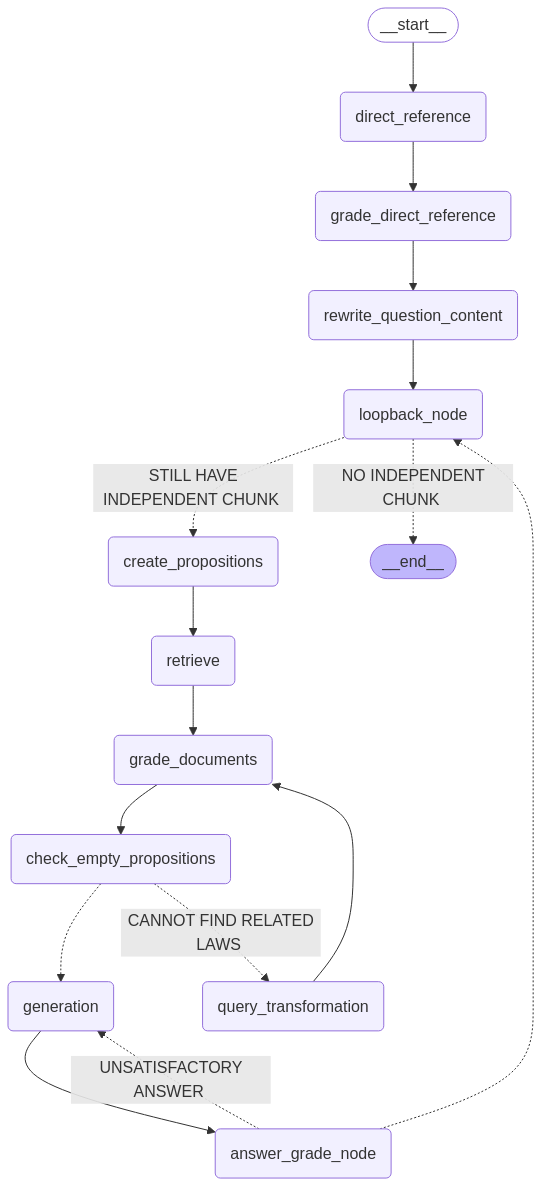

In [48]:
app

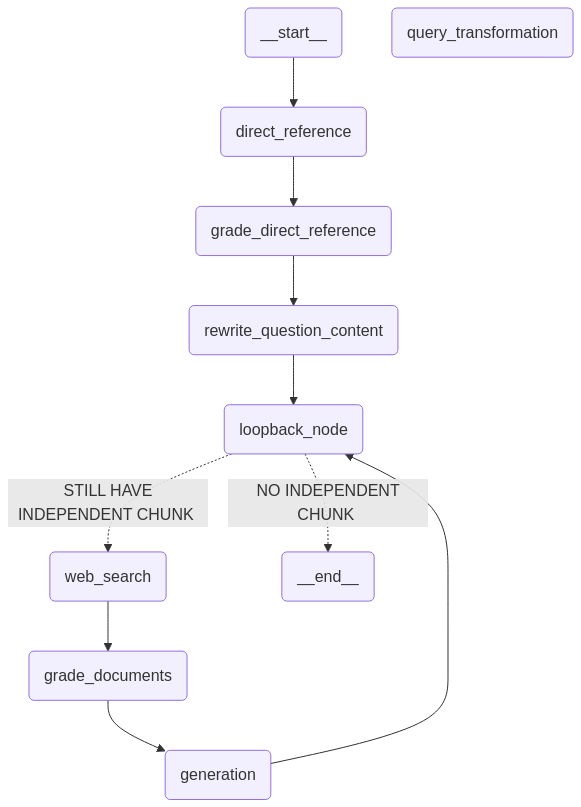

In [47]:
websearch_app

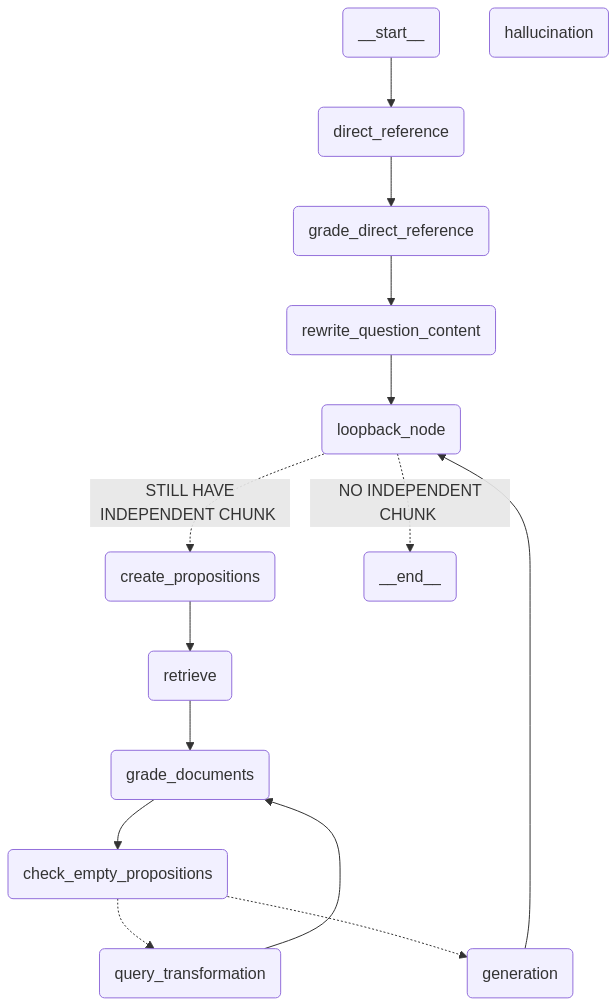

In [102]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        websearch_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Test Toàn bộ pipeline

In [ ]:
from langchain_core.runnables import RunnableConfig
import time
config = RunnableConfig(recursion_limit=200)

start_time = time.time()  # Bắt đầu đo thời gian
final_state = app.invoke(graph_state,config=config)
end_time = time.time()  # Kết thúc đo thời gian

print(f"Thời gian chạy: {end_time - start_time:.6f} giây")


---DIRECT REFERENCE---


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  7.94it/s, est. speed input: 4011.63 toks/s, output: 321.57 toks/s]


---GRADE REFERENCE---

                        "main_text": この規則は、本条第2項に規定するすべての労働者に適用する。また本規則における労働者とは本条第2項に規定するもののことを指す。,
                        "referenced_text": 第1章　総則 
 第2条（労働者の定義及び適用範囲）
 2．この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と比べ限定され雇用される労働者
                    
question_have_ref_count 17


Processed prompts:   0%|                                                                                                                                    | 0/187 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 03-12 06:03:55 scheduler.py:1560] Sequence group 4134 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101


Processed prompts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:27<00:00,  6.91it/s, est. speed input: 2597.71 toks/s, output: 521.78 toks/s]


question_have_ref_count 13
---REWRITE QUESTION CONTENT---


Processed prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.05it/s, est. speed input: 627.08 toks/s, output: 402.35 toks/s]


--- LOOPBACK NODE ---
direct count 58
ref count 0
STILL HAVE INDEPENDENT CHUNK
---CREATE PROPOSITIONS---
len(graph_state["current_question_index"]) 58
len(direct ) 58
len(ref ) 0
count 0


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.93it/s, est. speed input: 2056.40 toks/s, output: 423.15 toks/s]


---RETRIEVE---
---have retrieved for 160 propositions---
---GRADE DOCUMENTS---


Processed prompts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 640/640 [00:51<00:00, 12.31it/s, est. speed input: 5527.59 toks/s, output: 186.61 toks/s]


---have filtered and have 52 docs left---
---CHECK EMPTY PROPOSITIONS---
---121--- propositions that can not find documents
---QUERY TRANSFORMATION---


Processed prompts: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:42<00:00,  2.85it/s, est. speed input: 813.62 toks/s, output: 724.49 toks/s]


---trieve---
---new docs num: 400
---GRADE DOCUMENTS---


Processed prompts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:33<00:00, 13.25it/s, est. speed input: 5653.67 toks/s, output: 157.43 toks/s]


---have filtered and have 7 docs left---
---CHECK EMPTY PROPOSITIONS---
---114--- propositions that can not find documents
---GENERATE---
current_question_index [0, 1, 3, 4, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70]
start both
end both
start doc


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.66it/s, est. speed input: 2193.35 toks/s, output: 442.15 toks/s]


end doc
---HALLUCINATION GRADE---


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.24it/s, est. speed input: 3539.84 toks/s, output: 314.15 toks/s]


---GRADE ANSWER---


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.75it/s, est. speed input: 1652.90 toks/s, output: 359.39 toks/s]


---GENERATE---
current_question_index [0, 1, 3, 4, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70]
start both
end both
start doc


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.29it/s, est. speed input: 1944.35 toks/s, output: 402.79 toks/s]


end doc
---HALLUCINATION GRADE---


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.93it/s, est. speed input: 3253.68 toks/s, output: 290.45 toks/s]


---GRADE ANSWER---


Processed prompts:   7%|████████▋                                                                                                                 | 1/14 [00:00<00:11,  1.18it/s, est. speed input: 361.17 toks/s, output: 15.34 toks/s]

In [150]:
for index,question in enumerate(loaded_data["questions"]):
    print(f"""{index} {question["generation"]}""")

0 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
1 {'evaluation': 'compliance', 'explanation': 'この契約条項は、労基法その他の関連法令に従って就業に関する事項を扱うことを明記しており、その規定に従っているため、法的要件を満たしています。'}
2 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
3 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
4 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
5 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
6 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
7 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
8 {"evaluation":"insufficient_information",
                    "explanatio

In [147]:
for index,question in enumerate(final_state["questions"]):
    print(f"""{index} {question["generation"]}""")

0 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
1 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
2 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
3 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
4 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
5 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
6 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
7 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
8 {"evaluation":"insufficient_information",
                    "explanation":"C

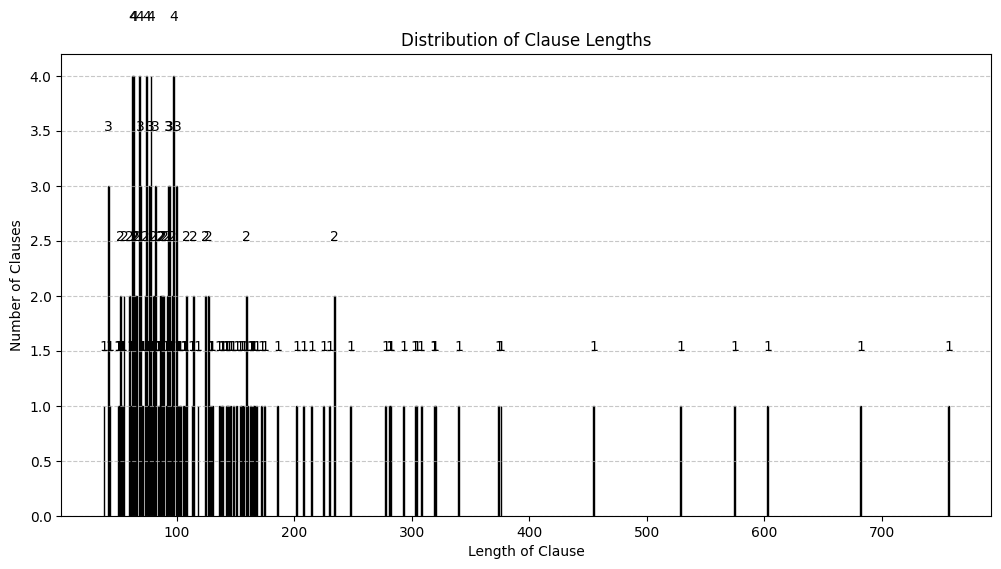

In [110]:
# for id, clause in final_state["root_text"]["clause"].items():
#     # print(id)
#     # if id == ('9','1'):
#     print(len(clause))
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Lấy độ dài của từng clause
clause_lengths = [len(clause) for clause in final_state["root_text"]["clause"].values()]

# Đếm số lượng clause theo độ dài
length_counts = Counter(clause_lengths)

# Chuyển dữ liệu thành mảng numpy để vẽ biểu đồ
x_values = np.array(list(length_counts.keys()))  # Độ dài của clause
y_values = np.array(list(length_counts.values()))  # Số lượng clause có độ dài đó

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(x_values, y_values, color="skyblue", edgecolor="black")

# Gắn nhãn trục
plt.xlabel("Length of Clause")
plt.ylabel("Number of Clauses")
plt.title("Distribution of Clause Lengths")

# Hiển thị giá trị trên các cột
for i in range(len(x_values)):
    plt.text(x_values[i], y_values[i] + 0.5, str(y_values[i]), ha="center", fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()



In [132]:
response_json = []

for question in final_state["questions"]:
    docs = []
    
    for direct_proposition in question["propositions"]:
        for doc in direct_proposition["filtered_documents"]:
            doc_dict = {
                "metadata": doc.metadata,
                "page_content": doc.page_content
            }
            if doc_dict not in docs:  # Tránh trùng lặp
                docs.append(doc_dict)

    for ref_proposition in question["ref_propositions"]:
        for doc in ref_proposition["filtered_documents"]:
            doc_dict = {
                "metadata": doc.metadata,
                "page_content": doc.page_content
            }
            if doc_dict not in docs:  # Tránh trùng lặp
                docs.append(doc_dict)
    
    response_json.append({
        "question": {
                "metadata": question["question_content"].metadata,
                "page_content": question["question_content"].page_content
            },
        "documents": docs,
        "response": json.loads(question["generation"]) if type(question["generation"])==str else question["generation"] 
    })


In [90]:
# Lưu JSON vào file
output_path = "/home/thanhnguyen/Data/code/RAG_techniques/output_3chapters.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(response_json, f, ensure_ascii=False, indent=4)

print(f"Đã lưu JSON vào: {output_path}")


Đã lưu JSON vào: /home/thanhnguyen/Data/code/RAG_techniques/output_3chapters.json


In [133]:
response_json

[{'question': {'metadata': {'chapter_title': '総則',
    'chapter_number': '1',
    'article_title': '目的',
    'article_number': '1',
    'clause_number': '1',
    'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。',
    'sub_clause_number': '',
    'sub_clause_content': ''},
   'page_content': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'},
  'documents': [{'metadata': {'article_name': '労働条件の決定',
     'article_number': '第二条',
     'chapter_name': '総則',
     'chapter_number': '第一章',
     'division_name': '',
     'division_number': '',
     'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049',
     'enactment_year': '令和6年5月31日 施行',
     'law_name': '労働基準法',
     'law_number': '昭和二十二年法律第四十九号'},
    'page_content': '昭和二十二年法律第四十九号\u3000労働基準法/第一章\u3000総則/第二条\u3000労働条件の決定/労働条件は、労働者と使用者が、対等の立場において決定すべきものである。\n労働者及び使用者は、労働協約、就業規則及び労働契約を遵守し、誠実に各々その義務を履行しなければならない。'}],
  'response': {'evaluation': 'compliance',
   'explanation': 'この契約条項は、労働者の就業に関する事項を定めるという目的

In [50]:
# import json

import pickle

# Lưu vào tệp
with open("/home/thanhnguyen/Data/code/RAG_techniques/output_3chapters.pkl", "wb") as f:
    pickle.dump(final_state, f)


In [149]:
# Đọc lại từ tệp
import pickle

with open("/home/thanhnguyen/Data/code/RAG_techniques/output_3chapters.pkl", "rb") as f:
    loaded_data = pickle.load(f)


# Test từng node

### separate chunks+ metadata

In [49]:
from docx import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
def convert_japanese_numbers(text):
    jp_numbers = "０１２３４５６７８９"

    latin_numbers = "0123456789"
    translation_table = str.maketrans(jp_numbers, latin_numbers)
    return text.translate(translation_table)

def get_list_number(paragraph):
    """Trích xuất số thứ tự của danh sách nếu có"""
    ns = {'w': 'http://schemas.openxmlformats.org/wordprocessingml/2006/main'}
    xml = paragraph._element
    numPr = xml.find('.//w:numPr', ns)
    
    if numPr is not None:
        numId = numPr.find('.//w:numId', ns)
        ilvl = numPr.find('.//w:ilvl', ns)
        
        if numId is not None and ilvl is not None:
            return f"{int(ilvl.get('{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val')) + 1}．"
    
    return ""

def extract_text_with_numbering(docx_path):
    """Trích xuất nội dung từ file .docx kèm theo số thứ tự danh sách"""
    doc = Document(docx_path)
    extracted_text = []

    for index,para in enumerate(doc.paragraphs):
        list_number = get_list_number(para)
        text = para.text.strip()
        # print(f"index {index} ")
        # print(f"para {para.text} ")
        if text:
            if list_number:
                extracted_text.append(f"{list_number} {text}")
            else:
                extracted_text.append(text)

    return '@'.join(extracted_text)


def circled_to_int(circled):
    # Bản đồ chuyển các ký hiệu số tròn sang số nguyên.
    mapping = {
    # Số 1 đến 20: ① (U+2460) -> ⑳ (U+2473)
    '①': "1",  '②': "2",  '③': "3",  '④': "4",  '⑤': "5",
    '⑥': "6",  '⑦': "7",  '⑧': "8",  '⑨': "9",  '⑩': "10",
    '⑪': "11", '⑫': "12", '⑬': "13", '⑭': "14", '⑮': "15",
    '⑯': "16", '⑰': "17", '⑱': "18", '⑲': "19", '⑳': "20",
    
    # Số 21 đến 35: ㉑ (U+3251) -> ㉟ (U+325F)
    '㉑': "21", '㉒': "22", '㉓': "23", '㉔': "24", '㉕': "25",
    '㉖': "26", '㉗': "27", '㉘': "28", '㉙': "29", '㉚': "30",
    '㉛': "31", '㉜': "32", '㉝': "33", '㉞': "34", '㉟': "35",
    
    # Số 36 đến 50: ㊱ (U+32B1) -> ㊿ (U+32BF)
    '㊱': "36", '㊲': "37", '㊳': "38", '㊴': "39", '㊵': "40",
    '㊶': "41", '㊷': "42", '㊸': "43", '㊹': "44", '㊺': "45",
    '㊻': "46", '㊼': "47", '㊽': "48", '㊾': "49", '㊿': "50",
}

    return mapping.get(circled, None)

def split_and_convert(text):
    pattern = r'@((?:[①-⑳]|[㉑-㉟]|[㊱-㊿]|\(\d+\)|（\d+）))(.*?)(?=@(?:[①-⑳]|[㉑-㉟]|[㊱-㊿]|\(\d+\)|（\d+）)|$)'
    matches = re.finditer(pattern, text, re.DOTALL)
    # print(f"text {text}")
    # print(f"""pre text '{text.split("①")[0]}'""")
    result = []
    for m in matches:
        marker = m.group(1).strip()  # Ký hiệu số (①, (2), （3）)
        content = m.group(2).strip()  # Nội dung tương ứng
        
        # Xử lý marker thành số nguyên
        if re.match(r'[（）()]\d+[（）()]', marker):  # Nếu là dạng (1) hoặc （1）
            number = marker.strip("（）()")  # Loại bỏ dấu ngoặc
        else:  # Nếu là dạng số tròn (①, ②, ...)
            number = circled_to_int(marker)

        result.append({"sub_clause_number": number, "sub_clause_content": content.replace("@","")})
    
    return result

def extract_structure(docx_path):
    # doc = Document(docx_path)
    # full_text = ' '.join([para.text.strip() for para in doc.paragraphs if para.text.strip()])
    full_text =extract_text_with_numbering(docx_path)
    full_text = convert_japanese_numbers(full_text)  # Nếu có hàm này
    full_text=full_text.replace(")","）")
    full_text=full_text.replace("(","（")
    # print(f"full text {full_text}")
    data = {"chapters": []}

    # Tìm tất cả chương với nội dung tương ứng
    chapters = re.finditer(r'第([0-9]+)章　(.*?)(?=第[0-9]+章　|\Z)', full_text, re.DOTALL)
    chapter_dict = {}
    article_dict = {}
    clause_dict = {}
    for chapter in chapters:
        chapter_num = chapter.group(1)
        chapter_title = chapter.group(2).strip().split('@')[0]
        chapter_content = chapter.group(0)
        # print(f"chapter_content {chapter_content}")
        # Tìm các điều trong chương
        articles = re.finditer(r'@第([0-9]+)条\s*（(.*?)）(.*?)(?=@第[0-9]+条\s*（|\Z)', chapter_content, re.DOTALL)
        articles_data = []
        for article in articles:
            article_num = article.group(1)
            # print(f"article_num {article_num}")
            article_title = article.group(2).strip()
            article_text = article.group(3).strip()
            # print(f"article_text {article_text}")
            article_contents = re.finditer(r'@([1-9]+)．(.*?)(?=@[1-9]．|\Z)', article_text, re.DOTALL)
            articles_content_data=[]
            
            for content in article_contents:
                article_content_num = content.group(1)
                article_content_text = content.group(2).strip()
                # print(article_content_text)
            # Tìm nội dung clause (bắt đầu bằng ①, ②, 1., - ...)
                clause_match = re.split(r'(@①|@1\.|@-|@（[0-9]+）)', article_content_text, maxsplit=1)
                # clause_match = re.split(r'(①|②|③|1\.|-|\([0-9]+\))', article_content_text, maxsplit=1, flags=re.MULTILINE)
                clause_text_temp=article_content_text
                parts=[]
                if len(clause_match) > 1:
                    article_content_text = clause_match[0].strip()  # Lấy phần trước danh sách
                    clause_content = ''.join(clause_match[1:]).strip()  # Lấy phần còn lại
                    
                    parts=split_and_convert(clause_content)

                else:
                    clause_content = ""
                # print(f"parts {parts}")
                articles_content_data.append({
                    "clause_number": article_content_num,
                    "clause_title": article_content_text,
                    # "clause_content": clause_content,
                    "sub_clauses":parts
                })
                clause_dict[(article_num,article_content_num)] ={
                    "chapter":f"""第{chapter_num.replace("@","")}章　{chapter_title.replace("@","")} \n """,
                    "article":f"""第{article_num.replace("@","")}条（{article_title.replace("@","")}）\n """,
                    "clause":f"""{article_content_num.replace("@","")}．""",
                    "sub_clause":"-1",
                    "text":f"""{clause_text_temp.replace("@","")}"""
                } 
            articles_data.append({
                    "article_number": article_num,
                    "article_title": article_title,
                    # "article_text":article_text,
                    "clauses": articles_content_data,
                    # "clause_content": clause_content
                })
            article_dict[article_num] = {
                "chapter":f"""第{chapter_num.replace("@","")}章　{chapter_title.replace("@","")} \n """,
                "article":f"""第{article_num.replace("@","")}条（{article_title.replace("@","")}）\n """,
                "clause":"-1",
                "sub_clause":"-1",
                "text":f"""{article_text.replace("@","")}"""
            }
            
            
        data["chapters"].append({
            "chapter_number": chapter_num,
            "chapter_title": chapter_title,
            # "chapter_text": chapter_content,
            "articles": articles_data
        })
    #     chapter_dict[chapter_num] =  f"""第{chapter_num}章　{chapter_title} \n{chapter_content}"""
        chapter_dict[chapter_num] =  {
                "chapter":f"""第{chapter_num.replace("@","")}章　{chapter_title.replace("@","")} \n """,
                "article":"-1",
                "clause":"-1",
                "sub_clause":"-1",
                "text":f"""{chapter.group(2).strip().split('@',1)[1].replace("@","")}"""
      
        } 
    root_text={"Chapter":chapter_dict, "Article":article_dict, "clause":clause_dict}
    
    return data,root_text

def save_json(data, output_path):
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

# Sử dụng
docx_path = '/home/thanhnguyen/Data/code/RAG_techniques/①就業規則_ひな形_20240513.docx'
json_path = '①就業規則_ひな形_20240513.json'

data,root_text = extract_structure(docx_path)
save_json(data, json_path)

normalized_data= my_utils.normalize_dict(data)
useful_data = {'chapters':normalized_data['chapters'][0:2]}

from langchain_core.documents import Document

docs_list = [
    Document(
        page_content=sub_clause.get("sub_clause_content") if sub_clause else clause["clause_title"],
        metadata={
            "chapter_title": chapter['chapter_title'].replace("@",""),
            "chapter_number": chapter['chapter_number'].replace("@",""),
            # "chapter_text": chapter['chapter_text'].replace("@",""),
            "article_title": article['article_title'].replace("@",""), 
            "article_number": article['article_number'].replace("@",""),
            # "article_text": article['article_text'].replace("@",""),
            "clause_number": clause['clause_number'].replace("@",""),
            "clause_title": clause["clause_title"].replace("@",""),
            # "clause_text": clause["clause_content"].replace("@",""),
            "sub_clause_number": sub_clause.get("sub_clause_number").replace("@","") if sub_clause else "",
            "sub_clause_content": sub_clause.get("sub_clause_content").replace("@","") if sub_clause else "",

            # "clause_content":  clause['clause_title']+"\n" if clause['clause_content'] else "",
            
        }
    )
    for chapter in useful_data['chapters'] 
    for article in chapter['articles']
    for clause in article['clauses']
    for sub_clause in (clause["sub_clauses"] or [None])  # Nếu rỗng thì tạo danh sách chứa None
]

docs_list
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=30
)

doc_splits = text_splitter.split_documents(docs_list)
for i, doc in enumerate(doc_splits):
    doc.metadata['chunk_id'] = i+1 ### adding chunk id

graph_state = {"questions":
            [
                {"question_content":Document(
                    page_content=doc_split.metadata['clause_title'] +"\n"+ doc_split.page_content if doc_split.metadata['sub_clause_content'] else doc_split.page_content,
                    metadata={
                        "chapter_title": doc_split.metadata['chapter_title'],
                        "chapter_number": doc_split.metadata['chapter_number'],
                        # "chapter_text": doc_split.metadata['chapter_text'],
                        "article_title": doc_split.metadata['article_title'], 
                        "article_number": doc_split.metadata['article_number'],
                        # "article_text": doc_split.metadata['article_text'],
                        "clause_number": doc_split.metadata['clause_number'],
                        "clause_title": doc_split.metadata['clause_title'],
                        # "clause_text": doc_split.metadata['clause_text'],
                        "sub_clause_number": doc_split.metadata['sub_clause_number'],
                        "sub_clause_content": doc_split.metadata['sub_clause_content'],
                    }),
                "propositions":[],
                "ref_propositions":[],
                }
 for doc_split in doc_splits],
                "root_text":root_text}

In [52]:
graph_state["root_text"]

{'Chapter': {'1': {'chapter': '第1章\u3000総則 \n ',
   'article': '-1',
   'clause': '-1',
   'sub_clause': '-1',
   'text': '第1条（目的）1．この就業規則（以下「規則」という。）は、株式会社●●●●の労働者の就業に関する事項を定めるものである。2．この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。第2条（労働者の定義及び適用範囲）1．この規則は、本条第2項に規定するすべての労働者に適用する。また本規則における労働者とは本条第2項に規定するもののことを指す。2．この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。①\u3000正社員・・・・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働者で期間の定めがなく雇用される基幹業務に従事する労働者②\u3000勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と比べ限定され雇用される労働者③\u3000職務限定社員・・・・契約社員・アルバイト以外の労働者で期間の定めがなく職務が正社員と比べ限定され雇用される労働者④\u3000短時間正社員・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働者で期間の定めがなくフルタイム勤務で働く正社員に比べ短い労働時間で雇用される労働者⑤\u3000無期契約社員・・・・正社員以外で無期労働契約により雇用される基幹業務の補助をする労働者⑥\u3000有期契約社員・・・・有期労働契約により雇用される基幹業務の補助をする労働者。原則1年ごとの更新とし、個別に定めるものとする。⑤\u3000嘱託社員・・・・・・定年退職後に引き続き有期労働契約により雇用される労働者。原則1年ごとの更新とし、個別に定めるものとする。⑥\u3000パート／アルバイト\u3000契約期間の有無にかかわらず、業務の一部や臨時的に業務を行う労働者⑦\u3000派遣社員・・・・・・派遣元事業所より派遣され、派遣元の指揮命令を受け就業する労働者3．パートタイマー、アルバイトに関しては本則第36条を適用せず、1カ月の労働時間が正社員と比べて短い契約を個別に定める4．派遣社

In [46]:
from langchain_core.runnables import RunnableConfig
config = RunnableConfig(recursion_limit=50)

In [47]:
final_state = app.invoke(graph_state,config=config)


---DIRECT REFERENCE---


Processed prompts: 100%|█| 110/110 [00:14<00:00,  7.41it/s, est. sp


---GRADE REFERENCE---


Processed prompts: 100%|█| 195/195 [00:27<00:00,  7.00it/s, est. sp


---REWRITE QUESTION CONTENT---


Processed prompts: 100%|█| 40/40 [00:15<00:00,  2.60it/s, est. spee


--- LOOPBACK NODE ---
direct count 77
ref count 0
STILL HAVE INDEPENDENT CHUNK
---CREATE PROPOSITIONS---
len(graph_state["current_question_index"]) 77
len(direct ) 77
len(ref ) 0
count 0


Processed prompts: 100%|█| 77/77 [00:13<00:00,  5.54it/s, est. spee


---RETRIEVE---
---have retrieved for 130 propositions---
---GRADE DOCUMENTS---


Processed prompts:  87%|▊| 1130/1300 [03:40<00:25,  6.55it/s, est. 

WARNING 03-05 10:38:42 scheduler.py:1560] Sequence group 2052 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=51


Processed prompts: 100%|█| 1300/1300 [04:00<00:00,  5.41it/s, est. 


---have filtered and have 17 docs left---
---CHECK EMPTY PROPOSITIONS---
---117--- propositions that can not find documents
---QUERY TRANSFORMATION---


Processed prompts: 100%|█| 117/117 [00:34<00:00,  3.44it/s, est. sp


Lỗi: Không thể parse JSON


Processed prompts: 100%|█| 1/1 [00:04<00:00,  4.20s/it, est. speed 


Retry 1/3: 0 cases left.
---trieve---
---new docs num: 604
---GRADE DOCUMENTS---


Processed prompts: 100%|█| 624/624 [01:58<00:00,  5.29it/s, est. sp


---have filtered and have 5 docs left---
---CHECK EMPTY PROPOSITIONS---
---112--- propositions that can not find documents
---GENERATE---
current_question_index [0, 1, 4, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 82, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 96, 98, 99, 109]
start both
end both
start doc


Processed prompts: 100%|█| 17/17 [00:05<00:00,  3.39it/s, est. spee


end doc
--- LOOPBACK NODE ---
direct count 0
ref count 27
STILL HAVE INDEPENDENT CHUNK
---CREATE PROPOSITIONS---
len(graph_state["current_question_index"]) 27
len(direct ) 0
len(ref ) 27
count 27


Processed prompts: 100%|█| 27/27 [00:08<00:00,  3.26it/s, est. spee


---RETRIEVE---
---have retrieved for 58 propositions---
---GRADE DOCUMENTS---


Processed prompts: 100%|█| 580/580 [01:47<00:00,  5.41it/s, est. sp


---have filtered and have 0 docs left---
---CHECK EMPTY PROPOSITIONS---
---58--- propositions that can not find documents
---QUERY TRANSFORMATION---


Processed prompts: 100%|█| 58/58 [00:35<00:00,  1.65it/s, est. spee


---trieve---
---new docs num: 338
---GRADE DOCUMENTS---


Processed prompts:   0%| | 0/348 [00:00<?, ?it/s, est. speed input:

WARNING 03-05 10:45:18 scheduler.py:1560] Sequence group 3630 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101


Processed prompts: 100%|█| 348/348 [01:09<00:00,  4.99it/s, est. sp


---have filtered and have 0 docs left---
---CHECK EMPTY PROPOSITIONS---
---58--- propositions that can not find documents
---GENERATE---
current_question_index [3, 5, 8, 11, 36, 37, 38, 39, 40, 41, 63, 75, 76, 77, 78, 79, 80, 81, 83, 89, 95, 97, 100, 101, 102, 103, 104]
start both
end both
start doc
end doc
--- LOOPBACK NODE ---
direct count 0
ref count 4
STILL HAVE INDEPENDENT CHUNK
---CREATE PROPOSITIONS---
len(graph_state["current_question_index"]) 4
len(direct ) 0
len(ref ) 5
count 4


Processed prompts: 100%|█| 5/5 [00:03<00:00,  1.29it/s, est. speed 


---RETRIEVE---
---have retrieved for 19 propositions---
---GRADE DOCUMENTS---


Processed prompts: 100%|█| 190/190 [00:34<00:00,  5.57it/s, est. sp


---have filtered and have 0 docs left---
---CHECK EMPTY PROPOSITIONS---
---19--- propositions that can not find documents
---QUERY TRANSFORMATION---


Processed prompts: 100%|█| 19/19 [00:08<00:00,  2.18it/s, est. spee


---trieve---
---new docs num: 161
---GRADE DOCUMENTS---


Processed prompts: 100%|█| 161/161 [00:30<00:00,  5.24it/s, est. sp


---have filtered and have 0 docs left---
---CHECK EMPTY PROPOSITIONS---
---19--- propositions that can not find documents
---GENERATE---
current_question_index [10, 105, 106, 107]
start both
end both
start doc
end doc
--- LOOPBACK NODE ---
direct count 0
ref count 2
STILL HAVE INDEPENDENT CHUNK
---CREATE PROPOSITIONS---
len(graph_state["current_question_index"]) 2
len(direct ) 0
len(ref ) 8
count 2


Processed prompts: 100%|█| 8/8 [00:03<00:00,  2.32it/s, est. speed 


---RETRIEVE---
---have retrieved for 7 propositions---
---GRADE DOCUMENTS---


Processed prompts: 100%|█| 70/70 [00:13<00:00,  5.09it/s, est. spee


---have filtered and have 0 docs left---
---CHECK EMPTY PROPOSITIONS---
---7--- propositions that can not find documents
---QUERY TRANSFORMATION---


Processed prompts: 100%|█| 7/7 [00:04<00:00,  1.66it/s, est. speed 


---trieve---
---new docs num: 52
---GRADE DOCUMENTS---


Processed prompts: 100%|█| 52/52 [00:10<00:00,  4.77it/s, est. spee


---have filtered and have 0 docs left---
---CHECK EMPTY PROPOSITIONS---
---7--- propositions that can not find documents
---GENERATE---
current_question_index [2, 108]
start both
end both
start doc
end doc
--- LOOPBACK NODE ---
direct count 0
ref count 0
NO INDEPENDENT CHUNK


In [49]:
count=0
for question in final_state["questions"]:
    if question.get("generation", "") != "":
        count+=1
        print(question['generation'])
print(f"amount of processed question: {count}")

{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{'evaluation': 'compliance', 'explanation': 'この契約条項は、労基法その他の関連法令に基づいて就業に関する事項を定めているため、関連する法律規定に従っていると判断されます。'}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEV

### direct Reference

In [178]:
# Test =deepcopy(graph_state)
# Test["questions"]=[{'question_content': Document(metadata={'chapter_title': '労働時間', 'chapter_number': '3', 'article_title': '労働時間の定義', 'article_number': '10', 'clause_number': '1', 'clause_title': 'この規則で労働時間とは、従業員が業務に従事する時間を指し、次の通り定義する。', 'sub_clause_number': '3', 'sub_clause_content': '所定労働時間・・・・・・1日8時間、1週間40時間を超えない範囲とする。'}, page_content='この規則で労働時間とは、従業員が業務に従事する時間を指し、次の通り定義する。\n所定労働時間・・・・・・1日8時間、1週間40時間を超えない範囲とする。'),
#    'propositions': [],
#    'ref_propositions': [],
#    'direct_reference': [],
#    'direct_reference_index': [],
#    'direct_reference_text': [],
#    'ref_reference': [],}
# ]

In [50]:
reference_graph_state=direct_reference(graph_state)
# reference_Test=direct_reference(Test)

---DIRECT REFERENCE---


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.03it/s, est. speed input: 4061.31 toks/s, output: 325.32 toks/s]


In [ ]:
# count = 0
# for question in reference_graph_state['questions']:
#     if question["direct_reference"] != []:
#         count+=1
# print(f"count {count}")

In [70]:
reference_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': []},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': [],
   'ref_propositions': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': []},
  {'question_conten

In [201]:
reference_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': []},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': [],
   'ref_propositions': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': []},
  {'question_conten

### grade reference

In [104]:
# count = 0
# for question in grade_direct_reference_graph_state["questions"]:
#     if question["direct_reference_text"]:
#         print(len(question["merged_reference_text"]))
#         count+=1
# print(f"count {count}")
#         # count_graded_text=0
#         # for ref_text in question["direct_reference_text"]:
#             # count_graded_text+=len(ref_text["text"])
#         # print(count_graded_text)
#         # if count_graded_text==901:
#             # print(question)
# # print(count)


744
66
98
127
66
324
324
324
324
324
324
69
219
219
165
165
219
165
165
119
91
64
77
77
77
77
77
190
190
190
107
count 31


In [51]:
grade_direct_reference_graph_state=grade_direct_reference(reference_graph_state)
# grade_direct_reference_Test=grade_direct_reference(reference_Test)

---GRADE REFERENCE---

                        "main_text": この規則は、本条第2項に規定するすべての労働者に適用する。また本規則における労働者とは本条第2項に規定するもののことを指す。,
                        "referenced_text": 第1章　総則 
 第2条（労働者の定義及び適用範囲）
 2．この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と比べ限定され雇用される労働者
                    
question_have_ref_count 17


Processed prompts:   0%|                                                                                                                                    | 0/187 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 03-12 04:55:50 scheduler.py:1560] Sequence group 266 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.14it/s, est. speed input: 2683.72 toks/s, output: 531.26 toks/s]

question_have_ref_count 14


In [98]:
grade_direct_reference_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': []},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': [],
   'ref_propositions': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': []},
  {'question_conten

In [92]:
print("""第1章\u3000総則 \n \n  第2条（労働者の定義及び適用範囲）\n \n    2．\n      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\n短時間正社員・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働@者で期間の定めがなくフルタイム勤務で働く正社員に比べ短い労働時間で@雇用される労働者\n        + \n      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\nパート/アルバイト 契約期間の有無にかかわらず、業務の一部や臨時的に業務を行う労働者\n        + \n      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\n派遣社員・・・・・・派遣元事業所より派遣され、派遣元の指揮命令を受け就業する労働者\n        + \n      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\n嘱託社員・・・・・・定年退職後に引き続き有期労働契約により雇用される労働者。原則1年ご@との更新とし、個別に定めるものとする。\n        + \n      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\n勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と@比べ限定され雇用される労働者\n        + \n      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\n職務限定社員・・・・契約社員・アルバイト以外の労働者で期間の定めがなく職務が正社員と比@べ限定され雇用される労働者\n        + \n      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\n正社員・・・・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働@者で期間の定めがなく雇用される基幹業務に従事する労働者\n        + '},
""")

第1章　総則 
 
  第2条（労働者の定義及び適用範囲）
 
    2．
      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
短時間正社員・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働@者で期間の定めがなくフルタイム勤務で働く正社員に比べ短い労働時間で@雇用される労働者
        + 
      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
パート/アルバイト 契約期間の有無にかかわらず、業務の一部や臨時的に業務を行う労働者
        + 
      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
派遣社員・・・・・・派遣元事業所より派遣され、派遣元の指揮命令を受け就業する労働者
        + 
      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
嘱託社員・・・・・・定年退職後に引き続き有期労働契約により雇用される労働者。原則1年ご@との更新とし、個別に定めるものとする。
        + 
      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と@比べ限定され雇用される労働者
        + 
      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
職務限定社員・・・・契約社員・アルバイト以外の労働者で期間の定めがなく職務が正社員と比@べ限定され雇用される労働者
        + 
      この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
正社員・・・・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働@者で期間の定めがなく雇用される基幹業務に従事する労働者
        + '},



In [158]:
len(grade_direct_reference_graph_state["questions"])

110

### Rewrite

In [52]:
rewrite_graph_state=rewrite_question_content(grade_direct_reference_graph_state)
# rewrite_Test=rewrite_question_content(grade_direct_reference_Test)

---REWRITE QUESTION CONTENT---


Processed prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.17it/s, est. speed input: 652.07 toks/s, output: 376.79 toks/s]


In [107]:
rewrite_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': [],
   'merged_reference_text': '',
   'rewrite_question_content': ''},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': [],
   'ref_propositions': [],
   'direct_reference': [],
   'direct_referen

In [159]:
len(rewrite_graph_state["questions"])


110

### loopback

In [53]:
loopback_graph_state=loopback_node(rewrite_graph_state)
# loopback_Test=loopback_node(rewrite_Test)

--- LOOPBACK NODE ---
direct count 57
ref count 0


In [245]:
loopback_graph_state["question_to_regen_index"]

[]

In [109]:
len(loopback_graph_state["current_question_index"])

80

In [161]:
len(loopback_graph_state["questions"])

110

### Create propositions

In [54]:
should_create_proposition(loopback_graph_state)
# should_create_proposition(loopback_Test)

STILL HAVE INDEPENDENT CHUNK


'STILL HAVE INDEPENDENT CHUNK'

In [54]:
create_propositions_graph_state = create_propositions(loopback_graph_state)
# create_propositions_Test = create_propositions(loopback_Test)

---CREATE PROPOSITIONS---
len(graph_state["current_question_index"]) 57
len(direct ) 57
len(ref ) 0
count 0


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:11<00:00,  4.90it/s, est. speed input: 2043.68 toks/s, output: 413.08 toks/s]


In [203]:
create_propositions_graph_state["current_question_index"]

[0,
 1,
 4,
 5,
 6,
 7,
 9,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 82,
 84,
 85,
 86,
 87,
 88,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 98,
 99,
 109]

### Retrieve

In [55]:
retrieve_graph_state=retrieve(create_propositions_graph_state)
# retrieve_Test=retrieve(create_propositions_Test)

---RETRIEVE---
---have retrieved for 154 propositions---


In [59]:
retrieve_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [{'proposition_content': 'この就業規則は、株式会社●●●●の労働者の就業に関する事項を定めるものである。',
     'documents': [Document(metadata={'article_name': '労働者の安全への配慮', 'article_number': '第五条', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, page_content='平成十九年法律第百二十八号\u3000労働契約法/第一章\u3000総則/第五条\u3000労働者の安全への配慮/使用者は、労働契約に伴い、労働者がその生命、身体等の安全を確保しつつ労働することができるよう、必要な配慮をするものとする。'),
      Document(metadata={'article_name': '労働契約との関係', 'article_number': '第九十三条',

### grade_documents

In [186]:
retrieve_graph_state["questions"][0]

{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
 'propositions': [{'proposition_content': 'この就業規則は、株式会社●●●●の労働者の就業に関する事項を定めるものである。',
   'documents': [Document(metadata={'article_name': '労働者の安全への配慮', 'article_number': '第五条', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, page_content='平成十九年法律第百二十八号\u3000労働契約法/第一章\u3000総則/第五条\u3000労働者の安全への配慮/使用者は、労働契約に伴い、労働者がその生命、身体等の安全を確保しつつ労働することができるよう、必要な配慮をするものとする。'),
    Document(metadata={'article_name': '労働契約との関係', 'article_number': '第九十三条', 'chapter_name': '就業規

In [56]:
grade_documents_graph_state = grade_documents(retrieve_graph_state)
# grade_documents_Test = grade_documents(retrieve_Test)


---GRADE DOCUMENTS---


Processed prompts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:50<00:00, 12.25it/s, est. speed input: 5551.38 toks/s, output: 182.25 toks/s]


---have filtered and have 55 docs left---


In [69]:
grade_documents_graph_state["questions"][0]["propositions"][0]

{'proposition_content': 'この就業規則は、株式会社●●●●の労働者の就業に関する事項を定めるものである。',
 'documents': [Document(metadata={'article_name': '労働者の安全への配慮', 'article_number': '第五条', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, page_content='平成十九年法律第百二十八号\u3000労働契約法/第一章\u3000総則/第五条\u3000労働者の安全への配慮/使用者は、労働契約に伴い、労働者がその生命、身体等の安全を確保しつつ労働することができるよう、必要な配慮をするものとする。'),
  Document(metadata={'article_name': '労働契約との関係', 'article_number': '第九十三条', 'chapter_name': '就業規則', 'chapter_number': '第九章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049', 'enactment_year': '令和6年5月31日 施行', 'law_name': '労働基準法', 'law_number': '昭和二十二年法律第四十九号'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第九章\u3000就業規則/第九十三条\u3000労働契約との関係/労働契約と就業規則との関係については、労働契約法（平成十九年法律第百二十八号）第十二条の定めるところによる。'),
  Document

In [204]:
grade_documents_graph_state["rewrite_count"]

0

### check_empty_propositions

In [57]:
check_empty_graph_state=check_empty_propositions(grade_documents_graph_state)

---CHECK EMPTY PROPOSITIONS---
---115--- propositions that can not find documents


In [97]:
check_empty_graph_state["rewrite_count"]

0

### query transformation

In [58]:
query_transformation_graph_state=query_transformation(check_empty_graph_state)

---QUERY TRANSFORMATION---


Processed prompts: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:41<00:00,  2.77it/s, est. speed input: 794.68 toks/s, output: 706.44 toks/s]


---trieve---
---new docs num: 420


In [ ]:
query_transformation_graph_state

### Grade_document again

In [59]:
grade_documents_graph_state_again = grade_documents(query_transformation_graph_state)


---GRADE DOCUMENTS---


Processed prompts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [00:33<00:00, 13.02it/s, est. speed input: 5571.82 toks/s, output: 159.31 toks/s]


---have filtered and have 9 docs left---


In [ ]:
grade_documents_graph_state2

### check empty proposition again

In [60]:
check_empty_graph_state_again=check_empty_propositions(grade_documents_graph_state_again)

---CHECK EMPTY PROPOSITIONS---
---106--- propositions that can not find documents


### Generation

In [61]:
generate_graph_state=generate(check_empty_graph_state_again)

---GENERATE---
current_question_index [0, 1, 5, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70]
start both
end both
start doc


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.60it/s, est. speed input: 2212.67 toks/s, output: 424.11 toks/s]

end doc


In [224]:
count=0
for question in generate_graph_state["questions"]:
    if question.get("generation", "") != "":
        count+=1
        print(question['generation'])
print(f"amount of processed question: {count}")

{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{'evaluation': 'insufficient_information', 'explanation': '与えられた法律条文は、労働基準法に関するものであると推測されますが、具体的な内容が不明瞭です。また、契約条項自体も労働者の定義と適用範囲について述べていますが、具体的な労働基準法の条文との整合性を確認するためには、労働基準法の具体的な条文が必要です。そのため、与えられた情報だけでは、契約条項が労働基準法に適合しているかどうかを判断するのに十分な情報が不足しています。'}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{'evaluation': 'insufficient_information', 'explanation': '与えられた契約条項には、労働基準法第24条第1項に基づく労働時間の定義が明確に示されていません。また、短時間正社員の具体的な労働時間や労働条件が規定されていないため、法的要件を満たしているかどうか判断できません。'}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{'evaluation': 'insufficient_information', 'explanation': '提供された契約条項には、嘱託社員が定年退職後に有期労働契約により雇用されることや、原則として1年ごとの契約更新が行われることなどが記載されていますが、

### grade answer

In [62]:
grade_answer_graph_state = answer_grade_node(generate_graph_state)

---HALLUCINATION GRADE---


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.18it/s, est. speed input: 3528.13 toks/s, output: 304.23 toks/s]


---GRADE ANSWER---


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.36it/s, est. speed input: 1560.91 toks/s, output: 412.83 toks/s]


In [122]:
print( 1 in generate_graph_state["question_to_regen_index"])

False


### check_answer

In [63]:
check_answer(grade_answer_graph_state)

'UNSATISFACTORY ANSWER'

### Generation again

In [64]:
generate_graph_state_again=generate(grade_answer_graph_state)

---GENERATE---
current_question_index [0, 1, 5, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70]
start both
end both
start doc


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.06it/s, est. speed input: 1874.53 toks/s, output: 390.94 toks/s]

end doc


### grade answer again

In [65]:
grade_answer_graph_state_again=generate(generate_graph_state_again)

---GENERATE---
current_question_index [0, 1, 5, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70]
start both
end both
start doc


Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.60it/s, est. speed input: 2203.82 toks/s, output: 416.94 toks/s]

end doc


### Loopback2

In [229]:
loopback2_graph_state = loopback_node(generate_graph_state)

--- LOOPBACK NODE ---
direct count 0
ref count 26


### should_create_proposition 2

In [230]:
should_create_proposition(loopback2_graph_state)

STILL HAVE INDEPENDENT CHUNK


'STILL HAVE INDEPENDENT CHUNK'

### create_propositions2

In [232]:
create_propositions_graph_state2= create_propositions(loopback2_graph_state)

---CREATE PROPOSITIONS---
len(graph_state["current_question_index"]) 26
len(direct ) 0
len(ref ) 29
count 26


Processed prompts: 100%|████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s, est. speed input: 1465.54 toks/s, output: 434.88 toks/s]


### retrieve2

In [258]:
retrieve_graph_state2=retrieve(create_propositions_graph_state2)

---RETRIEVE---
---have retrieved for 60 propositions---


In [260]:
retrieve_graph_state2["questions"][10]

{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '労働者の定義及び適用範囲', 'article_number': '2', 'clause_number': '2', 'clause_title': 'この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。', 'sub_clause_number': '6', 'sub_clause_content': 'パート/アルバイト 契約期間の有無にかかわらず、業務の一部や臨時的に業務を行う労働者'}, page_content='この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\nパート/アルバイト 契約期間の有無にかかわらず、業務の一部や臨時的に業務を行う労働者'),
 'propositions': [],
 'ref_propositions': [{'proposition_content': '労働者とは、会社が選考試験を行い、これに合格した者を採用するという手続きを経て入社した者を指す。',
   'documents': [Document(metadata={'article_name': '定義', 'article_number': '第二条', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, page_content='平成十九年法律第百二十八号\u3000労働契約法/第一章\u3000総則/第二条\u3000定義/この法律において「労働者」とは、使用者に使用されて労働し、賃金を支払われる者をいう。\nこの法律において「使用者」とは、その使用する労働者に対し

### grade documents 2

In [262]:
grade_documents_graph_state2 = grade_documents(retrieve_graph_state2)

---GRADE DOCUMENTS---
zoooooo
len propositions 0
len ref propositions 2
---------{'proposition_content': '労働者とは、会社が採用時の賃金、就業場所、従事する業務、労働時間、休日、その他の労働条件を記した労働条件通知書または雇用契約書、及びこの規則を交付して労働条件を明示する手続きにより入社した者を指す。', 'documents': [Document(metadata={'article_name': '定義', 'article_number': '第二条', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, page_content='平成十九年法律第百二十八号\u3000労働契約法/第一章\u3000総則/第二条\u3000定義/この法律において「労働者」とは、使用者に使用されて労働し、賃金を支払われる者をいう。\nこの法律において「使用者」とは、その使用する労働者に対して賃金を支払う者をいう。'), Document(metadata={'article_name': '定義', 'article_number': '第九条', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049', 'enactment_year': '令和6年5月31日 施行', 'law_name': '労働基準法', 'law_number': '昭和二十二年法律第四十九号'}, page_c

Processed prompts:   0%|                                                     | 0/600 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 03-05 07:17:06 scheduler.py:1560] Sequence group 20640 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=751


Processed prompts: 100%|██████████████████████████████████████| 600/600 [01:58<00:00,  5.04it/s, est. speed input: 2030.30 toks/s, output: 504.44 toks/s]


---have filtered and have 0 docs left---


### check_empty_propositions2

In [264]:
check_empty_propositions_graph_state2= check_empty_propositions(grade_documents_graph_state2)

---CHECK EMPTY PROPOSITIONS---
---60--- propositions that can not find documents


### query_transformation2

In [282]:
query_transformation_graph_state2 =query_transformation(check_empty_propositions_graph_state2) 

---QUERY TRANSFORMATION---


Processed prompts: 100%|█████████████████████████████████████████| 60/60 [00:39<00:00,  1.52it/s, est. speed input: 434.89 toks/s, output: 436.82 toks/s]


---trieve---
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
p_idx -1
---new docs num: 381


### grade_document 2 again 

In [283]:
grade_documents_graph_state2_again = grade_documents(query_transformation_graph_state2)

---GRADE DOCUMENTS---


Processed prompts: 100%|██████████████████████████████████████| 381/381 [01:18<00:00,  4.83it/s, est. speed input: 2301.76 toks/s, output: 484.60 toks/s]


---have filtered and have 0 docs left---


### check_empty_propositions 2 again

In [286]:
check_empty_propositions_graph_state2_again = check_empty_propositions(grade_documents_graph_state2_again)

---CHECK EMPTY PROPOSITIONS---
---60--- propositions that can not find documents


### generate 2

In [290]:
generate_graph_state2 = generate(check_empty_propositions_graph_state2_again)

---GENERATE---
current_question_index [3, 8, 10, 11, 36, 37, 38, 39, 40, 41, 63, 75, 76, 77, 78, 79, 80, 81, 83, 89, 97, 100, 101, 102, 103, 104]
start both
end both
start doc
end doc


In [47]:
count=0
for question in final_state["questions"]:
    if question.get("generation", "") != "":
        count+=1
        print(question['generation'])
print(f"amount of processed question: {count}")

{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
{"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY REL

### Loopback3

In [294]:
loopback_node_graph_state3 =loopback_node(generate_graph_state2)

--- LOOPBACK NODE ---
direct count 0
ref count 4


# Test từng node websearch

## separate chunks + metadata

In [54]:
from docx import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
def convert_japanese_numbers(text):
    jp_numbers = "０１２３４５６７８９"

    latin_numbers = "0123456789"
    translation_table = str.maketrans(jp_numbers, latin_numbers)
    return text.translate(translation_table)

def get_list_number(paragraph):
    """Trích xuất số thứ tự của danh sách nếu có"""
    ns = {'w': 'http://schemas.openxmlformats.org/wordprocessingml/2006/main'}
    xml = paragraph._element
    numPr = xml.find('.//w:numPr', ns)
    
    if numPr is not None:
        numId = numPr.find('.//w:numId', ns)
        ilvl = numPr.find('.//w:ilvl', ns)
        
        if numId is not None and ilvl is not None:
            return f"{int(ilvl.get('{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val')) + 1}．"
    
    return ""

def extract_text_with_numbering(docx_path):
    """Trích xuất nội dung từ file .docx kèm theo số thứ tự danh sách"""
    doc = Document(docx_path)
    extracted_text = []

    for index,para in enumerate(doc.paragraphs):
        list_number = get_list_number(para)
        text = para.text.strip()
        # print(f"index {index} ")
        # print(f"para {para.text} ")
        if text:
            if list_number:
                extracted_text.append(f"{list_number} {text}")
            else:
                extracted_text.append(text)

    return '@'.join(extracted_text)


def circled_to_int(circled):
    # Bản đồ chuyển các ký hiệu số tròn sang số nguyên.
    mapping = {
    # Số 1 đến 20: ① (U+2460) -> ⑳ (U+2473)
    '①': "1",  '②': "2",  '③': "3",  '④': "4",  '⑤': "5",
    '⑥': "6",  '⑦': "7",  '⑧': "8",  '⑨': "9",  '⑩': "10",
    '⑪': "11", '⑫': "12", '⑬': "13", '⑭': "14", '⑮': "15",
    '⑯': "16", '⑰': "17", '⑱': "18", '⑲': "19", '⑳': "20",
    
    # Số 21 đến 35: ㉑ (U+3251) -> ㉟ (U+325F)
    '㉑': "21", '㉒': "22", '㉓': "23", '㉔': "24", '㉕': "25",
    '㉖': "26", '㉗': "27", '㉘': "28", '㉙': "29", '㉚': "30",
    '㉛': "31", '㉜': "32", '㉝': "33", '㉞': "34", '㉟': "35",
    
    # Số 36 đến 50: ㊱ (U+32B1) -> ㊿ (U+32BF)
    '㊱': "36", '㊲': "37", '㊳': "38", '㊴': "39", '㊵': "40",
    '㊶': "41", '㊷': "42", '㊸': "43", '㊹': "44", '㊺': "45",
    '㊻': "46", '㊼': "47", '㊽': "48", '㊾': "49", '㊿': "50",
}

    return mapping.get(circled, None)

def split_and_convert(text):
    pattern = r'@((?:[①-⑳]|[㉑-㉟]|[㊱-㊿]|\(\d+\)|（\d+）))(.*?)(?=@(?:[①-⑳]|[㉑-㉟]|[㊱-㊿]|\(\d+\)|（\d+）)|$)'
    matches = re.finditer(pattern, text, re.DOTALL)
    # print(f"text {text}")
    # print(f"""pre text '{text.split("①")[0]}'""")
    result = []
    for m in matches:
        marker = m.group(1).strip()  # Ký hiệu số (①, (2), （3）)
        content = m.group(2).strip()  # Nội dung tương ứng
        
        # Xử lý marker thành số nguyên
        if re.match(r'[（）()]\d+[（）()]', marker):  # Nếu là dạng (1) hoặc （1）
            number = marker.strip("（）()")  # Loại bỏ dấu ngoặc
        else:  # Nếu là dạng số tròn (①, ②, ...)
            number = circled_to_int(marker)

        result.append({"sub_clause_number": number, "sub_clause_content": content.replace("@","")})
    
    return result

def extract_structure(docx_path):
    # doc = Document(docx_path)
    # full_text = ' '.join([para.text.strip() for para in doc.paragraphs if para.text.strip()])
    full_text =extract_text_with_numbering(docx_path)
    full_text = convert_japanese_numbers(full_text)  # Nếu có hàm này
    full_text=full_text.replace(")","）")
    full_text=full_text.replace("(","（")
    # print(f"full text {full_text}")
    data = {"chapters": []}

    # Tìm tất cả chương với nội dung tương ứng
    chapters = re.finditer(r'第([0-9]+)章　(.*?)(?=第[0-9]+章　|\Z)', full_text, re.DOTALL)
    chapter_dict = {}
    article_dict = {}
    clause_dict = {}
    for chapter in chapters:
        chapter_num = chapter.group(1)
        chapter_title = chapter.group(2).strip().split('@')[0]
        chapter_content = chapter.group(0)
        # print(f"chapter_content {chapter_content}")
        # Tìm các điều trong chương
        articles = re.finditer(r'@第([0-9]+)条\s*（(.*?)）(.*?)(?=@第[0-9]+条\s*（|\Z)', chapter_content, re.DOTALL)
        articles_data = []
        for article in articles:
            article_num = article.group(1)
            # print(f"article_num {article_num}")
            article_title = article.group(2).strip()
            article_text = article.group(3).strip()
            # print(f"article_text {article_text}")
            article_contents = re.finditer(r'@([1-9]+)．(.*?)(?=@[1-9]．|\Z)', article_text, re.DOTALL)
            articles_content_data=[]
            
            for content in article_contents:
                article_content_num = content.group(1)
                article_content_text = content.group(2).strip()
                # print(article_content_text)
            # Tìm nội dung clause (bắt đầu bằng ①, ②, 1., - ...)
                clause_match = re.split(r'(@①|@1\.|@-|@（[0-9]+）)', article_content_text, maxsplit=1)
                # clause_match = re.split(r'(①|②|③|1\.|-|\([0-9]+\))', article_content_text, maxsplit=1, flags=re.MULTILINE)
                clause_text_temp=article_content_text
                parts=[]
                if len(clause_match) > 1:
                    article_content_text = clause_match[0].strip()  # Lấy phần trước danh sách
                    clause_content = ''.join(clause_match[1:]).strip()  # Lấy phần còn lại
                    
                    parts=split_and_convert(clause_content)

                else:
                    clause_content = ""
                # print(f"parts {parts}")
                articles_content_data.append({
                    "clause_number": article_content_num,
                    "clause_title": article_content_text,
                    # "clause_content": clause_content,
                    "sub_clauses":parts
                })
                clause_dict[(article_num,article_content_num)] ={
                    "chapter":f"""第{chapter_num.replace("@","")}章　{chapter_title.replace("@","")} \n """,
                    "article":f"""第{article_num.replace("@","")}条（{article_title.replace("@","")}）\n """,
                    "clause":f"""{article_content_num.replace("@","")}．""",
                    "sub_clause":"-1",
                    "text":f"""{clause_text_temp.replace("@","")}"""
                } 
            articles_data.append({
                    "article_number": article_num,
                    "article_title": article_title,
                    # "article_text":article_text,
                    "clauses": articles_content_data,
                    # "clause_content": clause_content
                })
            article_dict[article_num] = {
                "chapter":f"""第{chapter_num.replace("@","")}章　{chapter_title.replace("@","")} \n """,
                "article":f"""第{article_num.replace("@","")}条（{article_title.replace("@","")}）\n """,
                "clause":"-1",
                "sub_clause":"-1",
                "text":f"""{article_text.replace("@","")}"""
            }
            
            
        data["chapters"].append({
            "chapter_number": chapter_num,
            "chapter_title": chapter_title,
            # "chapter_text": chapter_content,
            "articles": articles_data
        })
    #     chapter_dict[chapter_num] =  f"""第{chapter_num}章　{chapter_title} \n{chapter_content}"""
        chapter_dict[chapter_num] =  {
                "chapter":f"""第{chapter_num.replace("@","")}章　{chapter_title.replace("@","")} \n """,
                "article":"-1",
                "clause":"-1",
                "sub_clause":"-1",
                "text":f"""{chapter.group(2).strip().split('@',1)[1].replace("@","")}"""
      
        } 
    root_text={"Chapter":chapter_dict, "Article":article_dict, "clause":clause_dict}
    
    return data,root_text

def save_json(data, output_path):
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

# Sử dụng
docx_path = '/home/thanhnguyen/Data/code/RAG_techniques/①就業規則_ひな形_20240513.docx'
json_path = '①就業規則_ひな形_20240513.json'

data,root_text = extract_structure(docx_path)
save_json(data, json_path)

normalized_data= my_utils.normalize_dict(data)
useful_data = {'chapters':normalized_data['chapters'][0:2]}

from langchain_core.documents import Document

docs_list = [
    Document(
        page_content=sub_clause.get("sub_clause_content") if sub_clause else clause["clause_title"],
        metadata={
            "chapter_title": chapter['chapter_title'].replace("@",""),
            "chapter_number": chapter['chapter_number'].replace("@",""),
            # "chapter_text": chapter['chapter_text'].replace("@",""),
            "article_title": article['article_title'].replace("@",""), 
            "article_number": article['article_number'].replace("@",""),
            # "article_text": article['article_text'].replace("@",""),
            "clause_number": clause['clause_number'].replace("@",""),
            "clause_title": clause["clause_title"].replace("@",""),
            # "clause_text": clause["clause_content"].replace("@",""),
            "sub_clause_number": sub_clause.get("sub_clause_number").replace("@","") if sub_clause else "",
            "sub_clause_content": sub_clause.get("sub_clause_content").replace("@","") if sub_clause else "",

            # "clause_content":  clause['clause_title']+"\n" if clause['clause_content'] else "",
            
        }
    )
    for chapter in useful_data['chapters'] 
    for article in chapter['articles']
    for clause in article['clauses']
    for sub_clause in (clause["sub_clauses"] or [None])  # Nếu rỗng thì tạo danh sách chứa None
]

docs_list
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=30
)

doc_splits = text_splitter.split_documents(docs_list)
for i, doc in enumerate(doc_splits):
    doc.metadata['chunk_id'] = i+1 ### adding chunk id

graph_state = {"questions":
            [
                {"question_content":Document(
                    page_content=doc_split.metadata['clause_title'] +"\n"+ doc_split.page_content if doc_split.metadata['sub_clause_content'] else doc_split.page_content,
                    metadata={
                        "chapter_title": doc_split.metadata['chapter_title'],
                        "chapter_number": doc_split.metadata['chapter_number'],
                        # "chapter_text": doc_split.metadata['chapter_text'],
                        "article_title": doc_split.metadata['article_title'], 
                        "article_number": doc_split.metadata['article_number'],
                        # "article_text": doc_split.metadata['article_text'],
                        "clause_number": doc_split.metadata['clause_number'],
                        "clause_title": doc_split.metadata['clause_title'],
                        # "clause_text": doc_split.metadata['clause_text'],
                        "sub_clause_number": doc_split.metadata['sub_clause_number'],
                        "sub_clause_content": doc_split.metadata['sub_clause_content'],
                    }),
                "propositions":[],
                "ref_propositions":[],
                "regen_count":0,
                "web_search_docs":[],
                "filtered_web_search_docs":[],
                 
                }
 for doc_split in doc_splits],
                "root_text":root_text}

In [82]:
graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [],
   'filtered_web_search_docs': []},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [],
   'filtered_web_

## direct_reference

In [55]:
reference_graph_state=direct_reference(graph_state)

---DIRECT REFERENCE---


Processed prompts: 100%|████████████████████████████████████████| 71/71 [00:09<00:00,  7.38it/s, est. speed input: 3733.29 toks/s, output: 311.84 toks/s]


In [84]:
reference_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [],
   'filtered_web_search_docs': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': []},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': [],
   'ref_propositions': [],
 

## grade reference

In [56]:
grade_direct_reference_graph_state=grade_direct_reference(reference_graph_state)

---GRADE REFERENCE---

                        "main_text": この規則は、本条第2項に規定するすべての労働者に適用する。また本規則における労働者とは本条第2項に規定するもののことを指す。,
                        "referenced_text": 第1章　総則 
 第2条（労働者の定義及び適用範囲）
 2．この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
嘱託社員・・・・・・定年退職後に引き続き有期労働契約により雇用される労働者。原則1年ごとの更新とし、個別に定めるものとする。
                    
question_have_ref_count 17


Processed prompts: 100%|██████████████████████████████████████| 187/187 [00:25<00:00,  7.29it/s, est. speed input: 2738.98 toks/s, output: 530.58 toks/s]


question_have_ref_count 11


In [86]:
grade_direct_reference_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [],
   'filtered_web_search_docs': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': [],
   'merged_reference_text': ''},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': 

## rewrite

In [57]:
rewrite_graph_state=rewrite_question_content(grade_direct_reference_graph_state)

---REWRITE QUESTION CONTENT---


Processed prompts: 100%|█████████████████████████████████████████| 11/11 [00:10<00:00,  1.08it/s, est. speed input: 639.87 toks/s, output: 355.46 toks/s]


In [88]:
rewrite_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [],
   'filtered_web_search_docs': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': [],
   'merged_reference_text': '',
   'rewrite_question_content': ''},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法そ

## loopback

In [58]:
loopback_graph_state=loopback_node(rewrite_graph_state)

--- LOOPBACK NODE ---
direct count 60
ref count 0


In [90]:
loopback_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [],
   'filtered_web_search_docs': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': [],
   'merged_reference_text': '',
   'rewrite_question_content': ''},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法そ

## web_search

In [59]:
should_create_search_web(loopback_graph_state)

STILL HAVE INDEPENDENT CHUNK


'STILL HAVE INDEPENDENT CHUNK'

In [60]:
web_search_graph_state =web_search(loopback_graph_state)

---WEB SEARCH---
len(response) 1
response [{'url': 'https://www.mhlw.go.jp/content/001018385.pdf', 'content': 'この就業規則（以下「規則」という。）は、労働基準法（以下「労基法」とい. う。）第89条に基づき、. 株式会社の労働者の就業に関する事項を定めるもの. である。 2 この規則'}]
len(response) 1
response [{'url': 'https://www.mhlw.go.jp/content/001018385.pdf', 'content': '2 本規程例に労働者の就業に関するすべての事項が定められているわけではありません。 本規程例に定めがない事項については、労基法等関係法令の規定によることになります'}]
len(response) 1
response [{'url': 'https://www.mhlw.go.jp/stf/seisakunitsuite/bunya/0000144972.html', 'content': 'ã\x81\x93ã\x81®ã\x83\x9aã\x83¼ã\x82¸ã\x81§ã\x81¯JavaScriptã\x82\x92ä½¿ç\x94¨ã\x81\x97ã\x81¦ã\x81\x84ã\x81¾ã\x81\x99ã\x80\x82JavaScriptã\x82\x92æ\x9c\x89å\x8a¹ã\x81«ã\x81\x97ã\x81¦ã\x81\x8fã\x81\xa0ã\x81\x95ã\x81\x84ã\x80\x82 å\x90\x8cä¸\x80å\x8a´å\x83\x8då\x90\x8cä¸\x80è³\x83é\x87\x91ã\x81®å°\x8eå\x85¥ã\x81¯ã\x80\x81å\x90\x8cä¸\x80ä¼\x81æ¥\xadã\x83»å\x9b£ä½\x93ã\x81«ã\x81\x8aã\x81\x91ã\x82\x8bã\x81\x84ã\x82\x8fã\x82\x86ã\x82\x8bæ\xad£è¦\x8fé\x9b\x87ç\x94¨å\x8a´å\x83\x8dè\x80\x85ï¼\x88ç\x84¡æ\x9c\x9fé

In [65]:
raw_text = b"ã\x81\x93ã\x81®ã\x83\x9aã\x83¼ã\x82¸ã\x81§ã\x81¯JavaScriptã\x82\x92ä½¿ç\x94¨ã\x81\x97ã\x81¦ã\x81\x84ã\x81¾ã\x81\x99ã\x80\x82JavaScriptã\x82\x92æ\x9c\x89å\x8a¹ã\x81«ã\x81\x97ã"  # Dữ liệu bị lỗi
# decoded_text = raw_text.decode("utf-8", errors="ignore")  # Cố gắng giải mã đúng encoding
# print(decoded_text)
raw_text.encode('latin1').decode('utf-8')

SyntaxError: bytes can only contain ASCII literal characters (259739034.py, line 1)

In [61]:
web_search_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [Document(metadata={}, page_content='この就業規則（以下「規則」という。）は、労働基準法（以下「労基法」とい. う。）第89条に基づき、. 株式会社の労働者の就業に関する事項を定めるもの. である。 2 この規則')],
   'filtered_web_search_docs': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': [],
   'merged_reference_text': '',
   'rewrite_question_content': ''},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する

In [78]:
for question in web_search_graph_state["questions"]:
    # if question["web_search_docs"]
    print(len(question["web_search_docs"]))

1
1
0
0
1
1
1
0
1
3
0
0
1
1
1
4
1
5
2
2
1
5
5
5
5
5
5
5
5
2
1
5
1
5
5
5
0
0
0
0
0
0
1
4
4
1
7
6
5
3
1
8
1
3
3
3
1
8
3
4
9
8
6
0
4
3
1
1
7
8
6


## grade_websearch_docs

In [95]:
grade_web_search_docs_graph_state= grade_web_search_docs(web_search_graph_state)

---GRADE WEB DOCUMENTS---
len(batch_map) 277


Processed prompts: 100%|█| 


Lỗi: Không thể parse JSON
json_str: {
  "analysis": "The reference context discusses the process of conducting anti-s (antisocial) checks on potential employees, emphasizing the importance of using public information and professional investigation agencies to ensure thorough and reliable results It mentions that if suspicious individuals are found, professional investigation agencies should be consulted for a more detailed investigation Additionally, it advises consulting administrative agencies like the police if the risk is deemed high The context also highlights the importance of conducting these checks during the hiring process to avoid potential issues

The contract segment specifies that if an employment candidate is found to be associated with antisocial forces such as yakuza or yakuza-related individuals, the job offer should be revoked The reference context directly addresses the need for thorough checks and the involvement of professional agencies to ensure compliance with le

Processed prompts: 100%|█| 

Retry 1/3: 0 cases left.
---Have filtered and have 39 docs left---


In [96]:
count=0
for q_idx,question in enumerate(grade_web_search_docs_graph_state["questions"]):
    if q_idx in grade_web_search_docs_graph_state["current_question_index"]:
        if len(question["filtered_web_search_docs"])==0:
            count+=1
        else: 
            if len(question["filtered_web_search_docs"])==6:
                print(question)
            print(len(question["filtered_web_search_docs"]))
            # print(question)
print(f"none {count}")

1
1
1
1
1
1
1
1
1
2
1
2
1
1
4
4
1
2
1
1
3
{'question_content': Document(metadata={'chapter_title': '採用、異動等', 'chapter_number': '2', 'article_title': '人事異動', 'article_number': '12', 'clause_number': '2', 'clause_title': '第3号の転籍を命ずる場合は、本人の同意を得るものとする。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='第3号の転籍を命ずる場合は、本人の同意を得るものとする。'), 'propositions': [], 'ref_propositions': [], 'needed_to_regen': False, 'regen_count': 0, 'web_search_docs': [Document(metadata={}, page_content='転籍とは？社員が転籍を拒否した場合、どう対応すれば良い？ 社員に転籍を命じることは人事異動の一つの方法として実社会では多く行われています。ただ、社員が転籍を拒否することも少なからずあります。そこで、このコラムでは、社員が転籍を拒否した場合の転籍の効力や会社がとるべき対応について解説します。 １\u3000転籍とは？ 転籍とは、会社との現在の労働契約関係を終了させて、新たに他社との間に労働契約関係を成立させ、当該他社の業務に従事する人事異動をいいます。 転籍には、①転籍元会社との労働契約の解約と転籍会社との新労働契約の締結を行うものと、②労働契約上の地位の譲渡（民法625条1項）によるものとがありますが、後述のとおり、いずれの場合も原則として対象となる労働者の同意が必要となります。 ２\u3000配転・出向との違い 配転（配置転換）とは、職務内容や勤務場所の変更をいいます。実際に多く行われているものとしては、同じ会社内の異なる部署へ移動させるものや同じ会社の異なる事業所・営業所・支店に移動させるもの等があります。配転で問題になるのは、基本的に、ひとつの同じ使用者と労働者との間の関係であり、転籍のように

In [104]:
grade_web_search_docs_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [Document(metadata={}, page_content='この就業規則（以下「規則」という。）は、労働基準法（以下「労基法」とい. う。）第89条に基づき、. 株式会社の労働者の就業に関する事項を定めるもの. である。 2 この規則')],
   'filtered_web_search_docs': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': [],
   'merged_reference_text': '',
   'rewrite_question_content': ''},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する

## generate 

In [98]:
websearch_generate_graph_state= websearch_generate(grade_web_search_docs_graph_state)

---WEBSEARCH GENERATE---
current_question_index [0, 1, 3, 4, 5, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70]
start both
end both
start doc


Processed prompts: 100%|█| 

end doc


In [99]:
websearch_generate_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [],
   'ref_propositions': [],
   'needed_to_regen': False,
   'regen_count': 0,
   'web_search_docs': [Document(metadata={}, page_content='この就業規則（以下「規則」という。）は、労働基準法（以下「労基法」とい. う。）第89条に基づき、. 株式会社の労働者の就業に関する事項を定めるもの. である。 2 この規則')],
   'filtered_web_search_docs': [],
   'direct_reference': [],
   'direct_reference_index': [],
   'direct_reference_text': [],
   'merged_reference_text': '',
   'rewrite_question_content': '',
   'generation': '{"evaluation":"insufficient_information",\n                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}'},
  {'question_content': Document(metadata={'chapter_title': 

In [104]:
for index,question in enumerate(websearch_generate_graph_state["questions"]):
    if index in websearch_generate_graph_state["current_question_index"]:
        print(f"""{index} {question["generation"]}""")
        print(f"""question["question_content"].page_content {question["question_content"].page_content}""")
        print(f"""question["filtered_web_search_docs"] {question["filtered_web_search_docs"]}""")


0 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
question["question_content"].page_content この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。
question["filtered_web_search_docs"] []
1 {'evaluation': 'compliance', 'explanation': 'この契約条項は、労働者の就業に関する事項について、本規程例に定めがない場合、労基法その他の関係法令の規定に従うと明記しています。これは、提供された法的規定と一致しており、不足や違反の要素はありません。'}
question["question_content"].page_content この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。
question["filtered_web_search_docs"] [Document(metadata={}, page_content='2 本規程例に労働者の就業に関するすべての事項が定められているわけではありません。 本規程例に定めがない事項については、労基法等関係法令の規定によることになります')]
3 {"evaluation":"insufficient_information",
                    "explanation":"CANNOT FIND ANY RELEVANT DOCUMENT"}
question["question_content"].page_content この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。
正社員・・・・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働者で期間の定めがなく雇用される基幹業務に従事する労働者
question["filtered_web_search_docs"] []
4 {"evaluation":"insufficient_information",
   